# TPE Hyperparameter Optimization of CNN - Hyperopt

In this notebook, we will use **TPE driven Bayesian Optimization** to select the best **hyperparameters** for a CNN that recognizes digits in images, using the MNIST dataset and the open source Python package [Hyperopt](http://hyperopt.github.io/hyperopt/).

The MNIST dataset is availale in [Kaggle](https://www.kaggle.com/c/digit-recognizer/data).


## Download dataset

- Navigate to the [MNIST website in Kaggle](https://www.kaggle.com/c/digit-recognizer/data)
- Download the train.csv file
- Unzip and copy the train.csv file to where you see the SAVE_DATASETS-HERE.txt file
- Rename to mnist.csv

**Remember that you need to be logged in to be able to download the dataset**

## Notebook content

- Data Preparation
- Set up the hyperparameter search shape
- Set up a simple CNN
- Set up the objective function
- Perform Bayesian Optimization
- Evaluate Model Performance

In [1]:
# For reproducible results.
# See: 
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

import os
os.environ['PYTHONHASHSEED'] = '0'

import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

In [2]:
import itertools
from functools import partial

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.models import Sequential, load_model
from keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical

In [4]:
from hyperopt import hp, tpe, fmin, Trials

#  Data Preparation

The dataset contains information about images, each image is a hand-written digit. The aim is to have the computer predict which digit was written by the person, automatically, by "looking" at the image. 

Each image is 28 pixels in height and 28 pixels in width (28 x 28), making a total of 784 pixels. Each pixel value is an integer between 0 and 255, indicating the darkness in a gray-scale of that pixel.

The data is stored in a dataframe where each each pixel is a column (so it is flattened and not in the 28 x 28 format). 

The data set the has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

In [5]:
# Load the data

data = pd.read_csv("../mnist.csv")

# first column is the target, the rest of the columns
# are the pixels of the image

# each row is 1 image
data.head()

label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 785 columns]

In [6]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['label'], axis=1), # the images
    data['label'], # the target
    test_size = 0.1,
    random_state=0)

X_train.shape, X_test.shape

((37800, 784), (4200, 784))

Text(0, 0.5, 'Number of images')

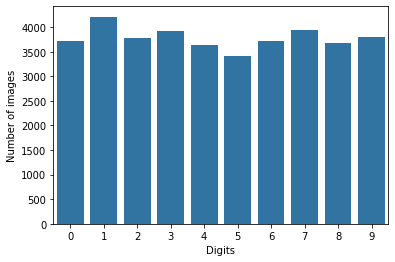

In [7]:
# number of images for each digit

g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

There are roughly the same amount of images for each of the 10 digits.

## Image re-scaling

We re-scale data for the CNN, between 0 and 1.

In [8]:
# Re-scale the data

# 255 is the maximum value a pixel can take

X_train = X_train / 255
X_test = X_test / 255

## Reshape

The images were stored in a pandas dataframe as 1-D vectors of 784 values. For a CNN with Keras, we need tensors with the following dimensions: width x height x channel. 

Thus, we reshape all data to 28 x 2 8 x 1, 3-D matrices. 

The 3rd dimension corresponds to the channel. RGB images have 3 channels. MNIST images are in gray-scale, thus they have only one channel in the 3rd dimension.

In [9]:
# Reshape image in 3 dimensions:
# height: 28px X width: 28px X channel: 1 

X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

## Target encoding

In [10]:
# the target is 1 variable with the 9 different digits
# as values

y_train.unique()

array([2, 0, 7, 4, 3, 5, 9, 6, 8, 1], dtype=int64)

In [11]:
# For Keras, we need to create 10 dummy variables,
# one for each digit

# Encode labels to one hot vectors (ex : digit 2 -> [0,0,1,0,0,0,0,0,0,0])

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

# the new target
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Let's print some example images.

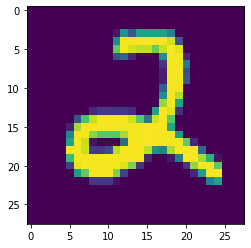

In [12]:
# Some image examples 

g = plt.imshow(X_train[0][:,:,0])

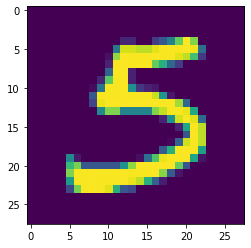

In [13]:
# Some image examples 

g = plt.imshow(X_train[10][:,:,0])

# Define the Hyperparameter Space

Hyperopt provides the hp module to create distributions to sample the hyperparameters. More details in [Defining a Search Space](http://hyperopt.github.io/hyperopt/getting-started/search_spaces/).


We want to find the following hyper-parameters:

- The learning rate of the optimizer.
- The number of convolutional layers.
- The number of fully-connected Dense layers.
- The number of nodes (neurons) for each of the dense layers.
- Whether to use 'sigmoid' or 'relu' activation in all the layers.

In [14]:
# determine the hyperparameter space

param_grid = {
    'learning_rate': hp.uniform('learning_rate', 1e-6, 1e-2),
    'num_conv_layers': hp.quniform('num_conv_layers', 1, 3, 1),
    'num_dense_layers': hp.quniform('num_dense_layers', 1, 5, 1),
    'num_dense_nodes': hp.quniform('num_dense_nodes', 5, 512, 1),
    'activation': hp.choice('activation', ['relu', 'sigmoid']),
}

# Define the CNN

We will create a CNN, with 2 Convolutional layers followed by Pooling, and varying number of fully-connected Dense layers. Each Convlutional layer, can itself have more than 1 conv layer.

In [15]:
# function to create the CNN

def create_cnn(
    # the hyperparam to optimize are passed
    # as arguments
    learning_rate,
    num_conv_layers,
    num_dense_layers,
    num_dense_nodes,
    activation,
):
    """
    Hyper-parameters:
    learning_rate:        Learning-rate for the optimizer.
    convolutional layers: Number of conv layers.
    num_dense_layers:     Number of dense layers.
    num_dense_nodes:      Number of nodes in each dense layer.
    activation:           Activation function for all layers.
    """

    # Start construction of a Keras Sequential model.
    model = Sequential()

    # First convolutional layer.
    # There are many hyper-parameters in this layer
    # For this demo, we will optimize the activation function and
    # the number of convolutional layers that it can take.
    
    # We add the different number of conv layers in the following loop:
    
    for i in range(num_conv_layers):
        model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                         activation=activation))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Second convolutional layer.
    # Same hyperparameters to optimize as previous layer.
    for i in range(num_conv_layers):
        model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                         activation=activation))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected Dense layer.
    model.add(Flatten())

    # Add fully-connected Dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    # We add the different number of layers in the following loop:
    
    for i in range(num_dense_layers):
        
        # Add the dense fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes (neurons) and the activation function.
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        ))

    # Last fully-connected dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(10, activation='softmax'))

    # Use the Adam method for training the network.
    # We want to find the best learning-rate for the Adam method.
    optimizer = Adam(learning_rate=learning_rate)

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Define the Objective Function

In [16]:
# we will save the model with this name
path_best_model = 'cnn_model.keras'

# starting point for the optimization
best_accuracy = 0

In [17]:
def objective(params):
    
    """
    Hyper-parameters:
    learning_rate:        Learning-rate for the optimizer.
    convolutional layers: Number of conv layers.
    num_dense_layers:     Number of dense layers.
    num_dense_nodes:      Number of nodes in each dense layer.
    activation:           Activation function for all layers.
    """

    # Print the hyper-parameters.        
    print('learning rate: ', params['learning_rate'])
    print('num_conv_layers: ', int(params['num_conv_layers']))
    print('num_dense_layers: ',int(params['num_dense_layers']))
    print('num_dense_nodes: ', int(params['num_dense_nodes']))
    print('activation: ', params['activation'])
    print()
    
    # Create the neural network with the hyper-parameters.
    # We call the function we created previously.
    model = create_cnn(learning_rate=params['learning_rate'],
                       num_conv_layers=int(params['num_conv_layers']),
                       num_dense_layers=int(params['num_dense_layers']),
                       num_dense_nodes=int(params['num_dense_nodes']),
                       activation=params['activation'],
                       )

   
    # Set a learning rate annealer
    # this reduces the learning rate if learning does not improve
    # for a certain number of epochs
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                                patience=2, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00001)
   
    # train the model
    # we use 3 epochs to be able to run the notebook in a "reasonable"
    # time. If we increase the epochs, we will have better performance
    # this could be another parameter to optimize in fact.
    history = model.fit(x=X_train,
                        y=y_train,
                        epochs=3,
                        batch_size=128,
                        validation_split=0.1,
                        callbacks=learning_rate_reduction)

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        # Training CNNs is costly, so we want to avoid having to re-train
        # the network with the best found parameters. We save it instead
        # as we search for the best hyperparam space.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    
    # Remember that Scikit-optimize always minimizes the objective
    # function, so we need to negate the accuracy (because we want
    # the maximum accuracy)
    return -accuracy

## Test run

In [18]:
# Before we run the hyper-parameter optimization,
# let's first check that the everything is working
# by passing some default hyper-parameters.

default_parameters = {
    'learning_rate': 1e-5,
    'num_conv_layers': 1,
    'num_dense_layers': 1,
    'num_dense_nodes': 16,
    'activation': 'relu',
}


objective(default_parameters)

learning rate:  1e-05
num_conv_layers:  1
num_dense_layers:  1
num_dense_nodes:  16
activation:  relu

Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 38s 104ms/step - accuracy: 0.1576 - loss: 2.2785 - val_accuracy: 0.3574 - val_loss: 2.2069 - learning_rate: 1.0000e-05
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 44s 112ms/step - accuracy: 0.4061 - loss: 2.1775 - val_accuracy: 0.4870 - val_loss: 2.0713 - learning_rate: 1.0000e-05
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - accuracy: 0.4951 - loss: 2.0236 - val_accuracy: 0.5143 - val_loss: 1.8627 - learning_rate: 1.0000e-05

Accuracy: 51.43%



-0.5142857432365417

We obtained a mediocre accuracy, but all our code is working. So let's get started with the Optimization now!!

## Bayesian Optimization with TPE

In [19]:
# fmin performs the minimization
# tpe.suggest samples the parameters following tpe

# with default parameters for TPE
trials = Trials()

search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=30,
    rstate=np.random.default_rng(42),
    algo=tpe.suggest,  # tpe
    trials=trials
)

learning rate:                                                                                                         
0.006517772255089191                                                                                                   
num_conv_layers:                                                                                                       
3                                                                                                                      
num_dense_layers:                                                                                                      
3                                                                                                                      
num_dense_nodes:                                                                                                       
418                                                                                                                    
activation:                             

 58/266 ━━━━━━━━━━━━━━━━━━━━ 1:11 344ms/step - accuracy: 0.1033 - loss: 2.5861      
 59/266 ━━━━━━━━━━━━━━━━━━━━ 1:11 346ms/step - accuracy: 0.1034 - loss: 2.5826      
 60/266 ━━━━━━━━━━━━━━━━━━━━ 1:11 346ms/step - accuracy: 0.1035 - loss: 2.5792      
 61/266 ━━━━━━━━━━━━━━━━━━━━ 1:11 347ms/step - accuracy: 0.1036 - loss: 2.5759      
 62/266 ━━━━━━━━━━━━━━━━━━━━ 1:10 347ms/step - accuracy: 0.1036 - loss: 2.5727      
 63/266 ━━━━━━━━━━━━━━━━━━━━ 1:10 347ms/step - accuracy: 0.1037 - loss: 2.5695      
 64/266 ━━━━━━━━━━━━━━━━━━━━ 1:10 348ms/step - accuracy: 0.1038 - loss: 2.5665      
 65/266 ━━━━━━━━━━━━━━━━━━━━ 1:09 348ms/step - accuracy: 0.1039 - loss: 2.5635      
 66/266 ━━━━━━━━━━━━━━━━━━━━ 1:09 348ms/step - accuracy: 0.1039 - loss: 2.5606      
 67/266 ━━━━━━━━━━━━━━━━━━━━ 1:09 349ms/step - accuracy: 0.1040 - loss: 2.5577      
 68/266 ━━━━━━━━━━━━━━━━━━━━ 1:08 348ms/step - accuracy: 0.1041 - loss: 2.5550      
 69/266 ━━━━━━━━━━━━━━━━━━━━ 1:08 348ms/step - accuracy: 0.1042 -

126/266 ━━━━━━━━━━━━━━━━━━━━ 47s 342ms/step - accuracy: 0.1064 - loss: 2.4609        
127/266 ━━━━━━━━━━━━━━━━━━━━ 47s 342ms/step - accuracy: 0.1064 - loss: 2.4599        
128/266 ━━━━━━━━━━━━━━━━━━━━ 47s 342ms/step - accuracy: 0.1064 - loss: 2.4590        
129/266 ━━━━━━━━━━━━━━━━━━━━ 46s 341ms/step - accuracy: 0.1064 - loss: 2.4580        
130/266 ━━━━━━━━━━━━━━━━━━━━ 46s 342ms/step - accuracy: 0.1064 - loss: 2.4571        
131/266 ━━━━━━━━━━━━━━━━━━━━ 46s 342ms/step - accuracy: 0.1065 - loss: 2.4562        
132/266 ━━━━━━━━━━━━━━━━━━━━ 45s 342ms/step - accuracy: 0.1065 - loss: 2.4553        
133/266 ━━━━━━━━━━━━━━━━━━━━ 45s 342ms/step - accuracy: 0.1065 - loss: 2.4544        
134/266 ━━━━━━━━━━━━━━━━━━━━ 45s 342ms/step - accuracy: 0.1065 - loss: 2.4535        
135/266 ━━━━━━━━━━━━━━━━━━━━ 44s 342ms/step - accuracy: 0.1066 - loss: 2.4526        
136/266 ━━━━━━━━━━━━━━━━━━━━ 44s 342ms/step - accuracy: 0.1066 - loss: 2.4518        
137/266 ━━━━━━━━━━━━━━━━━━━━ 44s 342ms/step - accuracy

194/266 ━━━━━━━━━━━━━━━━━━━━ 28s 402ms/step - accuracy: 0.1073 - loss: 2.4155        
195/266 ━━━━━━━━━━━━━━━━━━━━ 28s 403ms/step - accuracy: 0.1073 - loss: 2.4150        
196/266 ━━━━━━━━━━━━━━━━━━━━ 28s 404ms/step - accuracy: 0.1073 - loss: 2.4145        
197/266 ━━━━━━━━━━━━━━━━━━━━ 27s 405ms/step - accuracy: 0.1073 - loss: 2.4141        
198/266 ━━━━━━━━━━━━━━━━━━━━ 27s 406ms/step - accuracy: 0.1073 - loss: 2.4136        
199/266 ━━━━━━━━━━━━━━━━━━━━ 27s 408ms/step - accuracy: 0.1073 - loss: 2.4132        
200/266 ━━━━━━━━━━━━━━━━━━━━ 26s 409ms/step - accuracy: 0.1073 - loss: 2.4128        
201/266 ━━━━━━━━━━━━━━━━━━━━ 26s 410ms/step - accuracy: 0.1073 - loss: 2.4123        
202/266 ━━━━━━━━━━━━━━━━━━━━ 26s 411ms/step - accuracy: 0.1073 - loss: 2.4119        
203/266 ━━━━━━━━━━━━━━━━━━━━ 25s 412ms/step - accuracy: 0.1073 - loss: 2.4115        
204/266 ━━━━━━━━━━━━━━━━━━━━ 25s 414ms/step - accuracy: 0.1074 - loss: 2.4110        
205/266 ━━━━━━━━━━━━━━━━━━━━ 25s 414ms/step - accuracy

262/266 ━━━━━━━━━━━━━━━━━━━━ 1s 453ms/step - accuracy: 0.1075 - loss: 2.3913        
263/266 ━━━━━━━━━━━━━━━━━━━━ 1s 454ms/step - accuracy: 0.1075 - loss: 2.3910        
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.1075 - loss: 2.3908        
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.1075 - loss: 2.3905        
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.1075 - loss: 2.3902        
266/266 ━━━━━━━━━━━━━━━━━━━━ 135s 481ms/step - accuracy: 0.1075 - loss: 2.3900 - val_accuracy: 0.1037 - val_loss: 2.3024 - learning_rate: 0.0065

Epoch 2/3                                                                                                              

  1/266 ━━━━━━━━━━━━━━━━━━━━ 1:06:38 15s/step - accuracy: 0.0547 - loss: 2.3019               
  2/266 ━━━━━━━━━━━━━━━━━━━━ 2:27 560ms/step - accuracy: 0.0605 - loss: 2.3031                
  3/266 ━━━━━━━━━━━━━━━━━━━━ 2:32 579ms/step - accuracy: 0.0664 - loss: 2.3031               
  4/266 ━━━━━━━━━━━━━━━━

 62/266 ━━━━━━━━━━━━━━━━━━━━ 2:01 596ms/step - accuracy: 0.1004 - loss: 2.3019      
 63/266 ━━━━━━━━━━━━━━━━━━━━ 2:00 595ms/step - accuracy: 0.1005 - loss: 2.3019      
 64/266 ━━━━━━━━━━━━━━━━━━━━ 2:00 595ms/step - accuracy: 0.1007 - loss: 2.3019      
 65/266 ━━━━━━━━━━━━━━━━━━━━ 1:59 595ms/step - accuracy: 0.1008 - loss: 2.3019      
 66/266 ━━━━━━━━━━━━━━━━━━━━ 1:59 595ms/step - accuracy: 0.1010 - loss: 2.3018      
 67/266 ━━━━━━━━━━━━━━━━━━━━ 1:58 597ms/step - accuracy: 0.1011 - loss: 2.3018      
 68/266 ━━━━━━━━━━━━━━━━━━━━ 1:58 597ms/step - accuracy: 0.1012 - loss: 2.3018      
 69/266 ━━━━━━━━━━━━━━━━━━━━ 1:57 597ms/step - accuracy: 0.1013 - loss: 2.3018      
 70/266 ━━━━━━━━━━━━━━━━━━━━ 1:56 596ms/step - accuracy: 0.1015 - loss: 2.3018      
 71/266 ━━━━━━━━━━━━━━━━━━━━ 1:56 597ms/step - accuracy: 0.1016 - loss: 2.3018      
 72/266 ━━━━━━━━━━━━━━━━━━━━ 1:55 597ms/step - accuracy: 0.1017 - loss: 2.3018      
 73/266 ━━━━━━━━━━━━━━━━━━━━ 1:55 598ms/step - accuracy: 0.1018 -

130/266 ━━━━━━━━━━━━━━━━━━━━ 1:12 536ms/step - accuracy: 0.1056 - loss: 2.3018      
131/266 ━━━━━━━━━━━━━━━━━━━━ 1:12 535ms/step - accuracy: 0.1056 - loss: 2.3018      
132/266 ━━━━━━━━━━━━━━━━━━━━ 1:11 534ms/step - accuracy: 0.1057 - loss: 2.3018      
133/266 ━━━━━━━━━━━━━━━━━━━━ 1:10 532ms/step - accuracy: 0.1057 - loss: 2.3018      
134/266 ━━━━━━━━━━━━━━━━━━━━ 1:10 531ms/step - accuracy: 0.1058 - loss: 2.3018      
135/266 ━━━━━━━━━━━━━━━━━━━━ 1:09 529ms/step - accuracy: 0.1058 - loss: 2.3018      
136/266 ━━━━━━━━━━━━━━━━━━━━ 1:08 528ms/step - accuracy: 0.1058 - loss: 2.3018      
137/266 ━━━━━━━━━━━━━━━━━━━━ 1:07 527ms/step - accuracy: 0.1059 - loss: 2.3018      
138/266 ━━━━━━━━━━━━━━━━━━━━ 1:07 526ms/step - accuracy: 0.1059 - loss: 2.3018      
139/266 ━━━━━━━━━━━━━━━━━━━━ 1:06 525ms/step - accuracy: 0.1060 - loss: 2.3018      
140/266 ━━━━━━━━━━━━━━━━━━━━ 1:05 524ms/step - accuracy: 0.1060 - loss: 2.3018      
141/266 ━━━━━━━━━━━━━━━━━━━━ 1:05 522ms/step - accuracy: 0.1060 -

198/266 ━━━━━━━━━━━━━━━━━━━━ 32s 477ms/step - accuracy: 0.1073 - loss: 2.3018        
199/266 ━━━━━━━━━━━━━━━━━━━━ 31s 476ms/step - accuracy: 0.1074 - loss: 2.3018        
200/266 ━━━━━━━━━━━━━━━━━━━━ 31s 476ms/step - accuracy: 0.1074 - loss: 2.3018        
201/266 ━━━━━━━━━━━━━━━━━━━━ 30s 475ms/step - accuracy: 0.1074 - loss: 2.3018        
202/266 ━━━━━━━━━━━━━━━━━━━━ 30s 474ms/step - accuracy: 0.1074 - loss: 2.3018        
203/266 ━━━━━━━━━━━━━━━━━━━━ 29s 474ms/step - accuracy: 0.1074 - loss: 2.3018        
204/266 ━━━━━━━━━━━━━━━━━━━━ 29s 473ms/step - accuracy: 0.1074 - loss: 2.3018        
205/266 ━━━━━━━━━━━━━━━━━━━━ 28s 472ms/step - accuracy: 0.1075 - loss: 2.3018        
206/266 ━━━━━━━━━━━━━━━━━━━━ 28s 472ms/step - accuracy: 0.1075 - loss: 2.3018        
207/266 ━━━━━━━━━━━━━━━━━━━━ 27s 471ms/step - accuracy: 0.1075 - loss: 2.3018        
208/266 ━━━━━━━━━━━━━━━━━━━━ 27s 471ms/step - accuracy: 0.1075 - loss: 2.3018        
209/266 ━━━━━━━━━━━━━━━━━━━━ 26s 470ms/step - accuracy

266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.1081 - loss: 2.3018        
266/266 ━━━━━━━━━━━━━━━━━━━━ 137s 461ms/step - accuracy: 0.1081 - loss: 2.3018 - val_accuracy: 0.1146 - val_loss: 2.3021 - learning_rate: 0.0065

Epoch 3/3                                                                                                              

  1/266 ━━━━━━━━━━━━━━━━━━━━ 2:09 488ms/step - accuracy: 0.1406 - loss: 2.3017                
  2/266 ━━━━━━━━━━━━━━━━━━━━ 1:37 369ms/step - accuracy: 0.1250 - loss: 2.3032               
  3/266 ━━━━━━━━━━━━━━━━━━━━ 1:39 377ms/step - accuracy: 0.1224 - loss: 2.3032               
  4/266 ━━━━━━━━━━━━━━━━━━━━ 1:41 386ms/step - accuracy: 0.1206 - loss: 2.3033               
  5/266 ━━━━━━━━━━━━━━━━━━━━ 1:40 383ms/step - accuracy: 0.1193 - loss: 2.3033               
  6/266 ━━━━━━━━━━━━━━━━━━━━ 1:40 385ms/step - accuracy: 0.1183 - loss: 2.3033               
  7/266 ━━━━━━━━━━━━━━━━━━━━ 1:36 374ms/step - accuracy: 0.1173 - loss: 2.3032     

 66/266 ━━━━━━━━━━━━━━━━━━━━ 1:40 501ms/step - accuracy: 0.1146 - loss: 2.3018      
 67/266 ━━━━━━━━━━━━━━━━━━━━ 1:39 502ms/step - accuracy: 0.1146 - loss: 2.3018      
 68/266 ━━━━━━━━━━━━━━━━━━━━ 1:39 503ms/step - accuracy: 0.1146 - loss: 2.3018      
 69/266 ━━━━━━━━━━━━━━━━━━━━ 1:39 505ms/step - accuracy: 0.1146 - loss: 2.3018      
 70/266 ━━━━━━━━━━━━━━━━━━━━ 1:39 508ms/step - accuracy: 0.1146 - loss: 2.3018      
 71/266 ━━━━━━━━━━━━━━━━━━━━ 1:39 508ms/step - accuracy: 0.1146 - loss: 2.3018      
 72/266 ━━━━━━━━━━━━━━━━━━━━ 1:38 509ms/step - accuracy: 0.1146 - loss: 2.3018      
 73/266 ━━━━━━━━━━━━━━━━━━━━ 1:38 510ms/step - accuracy: 0.1146 - loss: 2.3018      
 74/266 ━━━━━━━━━━━━━━━━━━━━ 1:38 512ms/step - accuracy: 0.1146 - loss: 2.3018      
 75/266 ━━━━━━━━━━━━━━━━━━━━ 1:38 514ms/step - accuracy: 0.1145 - loss: 2.3018      
 76/266 ━━━━━━━━━━━━━━━━━━━━ 1:37 515ms/step - accuracy: 0.1145 - loss: 2.3018      
 77/266 ━━━━━━━━━━━━━━━━━━━━ 1:37 517ms/step - accuracy: 0.1145 -

134/266 ━━━━━━━━━━━━━━━━━━━━ 1:11 545ms/step - accuracy: 0.1141 - loss: 2.3017      
135/266 ━━━━━━━━━━━━━━━━━━━━ 1:11 545ms/step - accuracy: 0.1141 - loss: 2.3017      
136/266 ━━━━━━━━━━━━━━━━━━━━ 1:10 545ms/step - accuracy: 0.1141 - loss: 2.3017      
137/266 ━━━━━━━━━━━━━━━━━━━━ 1:10 546ms/step - accuracy: 0.1141 - loss: 2.3017      
138/266 ━━━━━━━━━━━━━━━━━━━━ 1:09 546ms/step - accuracy: 0.1141 - loss: 2.3017      
139/266 ━━━━━━━━━━━━━━━━━━━━ 1:09 547ms/step - accuracy: 0.1141 - loss: 2.3017      
140/266 ━━━━━━━━━━━━━━━━━━━━ 1:08 547ms/step - accuracy: 0.1141 - loss: 2.3017      
141/266 ━━━━━━━━━━━━━━━━━━━━ 1:08 547ms/step - accuracy: 0.1141 - loss: 2.3017      
142/266 ━━━━━━━━━━━━━━━━━━━━ 1:07 547ms/step - accuracy: 0.1141 - loss: 2.3017      
143/266 ━━━━━━━━━━━━━━━━━━━━ 1:07 547ms/step - accuracy: 0.1141 - loss: 2.3017      
144/266 ━━━━━━━━━━━━━━━━━━━━ 1:06 547ms/step - accuracy: 0.1141 - loss: 2.3017      
145/266 ━━━━━━━━━━━━━━━━━━━━ 1:06 548ms/step - accuracy: 0.1141 -

202/266 ━━━━━━━━━━━━━━━━━━━━ 36s 564ms/step - accuracy: 0.1136 - loss: 2.3017        
203/266 ━━━━━━━━━━━━━━━━━━━━ 35s 564ms/step - accuracy: 0.1136 - loss: 2.3017        
204/266 ━━━━━━━━━━━━━━━━━━━━ 34s 564ms/step - accuracy: 0.1136 - loss: 2.3017        
205/266 ━━━━━━━━━━━━━━━━━━━━ 34s 564ms/step - accuracy: 0.1136 - loss: 2.3017        
206/266 ━━━━━━━━━━━━━━━━━━━━ 33s 564ms/step - accuracy: 0.1136 - loss: 2.3017        
207/266 ━━━━━━━━━━━━━━━━━━━━ 33s 564ms/step - accuracy: 0.1136 - loss: 2.3017        
208/266 ━━━━━━━━━━━━━━━━━━━━ 32s 564ms/step - accuracy: 0.1135 - loss: 2.3017        
209/266 ━━━━━━━━━━━━━━━━━━━━ 32s 565ms/step - accuracy: 0.1135 - loss: 2.3017        
210/266 ━━━━━━━━━━━━━━━━━━━━ 31s 565ms/step - accuracy: 0.1135 - loss: 2.3017        
211/266 ━━━━━━━━━━━━━━━━━━━━ 31s 565ms/step - accuracy: 0.1135 - loss: 2.3017        
212/266 ━━━━━━━━━━━━━━━━━━━━ 30s 566ms/step - accuracy: 0.1135 - loss: 2.3017        
213/266 ━━━━━━━━━━━━━━━━━━━━ 29s 566ms/step - accuracy

learning rate:                                                                                                         
0.000600301954624924                                                                                                   
num_conv_layers:                                                                                                       
3                                                                                                                      
num_dense_layers:                                                                                                      
3                                                                                                                      
num_dense_nodes:                                                                                                       
157                                                                                                                    
activation:                             

 58/266 ━━━━━━━━━━━━━━━━━━━━ 1:35 461ms/step - accuracy: 0.0995 - loss: 2.3551      
 59/266 ━━━━━━━━━━━━━━━━━━━━ 1:36 469ms/step - accuracy: 0.0996 - loss: 2.3545      
 60/266 ━━━━━━━━━━━━━━━━━━━━ 1:36 469ms/step - accuracy: 0.0997 - loss: 2.3540      
 61/266 ━━━━━━━━━━━━━━━━━━━━ 1:36 469ms/step - accuracy: 0.0997 - loss: 2.3535      
 62/266 ━━━━━━━━━━━━━━━━━━━━ 1:35 469ms/step - accuracy: 0.0998 - loss: 2.3529      
 63/266 ━━━━━━━━━━━━━━━━━━━━ 1:35 470ms/step - accuracy: 0.0999 - loss: 2.3524      
 64/266 ━━━━━━━━━━━━━━━━━━━━ 1:35 471ms/step - accuracy: 0.0999 - loss: 2.3519      
 65/266 ━━━━━━━━━━━━━━━━━━━━ 1:35 473ms/step - accuracy: 0.1000 - loss: 2.3514      
 66/266 ━━━━━━━━━━━━━━━━━━━━ 1:34 474ms/step - accuracy: 0.1000 - loss: 2.3509      
 67/266 ━━━━━━━━━━━━━━━━━━━━ 1:34 474ms/step - accuracy: 0.1001 - loss: 2.3505      
 68/266 ━━━━━━━━━━━━━━━━━━━━ 1:33 474ms/step - accuracy: 0.1002 - loss: 2.3500      
 69/266 ━━━━━━━━━━━━━━━━━━━━ 1:33 474ms/step - accuracy: 0.1002 -

126/266 ━━━━━━━━━━━━━━━━━━━━ 1:08 491ms/step - accuracy: 0.1026 - loss: 2.3344      
127/266 ━━━━━━━━━━━━━━━━━━━━ 1:08 492ms/step - accuracy: 0.1027 - loss: 2.3342      
128/266 ━━━━━━━━━━━━━━━━━━━━ 1:07 491ms/step - accuracy: 0.1027 - loss: 2.3340      
129/266 ━━━━━━━━━━━━━━━━━━━━ 1:07 490ms/step - accuracy: 0.1027 - loss: 2.3339      
130/266 ━━━━━━━━━━━━━━━━━━━━ 1:06 490ms/step - accuracy: 0.1028 - loss: 2.3337      
131/266 ━━━━━━━━━━━━━━━━━━━━ 1:06 490ms/step - accuracy: 0.1028 - loss: 2.3336      
132/266 ━━━━━━━━━━━━━━━━━━━━ 1:05 490ms/step - accuracy: 0.1028 - loss: 2.3334      
133/266 ━━━━━━━━━━━━━━━━━━━━ 1:05 491ms/step - accuracy: 0.1029 - loss: 2.3332      
134/266 ━━━━━━━━━━━━━━━━━━━━ 1:05 495ms/step - accuracy: 0.1029 - loss: 2.3331      
135/266 ━━━━━━━━━━━━━━━━━━━━ 1:05 499ms/step - accuracy: 0.1029 - loss: 2.3329      
136/266 ━━━━━━━━━━━━━━━━━━━━ 1:05 501ms/step - accuracy: 0.1029 - loss: 2.3328      
137/266 ━━━━━━━━━━━━━━━━━━━━ 1:04 502ms/step - accuracy: 0.1030 -

194/266 ━━━━━━━━━━━━━━━━━━━━ 35s 488ms/step - accuracy: 0.1039 - loss: 2.3265        
195/266 ━━━━━━━━━━━━━━━━━━━━ 34s 488ms/step - accuracy: 0.1039 - loss: 2.3264        
196/266 ━━━━━━━━━━━━━━━━━━━━ 34s 489ms/step - accuracy: 0.1040 - loss: 2.3263        
197/266 ━━━━━━━━━━━━━━━━━━━━ 33s 490ms/step - accuracy: 0.1040 - loss: 2.3262        
198/266 ━━━━━━━━━━━━━━━━━━━━ 33s 491ms/step - accuracy: 0.1040 - loss: 2.3261        
199/266 ━━━━━━━━━━━━━━━━━━━━ 32s 491ms/step - accuracy: 0.1040 - loss: 2.3261        
200/266 ━━━━━━━━━━━━━━━━━━━━ 32s 491ms/step - accuracy: 0.1040 - loss: 2.3260        
201/266 ━━━━━━━━━━━━━━━━━━━━ 31s 492ms/step - accuracy: 0.1040 - loss: 2.3259        
202/266 ━━━━━━━━━━━━━━━━━━━━ 31s 493ms/step - accuracy: 0.1040 - loss: 2.3258        
203/266 ━━━━━━━━━━━━━━━━━━━━ 31s 493ms/step - accuracy: 0.1040 - loss: 2.3257        
204/266 ━━━━━━━━━━━━━━━━━━━━ 30s 495ms/step - accuracy: 0.1040 - loss: 2.3257        
205/266 ━━━━━━━━━━━━━━━━━━━━ 30s 495ms/step - accuracy

262/266 ━━━━━━━━━━━━━━━━━━━━ 2s 524ms/step - accuracy: 0.1045 - loss: 2.3222        
263/266 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step - accuracy: 0.1045 - loss: 2.3222        
264/266 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step - accuracy: 0.1045 - loss: 2.3221        
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.1045 - loss: 2.3221        
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.1045 - loss: 2.3220        
266/266 ━━━━━━━━━━━━━━━━━━━━ 169s 558ms/step - accuracy: 0.1045 - loss: 2.3220 - val_accuracy: 0.1146 - val_loss: 2.3041 - learning_rate: 6.0030e-04

Epoch 2/3                                                                                                              

  1/266 ━━━━━━━━━━━━━━━━━━━━ 4:00:24 54s/step - accuracy: 0.1406 - loss: 2.3044               
  2/266 ━━━━━━━━━━━━━━━━━━━━ 2:05 476ms/step - accuracy: 0.1250 - loss: 2.3079                
  3/266 ━━━━━━━━━━━━━━━━━━━━ 2:08 488ms/step - accuracy: 0.1224 - loss: 2.3070               
  4/266 ━━━━━━━━━━━━

 62/266 ━━━━━━━━━━━━━━━━━━━━ 1:23 410ms/step - accuracy: 0.1011 - loss: 2.3069      
 63/266 ━━━━━━━━━━━━━━━━━━━━ 1:23 410ms/step - accuracy: 0.1011 - loss: 2.3069      
 64/266 ━━━━━━━━━━━━━━━━━━━━ 1:22 408ms/step - accuracy: 0.1011 - loss: 2.3069      
 65/266 ━━━━━━━━━━━━━━━━━━━━ 1:21 407ms/step - accuracy: 0.1010 - loss: 2.3069      
 66/266 ━━━━━━━━━━━━━━━━━━━━ 1:21 408ms/step - accuracy: 0.1010 - loss: 2.3068      
 67/266 ━━━━━━━━━━━━━━━━━━━━ 1:21 407ms/step - accuracy: 0.1010 - loss: 2.3068      
 68/266 ━━━━━━━━━━━━━━━━━━━━ 1:20 407ms/step - accuracy: 0.1010 - loss: 2.3068      
 69/266 ━━━━━━━━━━━━━━━━━━━━ 1:20 406ms/step - accuracy: 0.1010 - loss: 2.3068      
 70/266 ━━━━━━━━━━━━━━━━━━━━ 1:19 405ms/step - accuracy: 0.1010 - loss: 2.3068      
 71/266 ━━━━━━━━━━━━━━━━━━━━ 1:18 405ms/step - accuracy: 0.1009 - loss: 2.3068      
 72/266 ━━━━━━━━━━━━━━━━━━━━ 1:18 405ms/step - accuracy: 0.1009 - loss: 2.3068      
 73/266 ━━━━━━━━━━━━━━━━━━━━ 1:17 403ms/step - accuracy: 0.1009 -

130/266 ━━━━━━━━━━━━━━━━━━━━ 1:00 446ms/step - accuracy: 0.1016 - loss: 2.3066      
131/266 ━━━━━━━━━━━━━━━━━━━━ 1:00 447ms/step - accuracy: 0.1016 - loss: 2.3066      
132/266 ━━━━━━━━━━━━━━━━━━━━ 1:00 448ms/step - accuracy: 0.1016 - loss: 2.3066      
133/266 ━━━━━━━━━━━━━━━━━━━━ 59s 449ms/step - accuracy: 0.1016 - loss: 2.3066       
134/266 ━━━━━━━━━━━━━━━━━━━━ 59s 452ms/step - accuracy: 0.1016 - loss: 2.3066        
135/266 ━━━━━━━━━━━━━━━━━━━━ 59s 452ms/step - accuracy: 0.1017 - loss: 2.3066        
136/266 ━━━━━━━━━━━━━━━━━━━━ 58s 452ms/step - accuracy: 0.1017 - loss: 2.3066        
137/266 ━━━━━━━━━━━━━━━━━━━━ 58s 452ms/step - accuracy: 0.1017 - loss: 2.3066        
138/266 ━━━━━━━━━━━━━━━━━━━━ 57s 452ms/step - accuracy: 0.1017 - loss: 2.3066        
139/266 ━━━━━━━━━━━━━━━━━━━━ 57s 453ms/step - accuracy: 0.1017 - loss: 2.3066        
140/266 ━━━━━━━━━━━━━━━━━━━━ 57s 453ms/step - accuracy: 0.1017 - loss: 2.3066        
141/266 ━━━━━━━━━━━━━━━━━━━━ 56s 453ms/step - accuracy: 0.

198/266 ━━━━━━━━━━━━━━━━━━━━ 35s 521ms/step - accuracy: 0.1025 - loss: 2.3064        
199/266 ━━━━━━━━━━━━━━━━━━━━ 35s 522ms/step - accuracy: 0.1025 - loss: 2.3064        
200/266 ━━━━━━━━━━━━━━━━━━━━ 34s 525ms/step - accuracy: 0.1025 - loss: 2.3063        
201/266 ━━━━━━━━━━━━━━━━━━━━ 34s 526ms/step - accuracy: 0.1026 - loss: 2.3063        
202/266 ━━━━━━━━━━━━━━━━━━━━ 33s 527ms/step - accuracy: 0.1026 - loss: 2.3063        
203/266 ━━━━━━━━━━━━━━━━━━━━ 33s 528ms/step - accuracy: 0.1026 - loss: 2.3063        
204/266 ━━━━━━━━━━━━━━━━━━━━ 32s 528ms/step - accuracy: 0.1026 - loss: 2.3063        
205/266 ━━━━━━━━━━━━━━━━━━━━ 32s 529ms/step - accuracy: 0.1026 - loss: 2.3063        
206/266 ━━━━━━━━━━━━━━━━━━━━ 31s 529ms/step - accuracy: 0.1026 - loss: 2.3063        
207/266 ━━━━━━━━━━━━━━━━━━━━ 31s 529ms/step - accuracy: 0.1026 - loss: 2.3063        
208/266 ━━━━━━━━━━━━━━━━━━━━ 30s 530ms/step - accuracy: 0.1026 - loss: 2.3063        
209/266 ━━━━━━━━━━━━━━━━━━━━ 30s 529ms/step - accuracy

266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.1031 - loss: 2.3062        
266/266 ━━━━━━━━━━━━━━━━━━━━ 208s 579ms/step - accuracy: 0.1031 - loss: 2.3062 - val_accuracy: 0.1146 - val_loss: 2.3037 - learning_rate: 6.0030e-04

Epoch 3/3                                                                                                              

  1/266 ━━━━━━━━━━━━━━━━━━━━ 3:35:07 49s/step - accuracy: 0.1406 - loss: 2.3052               
  2/266 ━━━━━━━━━━━━━━━━━━━━ 1:23 315ms/step - accuracy: 0.1250 - loss: 2.3079                
  3/266 ━━━━━━━━━━━━━━━━━━━━ 1:20 308ms/step - accuracy: 0.1224 - loss: 2.3070               
  4/266 ━━━━━━━━━━━━━━━━━━━━ 1:20 309ms/step - accuracy: 0.1206 - loss: 2.3059               
  5/266 ━━━━━━━━━━━━━━━━━━━━ 1:20 308ms/step - accuracy: 0.1193 - loss: 2.3053               
  6/266 ━━━━━━━━━━━━━━━━━━━━ 1:16 295ms/step - accuracy: 0.1183 - loss: 2.3051               
  7/266 ━━━━━━━━━━━━━━━━━━━━ 1:13 285ms/step - accuracy: 0.1185 - loss: 2.3046

 66/266 ━━━━━━━━━━━━━━━━━━━━ 1:13 367ms/step - accuracy: 0.1032 - loss: 2.3061      
 67/266 ━━━━━━━━━━━━━━━━━━━━ 1:12 366ms/step - accuracy: 0.1032 - loss: 2.3061      
 68/266 ━━━━━━━━━━━━━━━━━━━━ 1:12 365ms/step - accuracy: 0.1032 - loss: 2.3061      
 69/266 ━━━━━━━━━━━━━━━━━━━━ 1:11 365ms/step - accuracy: 0.1032 - loss: 2.3061      
 70/266 ━━━━━━━━━━━━━━━━━━━━ 1:11 365ms/step - accuracy: 0.1032 - loss: 2.3061      
 71/266 ━━━━━━━━━━━━━━━━━━━━ 1:11 364ms/step - accuracy: 0.1032 - loss: 2.3061      
 72/266 ━━━━━━━━━━━━━━━━━━━━ 1:10 363ms/step - accuracy: 0.1031 - loss: 2.3061      
 73/266 ━━━━━━━━━━━━━━━━━━━━ 1:09 362ms/step - accuracy: 0.1031 - loss: 2.3061      
 74/266 ━━━━━━━━━━━━━━━━━━━━ 1:09 362ms/step - accuracy: 0.1031 - loss: 2.3061      
 75/266 ━━━━━━━━━━━━━━━━━━━━ 1:09 362ms/step - accuracy: 0.1031 - loss: 2.3061      
 76/266 ━━━━━━━━━━━━━━━━━━━━ 1:08 363ms/step - accuracy: 0.1031 - loss: 2.3061      
 77/266 ━━━━━━━━━━━━━━━━━━━━ 1:08 362ms/step - accuracy: 0.1031 -

134/266 ━━━━━━━━━━━━━━━━━━━━ 54s 410ms/step - accuracy: 0.1036 - loss: 2.3059        
135/266 ━━━━━━━━━━━━━━━━━━━━ 53s 411ms/step - accuracy: 0.1036 - loss: 2.3059        
136/266 ━━━━━━━━━━━━━━━━━━━━ 53s 412ms/step - accuracy: 0.1036 - loss: 2.3059        
137/266 ━━━━━━━━━━━━━━━━━━━━ 53s 413ms/step - accuracy: 0.1036 - loss: 2.3059        
138/266 ━━━━━━━━━━━━━━━━━━━━ 52s 414ms/step - accuracy: 0.1036 - loss: 2.3059        
139/266 ━━━━━━━━━━━━━━━━━━━━ 52s 414ms/step - accuracy: 0.1036 - loss: 2.3059        
140/266 ━━━━━━━━━━━━━━━━━━━━ 52s 414ms/step - accuracy: 0.1037 - loss: 2.3059        
141/266 ━━━━━━━━━━━━━━━━━━━━ 51s 414ms/step - accuracy: 0.1037 - loss: 2.3059        
142/266 ━━━━━━━━━━━━━━━━━━━━ 51s 414ms/step - accuracy: 0.1037 - loss: 2.3059        
143/266 ━━━━━━━━━━━━━━━━━━━━ 50s 414ms/step - accuracy: 0.1037 - loss: 2.3059        
144/266 ━━━━━━━━━━━━━━━━━━━━ 50s 414ms/step - accuracy: 0.1037 - loss: 2.3059        
145/266 ━━━━━━━━━━━━━━━━━━━━ 50s 415ms/step - accuracy

202/266 ━━━━━━━━━━━━━━━━━━━━ 29s 459ms/step - accuracy: 0.1043 - loss: 2.3057        
203/266 ━━━━━━━━━━━━━━━━━━━━ 29s 460ms/step - accuracy: 0.1043 - loss: 2.3057        
204/266 ━━━━━━━━━━━━━━━━━━━━ 28s 462ms/step - accuracy: 0.1043 - loss: 2.3057        
205/266 ━━━━━━━━━━━━━━━━━━━━ 28s 463ms/step - accuracy: 0.1044 - loss: 2.3057        
206/266 ━━━━━━━━━━━━━━━━━━━━ 27s 465ms/step - accuracy: 0.1044 - loss: 2.3057        
207/266 ━━━━━━━━━━━━━━━━━━━━ 27s 466ms/step - accuracy: 0.1044 - loss: 2.3057        
208/266 ━━━━━━━━━━━━━━━━━━━━ 27s 467ms/step - accuracy: 0.1044 - loss: 2.3057        
209/266 ━━━━━━━━━━━━━━━━━━━━ 26s 469ms/step - accuracy: 0.1044 - loss: 2.3057        
210/266 ━━━━━━━━━━━━━━━━━━━━ 26s 469ms/step - accuracy: 0.1044 - loss: 2.3057        
211/266 ━━━━━━━━━━━━━━━━━━━━ 25s 471ms/step - accuracy: 0.1044 - loss: 2.3057        
212/266 ━━━━━━━━━━━━━━━━━━━━ 25s 473ms/step - accuracy: 0.1044 - loss: 2.3057        
213/266 ━━━━━━━━━━━━━━━━━━━━ 25s 474ms/step - accuracy

Accuracy: 11.46%                                                                                                       
learning rate:                                                                                                         
0.0015726398259184094                                                                                                  
num_conv_layers:                                                                                                       
2                                                                                                                      
num_dense_layers:                                                                                                      
1                                                                                                                      
num_dense_nodes:                                                                                                       
80                                      

 57/266 ━━━━━━━━━━━━━━━━━━━━ 59s 284ms/step - accuracy: 0.1103 - loss: 2.4179        
 58/266 ━━━━━━━━━━━━━━━━━━━━ 59s 285ms/step - accuracy: 0.1102 - loss: 2.4165        
 59/266 ━━━━━━━━━━━━━━━━━━━━ 58s 285ms/step - accuracy: 0.1102 - loss: 2.4152        
 60/266 ━━━━━━━━━━━━━━━━━━━━ 58s 286ms/step - accuracy: 0.1102 - loss: 2.4140        
 61/266 ━━━━━━━━━━━━━━━━━━━━ 58s 285ms/step - accuracy: 0.1102 - loss: 2.4127        
 62/266 ━━━━━━━━━━━━━━━━━━━━ 58s 287ms/step - accuracy: 0.1101 - loss: 2.4115        
 63/266 ━━━━━━━━━━━━━━━━━━━━ 58s 286ms/step - accuracy: 0.1101 - loss: 2.4104        
 64/266 ━━━━━━━━━━━━━━━━━━━━ 57s 286ms/step - accuracy: 0.1101 - loss: 2.4092        
 65/266 ━━━━━━━━━━━━━━━━━━━━ 57s 287ms/step - accuracy: 0.1100 - loss: 2.4081        
 66/266 ━━━━━━━━━━━━━━━━━━━━ 57s 286ms/step - accuracy: 0.1100 - loss: 2.4070        
 67/266 ━━━━━━━━━━━━━━━━━━━━ 56s 286ms/step - accuracy: 0.1100 - loss: 2.4060        
 68/266 ━━━━━━━━━━━━━━━━━━━━ 56s 285ms/step - accuracy

125/266 ━━━━━━━━━━━━━━━━━━━━ 40s 284ms/step - accuracy: 0.1085 - loss: 2.3700        
126/266 ━━━━━━━━━━━━━━━━━━━━ 39s 284ms/step - accuracy: 0.1085 - loss: 2.3697        
127/266 ━━━━━━━━━━━━━━━━━━━━ 39s 285ms/step - accuracy: 0.1084 - loss: 2.3693        
128/266 ━━━━━━━━━━━━━━━━━━━━ 39s 285ms/step - accuracy: 0.1084 - loss: 2.3689        
129/266 ━━━━━━━━━━━━━━━━━━━━ 39s 285ms/step - accuracy: 0.1084 - loss: 2.3686        
130/266 ━━━━━━━━━━━━━━━━━━━━ 38s 285ms/step - accuracy: 0.1084 - loss: 2.3682        
131/266 ━━━━━━━━━━━━━━━━━━━━ 38s 284ms/step - accuracy: 0.1084 - loss: 2.3679        
132/266 ━━━━━━━━━━━━━━━━━━━━ 38s 285ms/step - accuracy: 0.1083 - loss: 2.3675        
133/266 ━━━━━━━━━━━━━━━━━━━━ 37s 285ms/step - accuracy: 0.1083 - loss: 2.3672        
134/266 ━━━━━━━━━━━━━━━━━━━━ 37s 285ms/step - accuracy: 0.1083 - loss: 2.3668        
135/266 ━━━━━━━━━━━━━━━━━━━━ 37s 285ms/step - accuracy: 0.1083 - loss: 2.3665        
136/266 ━━━━━━━━━━━━━━━━━━━━ 37s 288ms/step - accuracy

193/266 ━━━━━━━━━━━━━━━━━━━━ 21s 294ms/step - accuracy: 0.1074 - loss: 2.3525        
194/266 ━━━━━━━━━━━━━━━━━━━━ 21s 294ms/step - accuracy: 0.1074 - loss: 2.3524        
195/266 ━━━━━━━━━━━━━━━━━━━━ 20s 294ms/step - accuracy: 0.1074 - loss: 2.3522        
196/266 ━━━━━━━━━━━━━━━━━━━━ 20s 294ms/step - accuracy: 0.1074 - loss: 2.3520        
197/266 ━━━━━━━━━━━━━━━━━━━━ 20s 294ms/step - accuracy: 0.1074 - loss: 2.3518        
198/266 ━━━━━━━━━━━━━━━━━━━━ 20s 294ms/step - accuracy: 0.1073 - loss: 2.3517        
199/266 ━━━━━━━━━━━━━━━━━━━━ 19s 296ms/step - accuracy: 0.1073 - loss: 2.3515        
200/266 ━━━━━━━━━━━━━━━━━━━━ 19s 296ms/step - accuracy: 0.1073 - loss: 2.3513        
201/266 ━━━━━━━━━━━━━━━━━━━━ 19s 297ms/step - accuracy: 0.1073 - loss: 2.3512        
202/266 ━━━━━━━━━━━━━━━━━━━━ 18s 296ms/step - accuracy: 0.1073 - loss: 2.3510        
203/266 ━━━━━━━━━━━━━━━━━━━━ 18s 297ms/step - accuracy: 0.1073 - loss: 2.3508        
204/266 ━━━━━━━━━━━━━━━━━━━━ 18s 297ms/step - accuracy

261/266 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step - accuracy: 0.1068 - loss: 2.3432        
262/266 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step - accuracy: 0.1068 - loss: 2.3431        
263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.1068 - loss: 2.3430        
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.1067 - loss: 2.3429        
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.1067 - loss: 2.3428        
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.1067 - loss: 2.3427        
266/266 ━━━━━━━━━━━━━━━━━━━━ 97s 324ms/step - accuracy: 0.1067 - loss: 2.3426 - val_accuracy: 0.1146 - val_loss: 2.3065 - learning_rate: 0.0016

Epoch 2/3                                                                                                              

  1/266 ━━━━━━━━━━━━━━━━━━━━ 4:10:31 57s/step - accuracy: 0.1406 - loss: 2.3054               
  2/266 ━━━━━━━━━━━━━━━━━━━━ 2:00 458ms/step - accuracy: 0.1250 - loss: 2.3080                
  3/266 ━━━━━━━━━━━━━━━━━━━━ 1:49 

 60/266 ━━━━━━━━━━━━━━━━━━━━ 39s 194ms/step - accuracy: 0.1032 - loss: 2.3071        
 61/266 ━━━━━━━━━━━━━━━━━━━━ 39s 194ms/step - accuracy: 0.1032 - loss: 2.3071        
 62/266 ━━━━━━━━━━━━━━━━━━━━ 39s 193ms/step - accuracy: 0.1033 - loss: 2.3071        
 63/266 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - accuracy: 0.1033 - loss: 2.3070        
 64/266 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - accuracy: 0.1033 - loss: 2.3070        
 65/266 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - accuracy: 0.1034 - loss: 2.3070        
 66/266 ━━━━━━━━━━━━━━━━━━━━ 37s 189ms/step - accuracy: 0.1034 - loss: 2.3070        
 67/266 ━━━━━━━━━━━━━━━━━━━━ 37s 189ms/step - accuracy: 0.1034 - loss: 2.3070        
 68/266 ━━━━━━━━━━━━━━━━━━━━ 37s 188ms/step - accuracy: 0.1035 - loss: 2.3070        
 69/266 ━━━━━━━━━━━━━━━━━━━━ 37s 188ms/step - accuracy: 0.1035 - loss: 2.3069        
 70/266 ━━━━━━━━━━━━━━━━━━━━ 36s 187ms/step - accuracy: 0.1035 - loss: 2.3069        
 71/266 ━━━━━━━━━━━━━━━━━━━━ 36s 187ms/step - accuracy

128/266 ━━━━━━━━━━━━━━━━━━━━ 24s 176ms/step - accuracy: 0.1046 - loss: 2.3064        
129/266 ━━━━━━━━━━━━━━━━━━━━ 24s 176ms/step - accuracy: 0.1047 - loss: 2.3064        
130/266 ━━━━━━━━━━━━━━━━━━━━ 23s 175ms/step - accuracy: 0.1047 - loss: 2.3064        
131/266 ━━━━━━━━━━━━━━━━━━━━ 23s 175ms/step - accuracy: 0.1047 - loss: 2.3063        
132/266 ━━━━━━━━━━━━━━━━━━━━ 23s 175ms/step - accuracy: 0.1047 - loss: 2.3063        
133/266 ━━━━━━━━━━━━━━━━━━━━ 23s 175ms/step - accuracy: 0.1047 - loss: 2.3063        
134/266 ━━━━━━━━━━━━━━━━━━━━ 23s 174ms/step - accuracy: 0.1047 - loss: 2.3063        
135/266 ━━━━━━━━━━━━━━━━━━━━ 22s 174ms/step - accuracy: 0.1047 - loss: 2.3063        
136/266 ━━━━━━━━━━━━━━━━━━━━ 22s 174ms/step - accuracy: 0.1048 - loss: 2.3063        
137/266 ━━━━━━━━━━━━━━━━━━━━ 22s 174ms/step - accuracy: 0.1048 - loss: 2.3063        
138/266 ━━━━━━━━━━━━━━━━━━━━ 22s 173ms/step - accuracy: 0.1048 - loss: 2.3063        
139/266 ━━━━━━━━━━━━━━━━━━━━ 22s 173ms/step - accuracy

196/266 ━━━━━━━━━━━━━━━━━━━━ 12s 176ms/step - accuracy: 0.1053 - loss: 2.3060        
197/266 ━━━━━━━━━━━━━━━━━━━━ 12s 176ms/step - accuracy: 0.1053 - loss: 2.3060        
198/266 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.1053 - loss: 2.3059        
199/266 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.1053 - loss: 2.3059        
200/266 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 0.1053 - loss: 2.3059        
201/266 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 0.1053 - loss: 2.3059        
202/266 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - accuracy: 0.1053 - loss: 2.3059        
203/266 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - accuracy: 0.1053 - loss: 2.3059        
204/266 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - accuracy: 0.1053 - loss: 2.3059        
205/266 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 0.1053 - loss: 2.3059        
206/266 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 0.1053 - loss: 2.3059        
207/266 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy

264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.1055 - loss: 2.3058        
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.1055 - loss: 2.3058        
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.1055 - loss: 2.3058        
266/266 ━━━━━━━━━━━━━━━━━━━━ 107s 191ms/step - accuracy: 0.1055 - loss: 2.3058 - val_accuracy: 0.1146 - val_loss: 2.3033 - learning_rate: 0.0016

Epoch 3/3                                                                                                              

  1/266 ━━━━━━━━━━━━━━━━━━━━ 2:19:35 32s/step - accuracy: 0.1406 - loss: 2.3019               
  2/266 ━━━━━━━━━━━━━━━━━━━━ 1:28 336ms/step - accuracy: 0.1250 - loss: 2.3038                
  3/266 ━━━━━━━━━━━━━━━━━━━━ 1:17 293ms/step - accuracy: 0.1224 - loss: 2.3038               
  4/266 ━━━━━━━━━━━━━━━━━━━━ 1:10 270ms/step - accuracy: 0.1206 - loss: 2.3034               
  5/266 ━━━━━━━━━━━━━━━━━━━━ 1:12 277ms/step - accuracy: 0.1193 - loss: 2.3033               
  6/26

 64/266 ━━━━━━━━━━━━━━━━━━━━ 52s 261ms/step - accuracy: 0.1090 - loss: 2.3041        
 65/266 ━━━━━━━━━━━━━━━━━━━━ 52s 261ms/step - accuracy: 0.1089 - loss: 2.3041        
 66/266 ━━━━━━━━━━━━━━━━━━━━ 52s 261ms/step - accuracy: 0.1089 - loss: 2.3041        
 67/266 ━━━━━━━━━━━━━━━━━━━━ 51s 261ms/step - accuracy: 0.1089 - loss: 2.3041        
 68/266 ━━━━━━━━━━━━━━━━━━━━ 51s 261ms/step - accuracy: 0.1089 - loss: 2.3041        
 69/266 ━━━━━━━━━━━━━━━━━━━━ 51s 261ms/step - accuracy: 0.1089 - loss: 2.3041        
 70/266 ━━━━━━━━━━━━━━━━━━━━ 51s 262ms/step - accuracy: 0.1089 - loss: 2.3041        
 71/266 ━━━━━━━━━━━━━━━━━━━━ 51s 264ms/step - accuracy: 0.1089 - loss: 2.3041        
 72/266 ━━━━━━━━━━━━━━━━━━━━ 51s 264ms/step - accuracy: 0.1089 - loss: 2.3041        
 73/266 ━━━━━━━━━━━━━━━━━━━━ 51s 264ms/step - accuracy: 0.1088 - loss: 2.3041        
 74/266 ━━━━━━━━━━━━━━━━━━━━ 50s 265ms/step - accuracy: 0.1088 - loss: 2.3041        
 75/266 ━━━━━━━━━━━━━━━━━━━━ 50s 264ms/step - accuracy

132/266 ━━━━━━━━━━━━━━━━━━━━ 36s 273ms/step - accuracy: 0.1086 - loss: 2.3042        
133/266 ━━━━━━━━━━━━━━━━━━━━ 36s 273ms/step - accuracy: 0.1086 - loss: 2.3041        
134/266 ━━━━━━━━━━━━━━━━━━━━ 35s 272ms/step - accuracy: 0.1086 - loss: 2.3041        
135/266 ━━━━━━━━━━━━━━━━━━━━ 35s 272ms/step - accuracy: 0.1086 - loss: 2.3041        
136/266 ━━━━━━━━━━━━━━━━━━━━ 35s 273ms/step - accuracy: 0.1086 - loss: 2.3041        
137/266 ━━━━━━━━━━━━━━━━━━━━ 35s 272ms/step - accuracy: 0.1086 - loss: 2.3041        
138/266 ━━━━━━━━━━━━━━━━━━━━ 34s 272ms/step - accuracy: 0.1086 - loss: 2.3041        
139/266 ━━━━━━━━━━━━━━━━━━━━ 34s 272ms/step - accuracy: 0.1086 - loss: 2.3041        
140/266 ━━━━━━━━━━━━━━━━━━━━ 34s 272ms/step - accuracy: 0.1086 - loss: 2.3041        
141/266 ━━━━━━━━━━━━━━━━━━━━ 34s 272ms/step - accuracy: 0.1086 - loss: 2.3041        
142/266 ━━━━━━━━━━━━━━━━━━━━ 33s 273ms/step - accuracy: 0.1086 - loss: 2.3041        
143/266 ━━━━━━━━━━━━━━━━━━━━ 33s 273ms/step - accuracy

200/266 ━━━━━━━━━━━━━━━━━━━━ 18s 284ms/step - accuracy: 0.1085 - loss: 2.3041        
201/266 ━━━━━━━━━━━━━━━━━━━━ 18s 283ms/step - accuracy: 0.1085 - loss: 2.3041        
202/266 ━━━━━━━━━━━━━━━━━━━━ 18s 283ms/step - accuracy: 0.1085 - loss: 2.3041        
203/266 ━━━━━━━━━━━━━━━━━━━━ 17s 283ms/step - accuracy: 0.1085 - loss: 2.3041        
204/266 ━━━━━━━━━━━━━━━━━━━━ 17s 283ms/step - accuracy: 0.1085 - loss: 2.3041        
205/266 ━━━━━━━━━━━━━━━━━━━━ 17s 283ms/step - accuracy: 0.1085 - loss: 2.3041        
206/266 ━━━━━━━━━━━━━━━━━━━━ 16s 283ms/step - accuracy: 0.1085 - loss: 2.3041        
207/266 ━━━━━━━━━━━━━━━━━━━━ 16s 282ms/step - accuracy: 0.1085 - loss: 2.3041        
208/266 ━━━━━━━━━━━━━━━━━━━━ 16s 282ms/step - accuracy: 0.1085 - loss: 2.3041        
209/266 ━━━━━━━━━━━━━━━━━━━━ 16s 282ms/step - accuracy: 0.1085 - loss: 2.3041        
210/266 ━━━━━━━━━━━━━━━━━━━━ 15s 282ms/step - accuracy: 0.1084 - loss: 2.3041        
211/266 ━━━━━━━━━━━━━━━━━━━━ 15s 282ms/step - accuracy

266/266 ━━━━━━━━━━━━━━━━━━━━ 105s 275ms/step - accuracy: 0.1082 - loss: 2.3041 - val_accuracy: 0.1146 - val_loss: 2.3030 - learning_rate: 0.0016

Accuracy: 11.46%                                                                                                       
learning rate:                                                                                                         
0.007044895702734193                                                                                                   
num_conv_layers:                                                                                                       
2                                                                                                                      
num_dense_layers:                                                                                                      
2                                                                                                                      
num_dense_node

 55/266 ━━━━━━━━━━━━━━━━━━━━ 40s 194ms/step - accuracy: 0.1001 - loss: 2.4855        
 56/266 ━━━━━━━━━━━━━━━━━━━━ 40s 194ms/step - accuracy: 0.1002 - loss: 2.4836        
 57/266 ━━━━━━━━━━━━━━━━━━━━ 40s 194ms/step - accuracy: 0.1002 - loss: 2.4817        
 58/266 ━━━━━━━━━━━━━━━━━━━━ 40s 193ms/step - accuracy: 0.1003 - loss: 2.4799        
 59/266 ━━━━━━━━━━━━━━━━━━━━ 39s 193ms/step - accuracy: 0.1003 - loss: 2.4781        
 60/266 ━━━━━━━━━━━━━━━━━━━━ 39s 193ms/step - accuracy: 0.1003 - loss: 2.4763        
 61/266 ━━━━━━━━━━━━━━━━━━━━ 39s 193ms/step - accuracy: 0.1004 - loss: 2.4746        
 62/266 ━━━━━━━━━━━━━━━━━━━━ 39s 193ms/step - accuracy: 0.1004 - loss: 2.4729        
 63/266 ━━━━━━━━━━━━━━━━━━━━ 39s 192ms/step - accuracy: 0.1005 - loss: 2.4713        
 64/266 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - accuracy: 0.1005 - loss: 2.4697        
 65/266 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - accuracy: 0.1006 - loss: 2.4681        
 66/266 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - accuracy

123/266 ━━━━━━━━━━━━━━━━━━━━ 31s 217ms/step - accuracy: 0.1017 - loss: 2.4131        
124/266 ━━━━━━━━━━━━━━━━━━━━ 30s 218ms/step - accuracy: 0.1017 - loss: 2.4125        
125/266 ━━━━━━━━━━━━━━━━━━━━ 30s 218ms/step - accuracy: 0.1017 - loss: 2.4119        
126/266 ━━━━━━━━━━━━━━━━━━━━ 30s 220ms/step - accuracy: 0.1017 - loss: 2.4113        
127/266 ━━━━━━━━━━━━━━━━━━━━ 30s 221ms/step - accuracy: 0.1017 - loss: 2.4108        
128/266 ━━━━━━━━━━━━━━━━━━━━ 30s 222ms/step - accuracy: 0.1017 - loss: 2.4102        
129/266 ━━━━━━━━━━━━━━━━━━━━ 30s 226ms/step - accuracy: 0.1017 - loss: 2.4096        
130/266 ━━━━━━━━━━━━━━━━━━━━ 30s 226ms/step - accuracy: 0.1017 - loss: 2.4091        
131/266 ━━━━━━━━━━━━━━━━━━━━ 30s 227ms/step - accuracy: 0.1017 - loss: 2.4085        
132/266 ━━━━━━━━━━━━━━━━━━━━ 30s 229ms/step - accuracy: 0.1017 - loss: 2.4080        
133/266 ━━━━━━━━━━━━━━━━━━━━ 30s 230ms/step - accuracy: 0.1017 - loss: 2.4075        
134/266 ━━━━━━━━━━━━━━━━━━━━ 30s 232ms/step - accuracy

191/266 ━━━━━━━━━━━━━━━━━━━━ 19s 261ms/step - accuracy: 0.1022 - loss: 2.3848        
192/266 ━━━━━━━━━━━━━━━━━━━━ 19s 261ms/step - accuracy: 0.1022 - loss: 2.3845        
193/266 ━━━━━━━━━━━━━━━━━━━━ 19s 261ms/step - accuracy: 0.1022 - loss: 2.3842        
194/266 ━━━━━━━━━━━━━━━━━━━━ 18s 262ms/step - accuracy: 0.1022 - loss: 2.3840        
195/266 ━━━━━━━━━━━━━━━━━━━━ 18s 263ms/step - accuracy: 0.1022 - loss: 2.3837        
196/266 ━━━━━━━━━━━━━━━━━━━━ 18s 265ms/step - accuracy: 0.1022 - loss: 2.3834        
197/266 ━━━━━━━━━━━━━━━━━━━━ 18s 265ms/step - accuracy: 0.1022 - loss: 2.3831        
198/266 ━━━━━━━━━━━━━━━━━━━━ 18s 266ms/step - accuracy: 0.1022 - loss: 2.3828        
199/266 ━━━━━━━━━━━━━━━━━━━━ 17s 266ms/step - accuracy: 0.1022 - loss: 2.3826        
200/266 ━━━━━━━━━━━━━━━━━━━━ 17s 266ms/step - accuracy: 0.1022 - loss: 2.3823        
201/266 ━━━━━━━━━━━━━━━━━━━━ 17s 267ms/step - accuracy: 0.1022 - loss: 2.3820        
202/266 ━━━━━━━━━━━━━━━━━━━━ 17s 267ms/step - accuracy

259/266 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - accuracy: 0.1027 - loss: 2.3693        
260/266 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - accuracy: 0.1027 - loss: 2.3692        
261/266 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - accuracy: 0.1027 - loss: 2.3690        
262/266 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - accuracy: 0.1028 - loss: 2.3688        
263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.1028 - loss: 2.3686        
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.1028 - loss: 2.3685        
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.1028 - loss: 2.3683        
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.1028 - loss: 2.3681        
266/266 ━━━━━━━━━━━━━━━━━━━━ 87s 306ms/step - accuracy: 0.1028 - loss: 2.3680 - val_accuracy: 0.1146 - val_loss: 2.3059 - learning_rate: 0.0070

Epoch 2/3                                                                                                              

  1/266 ━━━━━━━━━━━━━━━━━━━━ 5:31 1s/step - accuracy: 

 59/266 ━━━━━━━━━━━━━━━━━━━━ 1:02 303ms/step - accuracy: 0.1044 - loss: 2.3091      
 60/266 ━━━━━━━━━━━━━━━━━━━━ 1:02 303ms/step - accuracy: 0.1044 - loss: 2.3091      
 61/266 ━━━━━━━━━━━━━━━━━━━━ 1:02 304ms/step - accuracy: 0.1043 - loss: 2.3090      
 62/266 ━━━━━━━━━━━━━━━━━━━━ 1:02 305ms/step - accuracy: 0.1043 - loss: 2.3090      
 63/266 ━━━━━━━━━━━━━━━━━━━━ 1:01 305ms/step - accuracy: 0.1043 - loss: 2.3090      
 64/266 ━━━━━━━━━━━━━━━━━━━━ 1:01 306ms/step - accuracy: 0.1043 - loss: 2.3090      
 65/266 ━━━━━━━━━━━━━━━━━━━━ 1:01 306ms/step - accuracy: 0.1043 - loss: 2.3090      
 66/266 ━━━━━━━━━━━━━━━━━━━━ 1:01 308ms/step - accuracy: 0.1043 - loss: 2.3089      
 67/266 ━━━━━━━━━━━━━━━━━━━━ 1:01 310ms/step - accuracy: 0.1043 - loss: 2.3089      
 68/266 ━━━━━━━━━━━━━━━━━━━━ 1:01 310ms/step - accuracy: 0.1043 - loss: 2.3089      
 69/266 ━━━━━━━━━━━━━━━━━━━━ 1:01 310ms/step - accuracy: 0.1043 - loss: 2.3089      
 70/266 ━━━━━━━━━━━━━━━━━━━━ 1:00 311ms/step - accuracy: 0.1042 -

127/266 ━━━━━━━━━━━━━━━━━━━━ 44s 323ms/step - accuracy: 0.1045 - loss: 2.3083        
128/266 ━━━━━━━━━━━━━━━━━━━━ 44s 323ms/step - accuracy: 0.1045 - loss: 2.3083        
129/266 ━━━━━━━━━━━━━━━━━━━━ 44s 322ms/step - accuracy: 0.1045 - loss: 2.3083        
130/266 ━━━━━━━━━━━━━━━━━━━━ 43s 322ms/step - accuracy: 0.1045 - loss: 2.3083        
131/266 ━━━━━━━━━━━━━━━━━━━━ 43s 321ms/step - accuracy: 0.1045 - loss: 2.3083        
132/266 ━━━━━━━━━━━━━━━━━━━━ 43s 321ms/step - accuracy: 0.1045 - loss: 2.3082        
133/266 ━━━━━━━━━━━━━━━━━━━━ 42s 321ms/step - accuracy: 0.1046 - loss: 2.3082        
134/266 ━━━━━━━━━━━━━━━━━━━━ 42s 320ms/step - accuracy: 0.1046 - loss: 2.3082        
135/266 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - accuracy: 0.1046 - loss: 2.3082        
136/266 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - accuracy: 0.1046 - loss: 2.3082        
137/266 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - accuracy: 0.1046 - loss: 2.3082        
138/266 ━━━━━━━━━━━━━━━━━━━━ 40s 319ms/step - accuracy

195/266 ━━━━━━━━━━━━━━━━━━━━ 22s 316ms/step - accuracy: 0.1050 - loss: 2.3079        
196/266 ━━━━━━━━━━━━━━━━━━━━ 22s 316ms/step - accuracy: 0.1050 - loss: 2.3079        
197/266 ━━━━━━━━━━━━━━━━━━━━ 21s 315ms/step - accuracy: 0.1050 - loss: 2.3078        
198/266 ━━━━━━━━━━━━━━━━━━━━ 21s 315ms/step - accuracy: 0.1051 - loss: 2.3078        
199/266 ━━━━━━━━━━━━━━━━━━━━ 21s 315ms/step - accuracy: 0.1051 - loss: 2.3078        
200/266 ━━━━━━━━━━━━━━━━━━━━ 20s 315ms/step - accuracy: 0.1051 - loss: 2.3078        
201/266 ━━━━━━━━━━━━━━━━━━━━ 20s 315ms/step - accuracy: 0.1051 - loss: 2.3078        
202/266 ━━━━━━━━━━━━━━━━━━━━ 20s 315ms/step - accuracy: 0.1051 - loss: 2.3078        
203/266 ━━━━━━━━━━━━━━━━━━━━ 19s 315ms/step - accuracy: 0.1051 - loss: 2.3078        
204/266 ━━━━━━━━━━━━━━━━━━━━ 19s 315ms/step - accuracy: 0.1051 - loss: 2.3078        
205/266 ━━━━━━━━━━━━━━━━━━━━ 19s 315ms/step - accuracy: 0.1051 - loss: 2.3078        
206/266 ━━━━━━━━━━━━━━━━━━━━ 18s 315ms/step - accuracy

263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.1053 - loss: 2.3077        
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.1053 - loss: 2.3077        
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.1053 - loss: 2.3077        
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.1053 - loss: 2.3077        
266/266 ━━━━━━━━━━━━━━━━━━━━ 88s 327ms/step - accuracy: 0.1053 - loss: 2.3077 - val_accuracy: 0.1146 - val_loss: 2.3046 - learning_rate: 0.0070

Epoch 3/3                                                                                                              

  1/266 ━━━━━━━━━━━━━━━━━━━━ 1:06 251ms/step - accuracy: 0.1406 - loss: 2.3080                
  2/266 ━━━━━━━━━━━━━━━━━━━━ 44s 169ms/step - accuracy: 0.1250 - loss: 2.3110                
  3/266 ━━━━━━━━━━━━━━━━━━━━ 44s 168ms/step - accuracy: 0.1224 - loss: 2.3106                 
  4/266 ━━━━━━━━━━━━━━━━━━━━ 45s 173ms/step - accuracy: 0.1206 - loss: 2.3095                 
  5/266 ━━━━━━━

 62/266 ━━━━━━━━━━━━━━━━━━━━ 33s 165ms/step - accuracy: 0.1043 - loss: 2.3078        
 63/266 ━━━━━━━━━━━━━━━━━━━━ 33s 165ms/step - accuracy: 0.1043 - loss: 2.3078        
 64/266 ━━━━━━━━━━━━━━━━━━━━ 33s 166ms/step - accuracy: 0.1043 - loss: 2.3077        
 65/266 ━━━━━━━━━━━━━━━━━━━━ 33s 166ms/step - accuracy: 0.1043 - loss: 2.3077        
 66/266 ━━━━━━━━━━━━━━━━━━━━ 33s 166ms/step - accuracy: 0.1043 - loss: 2.3077        
 67/266 ━━━━━━━━━━━━━━━━━━━━ 32s 165ms/step - accuracy: 0.1043 - loss: 2.3077        
 68/266 ━━━━━━━━━━━━━━━━━━━━ 32s 165ms/step - accuracy: 0.1043 - loss: 2.3077        
 69/266 ━━━━━━━━━━━━━━━━━━━━ 32s 165ms/step - accuracy: 0.1043 - loss: 2.3077        
 70/266 ━━━━━━━━━━━━━━━━━━━━ 32s 165ms/step - accuracy: 0.1043 - loss: 2.3076        
 71/266 ━━━━━━━━━━━━━━━━━━━━ 32s 166ms/step - accuracy: 0.1043 - loss: 2.3076        
 72/266 ━━━━━━━━━━━━━━━━━━━━ 32s 166ms/step - accuracy: 0.1043 - loss: 2.3076        
 73/266 ━━━━━━━━━━━━━━━━━━━━ 32s 166ms/step - accuracy

130/266 ━━━━━━━━━━━━━━━━━━━━ 22s 164ms/step - accuracy: 0.1046 - loss: 2.3071        
131/266 ━━━━━━━━━━━━━━━━━━━━ 22s 164ms/step - accuracy: 0.1046 - loss: 2.3071        
132/266 ━━━━━━━━━━━━━━━━━━━━ 22s 164ms/step - accuracy: 0.1046 - loss: 2.3071        
133/266 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - accuracy: 0.1046 - loss: 2.3071        
134/266 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - accuracy: 0.1046 - loss: 2.3071        
135/266 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - accuracy: 0.1046 - loss: 2.3071        
136/266 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - accuracy: 0.1046 - loss: 2.3071        
137/266 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - accuracy: 0.1046 - loss: 2.3071        
138/266 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - accuracy: 0.1046 - loss: 2.3071        
139/266 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - accuracy: 0.1046 - loss: 2.3071        
140/266 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - accuracy: 0.1046 - loss: 2.3071        
141/266 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - accuracy

198/266 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 0.1049 - loss: 2.3068        
199/266 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.1049 - loss: 2.3068        
200/266 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.1049 - loss: 2.3068        
201/266 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.1049 - loss: 2.3068        
202/266 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.1049 - loss: 2.3068        
203/266 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.1049 - loss: 2.3068        
204/266 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.1049 - loss: 2.3068        
205/266 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.1049 - loss: 2.3068         
206/266 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.1049 - loss: 2.3068        
207/266 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.1049 - loss: 2.3068        
208/266 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.1049 - loss: 2.3068        
209/266 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.

266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.1050 - loss: 2.3067        
                                                                                                                       
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0035224477760493755.

266/266 ━━━━━━━━━━━━━━━━━━━━ 45s 169ms/step - accuracy: 0.1050 - loss: 2.3067 - val_accuracy: 0.1146 - val_loss: 2.3037 - learning_rate: 0.0070

Accuracy: 11.46%                                                                                                       
learning rate:                                                                                                         
0.003461839857747386                                                                                                   
num_conv_layers:                                                                                                       
2                                                                                            

 53/266 ━━━━━━━━━━━━━━━━━━━━ 56s 268ms/step - accuracy: 0.6290 - loss: 1.0489        
 54/266 ━━━━━━━━━━━━━━━━━━━━ 56s 269ms/step - accuracy: 0.6328 - loss: 1.0389        
 55/266 ━━━━━━━━━━━━━━━━━━━━ 56s 269ms/step - accuracy: 0.6364 - loss: 1.0290        
 56/266 ━━━━━━━━━━━━━━━━━━━━ 56s 270ms/step - accuracy: 0.6400 - loss: 1.0194        
 57/266 ━━━━━━━━━━━━━━━━━━━━ 56s 271ms/step - accuracy: 0.6435 - loss: 1.0101        
 58/266 ━━━━━━━━━━━━━━━━━━━━ 56s 272ms/step - accuracy: 0.6469 - loss: 1.0009        
 59/266 ━━━━━━━━━━━━━━━━━━━━ 56s 272ms/step - accuracy: 0.6502 - loss: 0.9920        
 60/266 ━━━━━━━━━━━━━━━━━━━━ 56s 272ms/step - accuracy: 0.6535 - loss: 0.9833        
 61/266 ━━━━━━━━━━━━━━━━━━━━ 55s 272ms/step - accuracy: 0.6567 - loss: 0.9747        
 62/266 ━━━━━━━━━━━━━━━━━━━━ 55s 272ms/step - accuracy: 0.6597 - loss: 0.9664        
 63/266 ━━━━━━━━━━━━━━━━━━━━ 55s 272ms/step - accuracy: 0.6628 - loss: 0.9582        
 64/266 ━━━━━━━━━━━━━━━━━━━━ 55s 272ms/step - accuracy

121/266 ━━━━━━━━━━━━━━━━━━━━ 40s 279ms/step - accuracy: 0.7689 - loss: 0.6677        
122/266 ━━━━━━━━━━━━━━━━━━━━ 40s 279ms/step - accuracy: 0.7701 - loss: 0.6646        
123/266 ━━━━━━━━━━━━━━━━━━━━ 39s 278ms/step - accuracy: 0.7712 - loss: 0.6614        
124/266 ━━━━━━━━━━━━━━━━━━━━ 39s 278ms/step - accuracy: 0.7723 - loss: 0.6584        
125/266 ━━━━━━━━━━━━━━━━━━━━ 39s 278ms/step - accuracy: 0.7734 - loss: 0.6553        
126/266 ━━━━━━━━━━━━━━━━━━━━ 38s 278ms/step - accuracy: 0.7745 - loss: 0.6523        
127/266 ━━━━━━━━━━━━━━━━━━━━ 38s 278ms/step - accuracy: 0.7755 - loss: 0.6493        
128/266 ━━━━━━━━━━━━━━━━━━━━ 38s 278ms/step - accuracy: 0.7766 - loss: 0.6464        
129/266 ━━━━━━━━━━━━━━━━━━━━ 38s 278ms/step - accuracy: 0.7776 - loss: 0.6435        
130/266 ━━━━━━━━━━━━━━━━━━━━ 37s 279ms/step - accuracy: 0.7787 - loss: 0.6406        
131/266 ━━━━━━━━━━━━━━━━━━━━ 37s 279ms/step - accuracy: 0.7797 - loss: 0.6378        
132/266 ━━━━━━━━━━━━━━━━━━━━ 37s 279ms/step - accuracy

189/266 ━━━━━━━━━━━━━━━━━━━━ 21s 282ms/step - accuracy: 0.8238 - loss: 0.5146        
190/266 ━━━━━━━━━━━━━━━━━━━━ 21s 282ms/step - accuracy: 0.8244 - loss: 0.5130        
191/266 ━━━━━━━━━━━━━━━━━━━━ 21s 282ms/step - accuracy: 0.8249 - loss: 0.5114        
192/266 ━━━━━━━━━━━━━━━━━━━━ 20s 282ms/step - accuracy: 0.8255 - loss: 0.5098        
193/266 ━━━━━━━━━━━━━━━━━━━━ 20s 282ms/step - accuracy: 0.8260 - loss: 0.5083        
194/266 ━━━━━━━━━━━━━━━━━━━━ 20s 282ms/step - accuracy: 0.8266 - loss: 0.5067        
195/266 ━━━━━━━━━━━━━━━━━━━━ 20s 282ms/step - accuracy: 0.8271 - loss: 0.5052        
196/266 ━━━━━━━━━━━━━━━━━━━━ 19s 282ms/step - accuracy: 0.8277 - loss: 0.5037        
197/266 ━━━━━━━━━━━━━━━━━━━━ 19s 282ms/step - accuracy: 0.8282 - loss: 0.5021        
198/266 ━━━━━━━━━━━━━━━━━━━━ 19s 282ms/step - accuracy: 0.8287 - loss: 0.5006        
199/266 ━━━━━━━━━━━━━━━━━━━━ 18s 282ms/step - accuracy: 0.8293 - loss: 0.4992        
200/266 ━━━━━━━━━━━━━━━━━━━━ 18s 281ms/step - accuracy

257/266 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - accuracy: 0.8540 - loss: 0.4290        
258/266 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - accuracy: 0.8544 - loss: 0.4280        
259/266 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - accuracy: 0.8547 - loss: 0.4270        
260/266 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - accuracy: 0.8551 - loss: 0.4260        
261/266 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - accuracy: 0.8554 - loss: 0.4251        
262/266 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - accuracy: 0.8558 - loss: 0.4241        
263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8561 - loss: 0.4231        
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8564 - loss: 0.4222        
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8568 - loss: 0.4212        
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8571 - loss: 0.4203        
266/266 ━━━━━━━━━━━━━━━━━━━━ 83s 298ms/step - accuracy: 0.8574 - loss: 0.4194 - val_accuracy: 0.9802 - val_loss: 0.0693 - learning_rate: 0.0035

Epoch

 57/266 ━━━━━━━━━━━━━━━━━━━━ 59s 285ms/step - accuracy: 0.9829 - loss: 0.0521        
 58/266 ━━━━━━━━━━━━━━━━━━━━ 58s 283ms/step - accuracy: 0.9830 - loss: 0.0520        
 59/266 ━━━━━━━━━━━━━━━━━━━━ 58s 284ms/step - accuracy: 0.9830 - loss: 0.0519        
 60/266 ━━━━━━━━━━━━━━━━━━━━ 58s 282ms/step - accuracy: 0.9831 - loss: 0.0518        
 61/266 ━━━━━━━━━━━━━━━━━━━━ 57s 282ms/step - accuracy: 0.9831 - loss: 0.0518        
 62/266 ━━━━━━━━━━━━━━━━━━━━ 57s 281ms/step - accuracy: 0.9831 - loss: 0.0517        
 63/266 ━━━━━━━━━━━━━━━━━━━━ 56s 280ms/step - accuracy: 0.9832 - loss: 0.0516        
 64/266 ━━━━━━━━━━━━━━━━━━━━ 56s 280ms/step - accuracy: 0.9832 - loss: 0.0515        
 65/266 ━━━━━━━━━━━━━━━━━━━━ 56s 280ms/step - accuracy: 0.9832 - loss: 0.0515        
 66/266 ━━━━━━━━━━━━━━━━━━━━ 55s 280ms/step - accuracy: 0.9833 - loss: 0.0515        
 67/266 ━━━━━━━━━━━━━━━━━━━━ 55s 280ms/step - accuracy: 0.9833 - loss: 0.0515        
 68/266 ━━━━━━━━━━━━━━━━━━━━ 55s 280ms/step - accuracy

125/266 ━━━━━━━━━━━━━━━━━━━━ 39s 283ms/step - accuracy: 0.9832 - loss: 0.0527        
126/266 ━━━━━━━━━━━━━━━━━━━━ 39s 283ms/step - accuracy: 0.9832 - loss: 0.0527        
127/266 ━━━━━━━━━━━━━━━━━━━━ 39s 283ms/step - accuracy: 0.9832 - loss: 0.0527        
128/266 ━━━━━━━━━━━━━━━━━━━━ 38s 283ms/step - accuracy: 0.9832 - loss: 0.0527        
129/266 ━━━━━━━━━━━━━━━━━━━━ 38s 283ms/step - accuracy: 0.9832 - loss: 0.0528        
130/266 ━━━━━━━━━━━━━━━━━━━━ 38s 283ms/step - accuracy: 0.9832 - loss: 0.0528        
131/266 ━━━━━━━━━━━━━━━━━━━━ 38s 283ms/step - accuracy: 0.9832 - loss: 0.0528        
132/266 ━━━━━━━━━━━━━━━━━━━━ 37s 283ms/step - accuracy: 0.9832 - loss: 0.0528        
133/266 ━━━━━━━━━━━━━━━━━━━━ 37s 283ms/step - accuracy: 0.9832 - loss: 0.0528        
134/266 ━━━━━━━━━━━━━━━━━━━━ 37s 283ms/step - accuracy: 0.9832 - loss: 0.0528        
135/266 ━━━━━━━━━━━━━━━━━━━━ 37s 283ms/step - accuracy: 0.9832 - loss: 0.0529        
136/266 ━━━━━━━━━━━━━━━━━━━━ 36s 282ms/step - accuracy

193/266 ━━━━━━━━━━━━━━━━━━━━ 20s 277ms/step - accuracy: 0.9833 - loss: 0.0531        
194/266 ━━━━━━━━━━━━━━━━━━━━ 19s 277ms/step - accuracy: 0.9833 - loss: 0.0531        
195/266 ━━━━━━━━━━━━━━━━━━━━ 19s 276ms/step - accuracy: 0.9833 - loss: 0.0531        
196/266 ━━━━━━━━━━━━━━━━━━━━ 19s 276ms/step - accuracy: 0.9833 - loss: 0.0531        
197/266 ━━━━━━━━━━━━━━━━━━━━ 19s 275ms/step - accuracy: 0.9833 - loss: 0.0531        
198/266 ━━━━━━━━━━━━━━━━━━━━ 18s 275ms/step - accuracy: 0.9833 - loss: 0.0531        
199/266 ━━━━━━━━━━━━━━━━━━━━ 18s 274ms/step - accuracy: 0.9833 - loss: 0.0530        
200/266 ━━━━━━━━━━━━━━━━━━━━ 18s 274ms/step - accuracy: 0.9833 - loss: 0.0530        
201/266 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.9833 - loss: 0.0530        
202/266 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.9833 - loss: 0.0530        
203/266 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.9833 - loss: 0.0530        
204/266 ━━━━━━━━━━━━━━━━━━━━ 16s 272ms/step - accuracy

261/266 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step - accuracy: 0.9836 - loss: 0.0523        
262/266 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step - accuracy: 0.9836 - loss: 0.0523        
263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9836 - loss: 0.0523        
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9836 - loss: 0.0523        
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9836 - loss: 0.0523        
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9836 - loss: 0.0522        
266/266 ━━━━━━━━━━━━━━━━━━━━ 72s 260ms/step - accuracy: 0.9836 - loss: 0.0522 - val_accuracy: 0.9783 - val_loss: 0.0714 - learning_rate: 0.0035

Epoch 3/3                                                                                                              

  1/266 ━━━━━━━━━━━━━━━━━━━━ 58:52 13s/step - accuracy: 0.9766 - loss: 0.0577                 
  2/266 ━━━━━━━━━━━━━━━━━━━━ 1:28 337ms/step - accuracy: 0.9746 - loss: 0.0590                
  3/266 ━━━━━━━━━━━━━━━━━━━━ 1:34 

 61/266 ━━━━━━━━━━━━━━━━━━━━ 1:09 337ms/step - accuracy: 0.9856 - loss: 0.0390      
 62/266 ━━━━━━━━━━━━━━━━━━━━ 1:08 336ms/step - accuracy: 0.9857 - loss: 0.0389      
 63/266 ━━━━━━━━━━━━━━━━━━━━ 1:08 336ms/step - accuracy: 0.9857 - loss: 0.0388      
 64/266 ━━━━━━━━━━━━━━━━━━━━ 1:07 337ms/step - accuracy: 0.9858 - loss: 0.0387      
 65/266 ━━━━━━━━━━━━━━━━━━━━ 1:08 339ms/step - accuracy: 0.9858 - loss: 0.0386      
 66/266 ━━━━━━━━━━━━━━━━━━━━ 1:07 339ms/step - accuracy: 0.9859 - loss: 0.0384      
 67/266 ━━━━━━━━━━━━━━━━━━━━ 1:07 339ms/step - accuracy: 0.9859 - loss: 0.0384      
 68/266 ━━━━━━━━━━━━━━━━━━━━ 1:07 339ms/step - accuracy: 0.9859 - loss: 0.0383      
 69/266 ━━━━━━━━━━━━━━━━━━━━ 1:06 338ms/step - accuracy: 0.9860 - loss: 0.0382      
 70/266 ━━━━━━━━━━━━━━━━━━━━ 1:06 338ms/step - accuracy: 0.9860 - loss: 0.0381      
 71/266 ━━━━━━━━━━━━━━━━━━━━ 1:06 341ms/step - accuracy: 0.9861 - loss: 0.0380      
 72/266 ━━━━━━━━━━━━━━━━━━━━ 1:06 342ms/step - accuracy: 0.9861 -

129/266 ━━━━━━━━━━━━━━━━━━━━ 45s 335ms/step - accuracy: 0.9871 - loss: 0.0365        
130/266 ━━━━━━━━━━━━━━━━━━━━ 45s 335ms/step - accuracy: 0.9871 - loss: 0.0365        
131/266 ━━━━━━━━━━━━━━━━━━━━ 45s 335ms/step - accuracy: 0.9871 - loss: 0.0365        
132/266 ━━━━━━━━━━━━━━━━━━━━ 44s 335ms/step - accuracy: 0.9871 - loss: 0.0365        
133/266 ━━━━━━━━━━━━━━━━━━━━ 44s 335ms/step - accuracy: 0.9871 - loss: 0.0365        
134/266 ━━━━━━━━━━━━━━━━━━━━ 44s 336ms/step - accuracy: 0.9871 - loss: 0.0366        
135/266 ━━━━━━━━━━━━━━━━━━━━ 44s 336ms/step - accuracy: 0.9871 - loss: 0.0366        
136/266 ━━━━━━━━━━━━━━━━━━━━ 43s 337ms/step - accuracy: 0.9871 - loss: 0.0366        
137/266 ━━━━━━━━━━━━━━━━━━━━ 43s 337ms/step - accuracy: 0.9871 - loss: 0.0366        
138/266 ━━━━━━━━━━━━━━━━━━━━ 43s 338ms/step - accuracy: 0.9871 - loss: 0.0366        
139/266 ━━━━━━━━━━━━━━━━━━━━ 42s 339ms/step - accuracy: 0.9871 - loss: 0.0366        
140/266 ━━━━━━━━━━━━━━━━━━━━ 42s 339ms/step - accuracy

197/266 ━━━━━━━━━━━━━━━━━━━━ 23s 335ms/step - accuracy: 0.9875 - loss: 0.0367        
198/266 ━━━━━━━━━━━━━━━━━━━━ 22s 334ms/step - accuracy: 0.9875 - loss: 0.0367        
199/266 ━━━━━━━━━━━━━━━━━━━━ 22s 334ms/step - accuracy: 0.9875 - loss: 0.0367        
200/266 ━━━━━━━━━━━━━━━━━━━━ 22s 334ms/step - accuracy: 0.9875 - loss: 0.0366        
201/266 ━━━━━━━━━━━━━━━━━━━━ 21s 334ms/step - accuracy: 0.9875 - loss: 0.0366        
202/266 ━━━━━━━━━━━━━━━━━━━━ 21s 336ms/step - accuracy: 0.9875 - loss: 0.0366        
203/266 ━━━━━━━━━━━━━━━━━━━━ 21s 336ms/step - accuracy: 0.9875 - loss: 0.0366        
204/266 ━━━━━━━━━━━━━━━━━━━━ 20s 336ms/step - accuracy: 0.9876 - loss: 0.0366        
205/266 ━━━━━━━━━━━━━━━━━━━━ 20s 336ms/step - accuracy: 0.9876 - loss: 0.0366        
206/266 ━━━━━━━━━━━━━━━━━━━━ 20s 336ms/step - accuracy: 0.9876 - loss: 0.0366        
207/266 ━━━━━━━━━━━━━━━━━━━━ 19s 336ms/step - accuracy: 0.9876 - loss: 0.0366        
208/266 ━━━━━━━━━━━━━━━━━━━━ 19s 337ms/step - accuracy

265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9879 - loss: 0.0360        
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9880 - loss: 0.0360        
266/266 ━━━━━━━━━━━━━━━━━━━━ 107s 353ms/step - accuracy: 0.9880 - loss: 0.0360 - val_accuracy: 0.9857 - val_loss: 0.0556 - learning_rate: 0.0035

Accuracy: 98.57%                                                                                                       
learning rate:                                                                                                         
0.007231756096517844                                                                                                   
num_conv_layers:                                                                                                       
2                                                                                                                      
num_dense_layers:                                                                   

 54/266 ━━━━━━━━━━━━━━━━━━━━ 1:02 295ms/step - accuracy: 0.1035 - loss: 2.3288      
 55/266 ━━━━━━━━━━━━━━━━━━━━ 1:02 295ms/step - accuracy: 0.1036 - loss: 2.3285      
 56/266 ━━━━━━━━━━━━━━━━━━━━ 1:02 295ms/step - accuracy: 0.1036 - loss: 2.3281      
 57/266 ━━━━━━━━━━━━━━━━━━━━ 1:01 295ms/step - accuracy: 0.1037 - loss: 2.3278      
 58/266 ━━━━━━━━━━━━━━━━━━━━ 1:01 296ms/step - accuracy: 0.1037 - loss: 2.3275      
 59/266 ━━━━━━━━━━━━━━━━━━━━ 1:01 296ms/step - accuracy: 0.1037 - loss: 2.3272      
 60/266 ━━━━━━━━━━━━━━━━━━━━ 1:00 296ms/step - accuracy: 0.1038 - loss: 2.3269      
 61/266 ━━━━━━━━━━━━━━━━━━━━ 1:00 295ms/step - accuracy: 0.1038 - loss: 2.3266      
 62/266 ━━━━━━━━━━━━━━━━━━━━ 1:00 295ms/step - accuracy: 0.1039 - loss: 2.3263      
 63/266 ━━━━━━━━━━━━━━━━━━━━ 59s 295ms/step - accuracy: 0.1039 - loss: 2.3260       
 64/266 ━━━━━━━━━━━━━━━━━━━━ 59s 295ms/step - accuracy: 0.1040 - loss: 2.3258        
 65/266 ━━━━━━━━━━━━━━━━━━━━ 59s 297ms/step - accuracy: 0.1041 -

122/266 ━━━━━━━━━━━━━━━━━━━━ 53s 375ms/step - accuracy: 0.1062 - loss: 2.3168        
123/266 ━━━━━━━━━━━━━━━━━━━━ 53s 375ms/step - accuracy: 0.1062 - loss: 2.3168        
124/266 ━━━━━━━━━━━━━━━━━━━━ 53s 376ms/step - accuracy: 0.1062 - loss: 2.3167        
125/266 ━━━━━━━━━━━━━━━━━━━━ 52s 376ms/step - accuracy: 0.1063 - loss: 2.3166        
126/266 ━━━━━━━━━━━━━━━━━━━━ 52s 376ms/step - accuracy: 0.1063 - loss: 2.3165        
127/266 ━━━━━━━━━━━━━━━━━━━━ 52s 377ms/step - accuracy: 0.1063 - loss: 2.3164        
128/266 ━━━━━━━━━━━━━━━━━━━━ 52s 378ms/step - accuracy: 0.1063 - loss: 2.3163        
129/266 ━━━━━━━━━━━━━━━━━━━━ 51s 379ms/step - accuracy: 0.1064 - loss: 2.3162        
130/266 ━━━━━━━━━━━━━━━━━━━━ 51s 379ms/step - accuracy: 0.1064 - loss: 2.3162        
131/266 ━━━━━━━━━━━━━━━━━━━━ 51s 380ms/step - accuracy: 0.1064 - loss: 2.3161        
132/266 ━━━━━━━━━━━━━━━━━━━━ 50s 380ms/step - accuracy: 0.1064 - loss: 2.3160        
133/266 ━━━━━━━━━━━━━━━━━━━━ 50s 379ms/step - accuracy

190/266 ━━━━━━━━━━━━━━━━━━━━ 29s 391ms/step - accuracy: 0.1075 - loss: 2.3126        
191/266 ━━━━━━━━━━━━━━━━━━━━ 29s 391ms/step - accuracy: 0.1075 - loss: 2.3126        
192/266 ━━━━━━━━━━━━━━━━━━━━ 28s 390ms/step - accuracy: 0.1075 - loss: 2.3126        
193/266 ━━━━━━━━━━━━━━━━━━━━ 28s 390ms/step - accuracy: 0.1075 - loss: 2.3125        
194/266 ━━━━━━━━━━━━━━━━━━━━ 28s 389ms/step - accuracy: 0.1075 - loss: 2.3125        
195/266 ━━━━━━━━━━━━━━━━━━━━ 27s 389ms/step - accuracy: 0.1075 - loss: 2.3124        
196/266 ━━━━━━━━━━━━━━━━━━━━ 27s 388ms/step - accuracy: 0.1075 - loss: 2.3124        
197/266 ━━━━━━━━━━━━━━━━━━━━ 26s 387ms/step - accuracy: 0.1075 - loss: 2.3124        
198/266 ━━━━━━━━━━━━━━━━━━━━ 26s 387ms/step - accuracy: 0.1075 - loss: 2.3123        
199/266 ━━━━━━━━━━━━━━━━━━━━ 25s 387ms/step - accuracy: 0.1075 - loss: 2.3123        
200/266 ━━━━━━━━━━━━━━━━━━━━ 25s 386ms/step - accuracy: 0.1075 - loss: 2.3122        
201/266 ━━━━━━━━━━━━━━━━━━━━ 25s 386ms/step - accuracy

258/266 ━━━━━━━━━━━━━━━━━━━━ 3s 385ms/step - accuracy: 0.1078 - loss: 2.3104        
259/266 ━━━━━━━━━━━━━━━━━━━━ 2s 386ms/step - accuracy: 0.1078 - loss: 2.3104        
260/266 ━━━━━━━━━━━━━━━━━━━━ 2s 385ms/step - accuracy: 0.1078 - loss: 2.3103        
261/266 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step - accuracy: 0.1078 - loss: 2.3103        
262/266 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step - accuracy: 0.1078 - loss: 2.3103        
263/266 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step - accuracy: 0.1078 - loss: 2.3103        
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.1077 - loss: 2.3102        
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.1077 - loss: 2.3102        
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.1077 - loss: 2.3102        
266/266 ━━━━━━━━━━━━━━━━━━━━ 121s 405ms/step - accuracy: 0.1077 - loss: 2.3102 - val_accuracy: 0.1146 - val_loss: 2.3022 - learning_rate: 0.0072

Epoch 2/3                                                                                

 58/266 ━━━━━━━━━━━━━━━━━━━━ 1:05 315ms/step - accuracy: 0.1146 - loss: 2.3018      
 59/266 ━━━━━━━━━━━━━━━━━━━━ 1:05 315ms/step - accuracy: 0.1146 - loss: 2.3018      
 60/266 ━━━━━━━━━━━━━━━━━━━━ 1:04 314ms/step - accuracy: 0.1146 - loss: 2.3017      
 61/266 ━━━━━━━━━━━━━━━━━━━━ 1:04 314ms/step - accuracy: 0.1146 - loss: 2.3017      
 62/266 ━━━━━━━━━━━━━━━━━━━━ 1:03 313ms/step - accuracy: 0.1146 - loss: 2.3017      
 63/266 ━━━━━━━━━━━━━━━━━━━━ 1:03 312ms/step - accuracy: 0.1146 - loss: 2.3017      
 64/266 ━━━━━━━━━━━━━━━━━━━━ 1:03 312ms/step - accuracy: 0.1146 - loss: 2.3017      
 65/266 ━━━━━━━━━━━━━━━━━━━━ 1:02 312ms/step - accuracy: 0.1146 - loss: 2.3017      
 66/266 ━━━━━━━━━━━━━━━━━━━━ 1:02 311ms/step - accuracy: 0.1146 - loss: 2.3017      
 67/266 ━━━━━━━━━━━━━━━━━━━━ 1:01 311ms/step - accuracy: 0.1146 - loss: 2.3017      
 68/266 ━━━━━━━━━━━━━━━━━━━━ 1:01 311ms/step - accuracy: 0.1146 - loss: 2.3017      
 69/266 ━━━━━━━━━━━━━━━━━━━━ 1:01 311ms/step - accuracy: 0.1146 -

126/266 ━━━━━━━━━━━━━━━━━━━━ 38s 274ms/step - accuracy: 0.1142 - loss: 2.3017        
127/266 ━━━━━━━━━━━━━━━━━━━━ 37s 273ms/step - accuracy: 0.1142 - loss: 2.3017        
128/266 ━━━━━━━━━━━━━━━━━━━━ 37s 272ms/step - accuracy: 0.1142 - loss: 2.3017        
129/266 ━━━━━━━━━━━━━━━━━━━━ 37s 271ms/step - accuracy: 0.1142 - loss: 2.3017        
130/266 ━━━━━━━━━━━━━━━━━━━━ 36s 270ms/step - accuracy: 0.1141 - loss: 2.3017        
131/266 ━━━━━━━━━━━━━━━━━━━━ 36s 269ms/step - accuracy: 0.1141 - loss: 2.3017        
132/266 ━━━━━━━━━━━━━━━━━━━━ 35s 268ms/step - accuracy: 0.1141 - loss: 2.3017        
133/266 ━━━━━━━━━━━━━━━━━━━━ 35s 267ms/step - accuracy: 0.1141 - loss: 2.3017        
134/266 ━━━━━━━━━━━━━━━━━━━━ 35s 266ms/step - accuracy: 0.1141 - loss: 2.3017        
135/266 ━━━━━━━━━━━━━━━━━━━━ 34s 265ms/step - accuracy: 0.1141 - loss: 2.3017        
136/266 ━━━━━━━━━━━━━━━━━━━━ 34s 265ms/step - accuracy: 0.1141 - loss: 2.3017        
137/266 ━━━━━━━━━━━━━━━━━━━━ 34s 264ms/step - accuracy

194/266 ━━━━━━━━━━━━━━━━━━━━ 16s 235ms/step - accuracy: 0.1137 - loss: 2.3017        
195/266 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step - accuracy: 0.1137 - loss: 2.3017        
196/266 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step - accuracy: 0.1136 - loss: 2.3017        
197/266 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step - accuracy: 0.1136 - loss: 2.3017        
198/266 ━━━━━━━━━━━━━━━━━━━━ 15s 233ms/step - accuracy: 0.1136 - loss: 2.3017        
199/266 ━━━━━━━━━━━━━━━━━━━━ 15s 233ms/step - accuracy: 0.1136 - loss: 2.3017        
200/266 ━━━━━━━━━━━━━━━━━━━━ 15s 233ms/step - accuracy: 0.1136 - loss: 2.3017        
201/266 ━━━━━━━━━━━━━━━━━━━━ 15s 232ms/step - accuracy: 0.1136 - loss: 2.3017        
202/266 ━━━━━━━━━━━━━━━━━━━━ 14s 232ms/step - accuracy: 0.1136 - loss: 2.3017        
203/266 ━━━━━━━━━━━━━━━━━━━━ 14s 232ms/step - accuracy: 0.1136 - loss: 2.3017        
204/266 ━━━━━━━━━━━━━━━━━━━━ 14s 231ms/step - accuracy: 0.1136 - loss: 2.3017        
205/266 ━━━━━━━━━━━━━━━━━━━━ 14s 231ms/step - accuracy

262/266 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.1131 - loss: 2.3017        
263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.1131 - loss: 2.3017        
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.1131 - loss: 2.3017        
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.1131 - loss: 2.3017        
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.1131 - loss: 2.3017        
266/266 ━━━━━━━━━━━━━━━━━━━━ 61s 228ms/step - accuracy: 0.1131 - loss: 2.3017 - val_accuracy: 0.1146 - val_loss: 2.3021 - learning_rate: 0.0072

Epoch 3/3                                                                                                              

  1/266 ━━━━━━━━━━━━━━━━━━━━ 1:10 265ms/step - accuracy: 0.1406 - loss: 2.3014                
  2/266 ━━━━━━━━━━━━━━━━━━━━ 40s 154ms/step - accuracy: 0.1250 - loss: 2.3031                
  3/266 ━━━━━━━━━━━━━━━━━━━━ 43s 166ms/step - accuracy: 0.1224 - loss: 2.3031                 
  4/266 ━━━━━━━━━━━━━━━━━

 61/266 ━━━━━━━━━━━━━━━━━━━━ 49s 243ms/step - accuracy: 0.1146 - loss: 2.3018        
 62/266 ━━━━━━━━━━━━━━━━━━━━ 49s 244ms/step - accuracy: 0.1146 - loss: 2.3018        
 63/266 ━━━━━━━━━━━━━━━━━━━━ 49s 245ms/step - accuracy: 0.1146 - loss: 2.3018        
 64/266 ━━━━━━━━━━━━━━━━━━━━ 49s 247ms/step - accuracy: 0.1146 - loss: 2.3018        
 65/266 ━━━━━━━━━━━━━━━━━━━━ 49s 248ms/step - accuracy: 0.1146 - loss: 2.3018        
 66/266 ━━━━━━━━━━━━━━━━━━━━ 49s 249ms/step - accuracy: 0.1146 - loss: 2.3018        
 67/266 ━━━━━━━━━━━━━━━━━━━━ 49s 250ms/step - accuracy: 0.1146 - loss: 2.3018        
 68/266 ━━━━━━━━━━━━━━━━━━━━ 49s 251ms/step - accuracy: 0.1146 - loss: 2.3018        
 69/266 ━━━━━━━━━━━━━━━━━━━━ 49s 252ms/step - accuracy: 0.1146 - loss: 2.3018        
 70/266 ━━━━━━━━━━━━━━━━━━━━ 49s 253ms/step - accuracy: 0.1146 - loss: 2.3018        
 71/266 ━━━━━━━━━━━━━━━━━━━━ 49s 254ms/step - accuracy: 0.1146 - loss: 2.3018        
 72/266 ━━━━━━━━━━━━━━━━━━━━ 49s 254ms/step - accuracy

129/266 ━━━━━━━━━━━━━━━━━━━━ 46s 341ms/step - accuracy: 0.1142 - loss: 2.3017        
130/266 ━━━━━━━━━━━━━━━━━━━━ 46s 341ms/step - accuracy: 0.1141 - loss: 2.3017        
131/266 ━━━━━━━━━━━━━━━━━━━━ 46s 342ms/step - accuracy: 0.1141 - loss: 2.3017        
132/266 ━━━━━━━━━━━━━━━━━━━━ 46s 344ms/step - accuracy: 0.1141 - loss: 2.3017        
133/266 ━━━━━━━━━━━━━━━━━━━━ 45s 344ms/step - accuracy: 0.1141 - loss: 2.3017        
134/266 ━━━━━━━━━━━━━━━━━━━━ 45s 344ms/step - accuracy: 0.1141 - loss: 2.3017        
135/266 ━━━━━━━━━━━━━━━━━━━━ 45s 344ms/step - accuracy: 0.1141 - loss: 2.3017        
136/266 ━━━━━━━━━━━━━━━━━━━━ 45s 346ms/step - accuracy: 0.1141 - loss: 2.3017        
137/266 ━━━━━━━━━━━━━━━━━━━━ 44s 347ms/step - accuracy: 0.1141 - loss: 2.3017        
138/266 ━━━━━━━━━━━━━━━━━━━━ 44s 348ms/step - accuracy: 0.1141 - loss: 2.3017        
139/266 ━━━━━━━━━━━━━━━━━━━━ 44s 350ms/step - accuracy: 0.1141 - loss: 2.3017        
140/266 ━━━━━━━━━━━━━━━━━━━━ 44s 351ms/step - accuracy

197/266 ━━━━━━━━━━━━━━━━━━━━ 26s 389ms/step - accuracy: 0.1136 - loss: 2.3017        
198/266 ━━━━━━━━━━━━━━━━━━━━ 26s 389ms/step - accuracy: 0.1136 - loss: 2.3017        
199/266 ━━━━━━━━━━━━━━━━━━━━ 26s 389ms/step - accuracy: 0.1136 - loss: 2.3017        
200/266 ━━━━━━━━━━━━━━━━━━━━ 25s 389ms/step - accuracy: 0.1136 - loss: 2.3017        
201/266 ━━━━━━━━━━━━━━━━━━━━ 25s 389ms/step - accuracy: 0.1136 - loss: 2.3017        
202/266 ━━━━━━━━━━━━━━━━━━━━ 24s 388ms/step - accuracy: 0.1136 - loss: 2.3017        
203/266 ━━━━━━━━━━━━━━━━━━━━ 24s 388ms/step - accuracy: 0.1136 - loss: 2.3017        
204/266 ━━━━━━━━━━━━━━━━━━━━ 24s 388ms/step - accuracy: 0.1136 - loss: 2.3017        
205/266 ━━━━━━━━━━━━━━━━━━━━ 23s 388ms/step - accuracy: 0.1136 - loss: 2.3017        
206/266 ━━━━━━━━━━━━━━━━━━━━ 23s 389ms/step - accuracy: 0.1136 - loss: 2.3017        
207/266 ━━━━━━━━━━━━━━━━━━━━ 22s 390ms/step - accuracy: 0.1136 - loss: 2.3017        
208/266 ━━━━━━━━━━━━━━━━━━━━ 22s 390ms/step - accuracy

265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.1131 - loss: 2.3018        
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.1131 - loss: 2.3018        
                                                                                                                       
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0036158780567348003.

266/266 ━━━━━━━━━━━━━━━━━━━━ 106s 399ms/step - accuracy: 0.1131 - loss: 2.3018 - val_accuracy: 0.1146 - val_loss: 2.3021 - learning_rate: 0.0072

Accuracy: 11.46%                                                                                                       
learning rate:                                                                                                         
0.008693689806936774                                                                                                   
num_conv_layers:                                                                                                       
1      

 52/266 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - accuracy: 0.1076 - loss: 2.9318        
 53/266 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - accuracy: 0.1075 - loss: 2.9244        
 54/266 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - accuracy: 0.1075 - loss: 2.9172        
 55/266 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - accuracy: 0.1074 - loss: 2.9102        
 56/266 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - accuracy: 0.1073 - loss: 2.9034        
 57/266 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.1073 - loss: 2.8968        
 58/266 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.1072 - loss: 2.8903        
 59/266 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.1071 - loss: 2.8840        
 60/266 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.1070 - loss: 2.8778        
 61/266 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - accuracy: 0.1069 - loss: 2.8718        
 62/266 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - accuracy: 0.1069 - loss: 2.8659        
 63/266 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - accuracy: 0.1068 - l

120/266 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.1055 - loss: 2.6637        
121/266 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.1055 - loss: 2.6616        
122/266 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.1055 - loss: 2.6595        
123/266 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.1055 - loss: 2.6575        
124/266 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.1055 - loss: 2.6554        
125/266 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.1055 - loss: 2.6534        
126/266 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.1055 - loss: 2.6515        
127/266 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.1055 - loss: 2.6495        
128/266 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.1055 - loss: 2.6476        
129/266 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.1055 - loss: 2.6457        
130/266 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.1055 - loss: 2.6438        
131/266 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.1054 - l

188/266 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.1052 - loss: 2.5642          
189/266 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.1052 - loss: 2.5631          
190/266 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.1052 - loss: 2.5621          
191/266 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.1052 - loss: 2.5611          
192/266 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.1052 - loss: 2.5601          
193/266 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.1051 - loss: 2.5592          
194/266 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.1051 - loss: 2.5582          
195/266 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.1051 - loss: 2.5572          
196/266 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.1051 - loss: 2.5563          
197/266 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.1051 - loss: 2.5553          
198/266 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.1051 - loss: 2.5544          
199/266 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 

256/266 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.1049 - loss: 2.5106          
257/266 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.1049 - loss: 2.5100          
258/266 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.1049 - loss: 2.5094          
259/266 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.1049 - loss: 2.5088          
260/266 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.1049 - loss: 2.5082          
261/266 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.1049 - loss: 2.5076          
262/266 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.1049 - loss: 2.5070          
263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.1049 - loss: 2.5064          
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.1049 - loss: 2.5058          
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.1049 - loss: 2.5053          
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.1049 - loss: 2.5047          
266/266 ━━━━━━━━━━━━━━━━━━━━ 37s 89ms/step - accuracy:

 56/266 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.1129 - loss: 2.3024        
 57/266 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.1129 - loss: 2.3024        
 58/266 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.1129 - loss: 2.3024        
 59/266 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.1129 - loss: 2.3024        
 60/266 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.1128 - loss: 2.3024        
 61/266 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.1128 - loss: 2.3024        
 62/266 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.1128 - loss: 2.3024        
 63/266 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.1128 - loss: 2.3024        
 64/266 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.1128 - loss: 2.3024        
 65/266 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.1128 - loss: 2.3024        
 66/266 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.1128 - loss: 2.3024        
 67/266 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.1128 - l

124/266 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.1120 - loss: 2.3025        
125/266 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.1120 - loss: 2.3025        
126/266 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.1120 - loss: 2.3025        
127/266 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.1119 - loss: 2.3025        
128/266 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.1119 - loss: 2.3025        
129/266 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.1119 - loss: 2.3025        
130/266 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - accuracy: 0.1119 - loss: 2.3025        
131/266 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.1119 - loss: 2.3025        
132/266 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.1119 - loss: 2.3025        
133/266 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.1119 - loss: 2.3025        
134/266 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.1119 - loss: 2.3025        
135/266 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy

192/266 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.1112 - loss: 2.3025        
193/266 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.1112 - loss: 2.3025        
194/266 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.1112 - loss: 2.3025        
195/266 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.1112 - loss: 2.3025        
196/266 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.1112 - loss: 2.3025        
197/266 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.1112 - loss: 2.3025        
198/266 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.1112 - loss: 2.3026        
199/266 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.1111 - loss: 2.3026        
200/266 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.1111 - loss: 2.3026        
201/266 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.1111 - loss: 2.3026        
202/266 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.1111 - loss: 2.3026        
203/266 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.1111 - l

260/266 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.1103 - loss: 2.3026        
261/266 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.1103 - loss: 2.3026        
262/266 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.1103 - loss: 2.3026        
263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.1103 - loss: 2.3026        
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.1102 - loss: 2.3026        
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.1102 - loss: 2.3026        
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.1102 - loss: 2.3026        
266/266 ━━━━━━━━━━━━━━━━━━━━ 34s 128ms/step - accuracy: 0.1102 - loss: 2.3026 - val_accuracy: 0.0997 - val_loss: 2.3028 - learning_rate: 0.0087

Epoch 3/3                                                                                                              

  1/266 ━━━━━━━━━━━━━━━━━━━━ 33:08 8s/step - accuracy: 0.1094 - loss: 2.3022                  
  2/266 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step -

 59/266 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - accuracy: 0.1073 - loss: 2.3020        
 60/266 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - accuracy: 0.1073 - loss: 2.3020        
 61/266 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - accuracy: 0.1074 - loss: 2.3019        
 62/266 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - accuracy: 0.1075 - loss: 2.3019        
 63/266 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - accuracy: 0.1076 - loss: 2.3019        
 64/266 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - accuracy: 0.1076 - loss: 2.3019        
 65/266 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - accuracy: 0.1077 - loss: 2.3019        
 66/266 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - accuracy: 0.1078 - loss: 2.3019        
 67/266 ━━━━━━━━━━━━━━━━━━━━ 22s 112ms/step - accuracy: 0.1078 - loss: 2.3019        
 68/266 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - accuracy: 0.1079 - loss: 2.3019        
 69/266 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.1080 - loss: 2.3019        
 70/266 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy

127/266 ━━━━━━━━━━━━━━━━━━━━ 15s 113ms/step - accuracy: 0.1098 - loss: 2.3019        
128/266 ━━━━━━━━━━━━━━━━━━━━ 15s 113ms/step - accuracy: 0.1098 - loss: 2.3019        
129/266 ━━━━━━━━━━━━━━━━━━━━ 15s 113ms/step - accuracy: 0.1098 - loss: 2.3019        
130/266 ━━━━━━━━━━━━━━━━━━━━ 15s 113ms/step - accuracy: 0.1099 - loss: 2.3019        
131/266 ━━━━━━━━━━━━━━━━━━━━ 15s 113ms/step - accuracy: 0.1099 - loss: 2.3019        
132/266 ━━━━━━━━━━━━━━━━━━━━ 15s 113ms/step - accuracy: 0.1099 - loss: 2.3019        
133/266 ━━━━━━━━━━━━━━━━━━━━ 15s 113ms/step - accuracy: 0.1099 - loss: 2.3019        
134/266 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - accuracy: 0.1099 - loss: 2.3019        
135/266 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - accuracy: 0.1099 - loss: 2.3019        
136/266 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - accuracy: 0.1100 - loss: 2.3019        
137/266 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - accuracy: 0.1100 - loss: 2.3019        
138/266 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - accuracy

195/266 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.1104 - loss: 2.3020        
196/266 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.1104 - loss: 2.3020        
197/266 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.1104 - loss: 2.3020        
198/266 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.1104 - loss: 2.3020        
199/266 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.1104 - loss: 2.3020        
200/266 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.1104 - loss: 2.3020        
201/266 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.1104 - loss: 2.3020        
202/266 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.1104 - loss: 2.3020        
203/266 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.1104 - loss: 2.3020        
204/266 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.1104 - loss: 2.3020        
205/266 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.1104 - loss: 2.3020        
206/266 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.1104 - l

263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.1101 - loss: 2.3021        
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.1101 - loss: 2.3021        
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.1101 - loss: 2.3021        
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.1101 - loss: 2.3021        
                                                                                                                       
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.004346844740211964.

266/266 ━━━━━━━━━━━━━━━━━━━━ 39s 120ms/step - accuracy: 0.1101 - loss: 2.3021 - val_accuracy: 0.0997 - val_loss: 2.3026 - learning_rate: 0.0087

Accuracy: 9.97%                                                                                                        
learning rate:                                                                                                         
0.003370460412711838                                                           

 50/266 ━━━━━━━━━━━━━━━━━━━━ 52s 243ms/step - accuracy: 0.3157 - loss: 1.8114        
 51/266 ━━━━━━━━━━━━━━━━━━━━ 51s 241ms/step - accuracy: 0.3209 - loss: 1.7991        
 52/266 ━━━━━━━━━━━━━━━━━━━━ 51s 241ms/step - accuracy: 0.3260 - loss: 1.7869        
 53/266 ━━━━━━━━━━━━━━━━━━━━ 51s 242ms/step - accuracy: 0.3311 - loss: 1.7749        
 54/266 ━━━━━━━━━━━━━━━━━━━━ 51s 242ms/step - accuracy: 0.3360 - loss: 1.7630        
 55/266 ━━━━━━━━━━━━━━━━━━━━ 50s 242ms/step - accuracy: 0.3409 - loss: 1.7513        
 56/266 ━━━━━━━━━━━━━━━━━━━━ 50s 242ms/step - accuracy: 0.3458 - loss: 1.7397        
 57/266 ━━━━━━━━━━━━━━━━━━━━ 50s 242ms/step - accuracy: 0.3505 - loss: 1.7282        
 58/266 ━━━━━━━━━━━━━━━━━━━━ 50s 241ms/step - accuracy: 0.3552 - loss: 1.7169        
 59/266 ━━━━━━━━━━━━━━━━━━━━ 49s 241ms/step - accuracy: 0.3598 - loss: 1.7058        
 60/266 ━━━━━━━━━━━━━━━━━━━━ 49s 240ms/step - accuracy: 0.3643 - loss: 1.6948        
 61/266 ━━━━━━━━━━━━━━━━━━━━ 49s 240ms/step - accuracy

118/266 ━━━━━━━━━━━━━━━━━━━━ 32s 221ms/step - accuracy: 0.5414 - loss: 1.2513        
119/266 ━━━━━━━━━━━━━━━━━━━━ 32s 220ms/step - accuracy: 0.5434 - loss: 1.2459        
120/266 ━━━━━━━━━━━━━━━━━━━━ 32s 219ms/step - accuracy: 0.5455 - loss: 1.2407        
121/266 ━━━━━━━━━━━━━━━━━━━━ 31s 219ms/step - accuracy: 0.5475 - loss: 1.2355        
122/266 ━━━━━━━━━━━━━━━━━━━━ 31s 218ms/step - accuracy: 0.5495 - loss: 1.2303        
123/266 ━━━━━━━━━━━━━━━━━━━━ 31s 217ms/step - accuracy: 0.5515 - loss: 1.2252        
124/266 ━━━━━━━━━━━━━━━━━━━━ 30s 217ms/step - accuracy: 0.5534 - loss: 1.2202        
125/266 ━━━━━━━━━━━━━━━━━━━━ 30s 216ms/step - accuracy: 0.5554 - loss: 1.2152        
126/266 ━━━━━━━━━━━━━━━━━━━━ 30s 216ms/step - accuracy: 0.5573 - loss: 1.2103        
127/266 ━━━━━━━━━━━━━━━━━━━━ 29s 215ms/step - accuracy: 0.5592 - loss: 1.2054        
128/266 ━━━━━━━━━━━━━━━━━━━━ 29s 214ms/step - accuracy: 0.5611 - loss: 1.2006        
129/266 ━━━━━━━━━━━━━━━━━━━━ 29s 213ms/step - accuracy

186/266 ━━━━━━━━━━━━━━━━━━━━ 15s 189ms/step - accuracy: 0.6443 - loss: 0.9836        
187/266 ━━━━━━━━━━━━━━━━━━━━ 14s 189ms/step - accuracy: 0.6454 - loss: 0.9807        
188/266 ━━━━━━━━━━━━━━━━━━━━ 14s 188ms/step - accuracy: 0.6465 - loss: 0.9778        
189/266 ━━━━━━━━━━━━━━━━━━━━ 14s 188ms/step - accuracy: 0.6476 - loss: 0.9750        
190/266 ━━━━━━━━━━━━━━━━━━━━ 14s 188ms/step - accuracy: 0.6487 - loss: 0.9721        
191/266 ━━━━━━━━━━━━━━━━━━━━ 14s 188ms/step - accuracy: 0.6497 - loss: 0.9693        
192/266 ━━━━━━━━━━━━━━━━━━━━ 13s 188ms/step - accuracy: 0.6508 - loss: 0.9665        
193/266 ━━━━━━━━━━━━━━━━━━━━ 13s 188ms/step - accuracy: 0.6519 - loss: 0.9638        
194/266 ━━━━━━━━━━━━━━━━━━━━ 13s 188ms/step - accuracy: 0.6529 - loss: 0.9610        
195/266 ━━━━━━━━━━━━━━━━━━━━ 13s 188ms/step - accuracy: 0.6539 - loss: 0.9583        
196/266 ━━━━━━━━━━━━━━━━━━━━ 13s 188ms/step - accuracy: 0.6550 - loss: 0.9556        
197/266 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - accuracy

254/266 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.7040 - loss: 0.8255        
255/266 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.7047 - loss: 0.8236        
256/266 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.7054 - loss: 0.8218        
257/266 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.7061 - loss: 0.8199        
258/266 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.7068 - loss: 0.8181        
259/266 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.7075 - loss: 0.8163        
260/266 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.7082 - loss: 0.8145        
261/266 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.7088 - loss: 0.8127        
262/266 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.7095 - loss: 0.8109        
263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.7102 - loss: 0.8091        
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.7108 - loss: 0.8074        
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.7115 - l

 54/266 ━━━━━━━━━━━━━━━━━━━━ 54s 257ms/step - accuracy: 0.9758 - loss: 0.0723        
 55/266 ━━━━━━━━━━━━━━━━━━━━ 54s 258ms/step - accuracy: 0.9758 - loss: 0.0724        
 56/266 ━━━━━━━━━━━━━━━━━━━━ 54s 258ms/step - accuracy: 0.9758 - loss: 0.0725        
 57/266 ━━━━━━━━━━━━━━━━━━━━ 53s 258ms/step - accuracy: 0.9758 - loss: 0.0726        
 58/266 ━━━━━━━━━━━━━━━━━━━━ 53s 258ms/step - accuracy: 0.9758 - loss: 0.0727        
 59/266 ━━━━━━━━━━━━━━━━━━━━ 53s 256ms/step - accuracy: 0.9758 - loss: 0.0728        
 60/266 ━━━━━━━━━━━━━━━━━━━━ 53s 257ms/step - accuracy: 0.9758 - loss: 0.0729        
 61/266 ━━━━━━━━━━━━━━━━━━━━ 52s 257ms/step - accuracy: 0.9759 - loss: 0.0730        
 62/266 ━━━━━━━━━━━━━━━━━━━━ 52s 257ms/step - accuracy: 0.9759 - loss: 0.0731        
 63/266 ━━━━━━━━━━━━━━━━━━━━ 52s 257ms/step - accuracy: 0.9759 - loss: 0.0731        
 64/266 ━━━━━━━━━━━━━━━━━━━━ 52s 257ms/step - accuracy: 0.9759 - loss: 0.0732        
 65/266 ━━━━━━━━━━━━━━━━━━━━ 51s 257ms/step - accuracy

122/266 ━━━━━━━━━━━━━━━━━━━━ 37s 259ms/step - accuracy: 0.9757 - loss: 0.0768        
123/266 ━━━━━━━━━━━━━━━━━━━━ 37s 259ms/step - accuracy: 0.9757 - loss: 0.0768        
124/266 ━━━━━━━━━━━━━━━━━━━━ 36s 259ms/step - accuracy: 0.9757 - loss: 0.0768        
125/266 ━━━━━━━━━━━━━━━━━━━━ 36s 259ms/step - accuracy: 0.9757 - loss: 0.0769        
126/266 ━━━━━━━━━━━━━━━━━━━━ 36s 259ms/step - accuracy: 0.9757 - loss: 0.0769        
127/266 ━━━━━━━━━━━━━━━━━━━━ 35s 259ms/step - accuracy: 0.9757 - loss: 0.0769        
128/266 ━━━━━━━━━━━━━━━━━━━━ 35s 259ms/step - accuracy: 0.9757 - loss: 0.0769        
129/266 ━━━━━━━━━━━━━━━━━━━━ 35s 259ms/step - accuracy: 0.9757 - loss: 0.0770        
130/266 ━━━━━━━━━━━━━━━━━━━━ 35s 259ms/step - accuracy: 0.9757 - loss: 0.0770        
131/266 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step - accuracy: 0.9757 - loss: 0.0770        
132/266 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step - accuracy: 0.9757 - loss: 0.0770        
133/266 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step - accuracy

190/266 ━━━━━━━━━━━━━━━━━━━━ 19s 254ms/step - accuracy: 0.9761 - loss: 0.0772        
191/266 ━━━━━━━━━━━━━━━━━━━━ 19s 255ms/step - accuracy: 0.9761 - loss: 0.0772        
192/266 ━━━━━━━━━━━━━━━━━━━━ 18s 255ms/step - accuracy: 0.9762 - loss: 0.0772        
193/266 ━━━━━━━━━━━━━━━━━━━━ 18s 255ms/step - accuracy: 0.9762 - loss: 0.0772        
194/266 ━━━━━━━━━━━━━━━━━━━━ 18s 254ms/step - accuracy: 0.9762 - loss: 0.0772        
195/266 ━━━━━━━━━━━━━━━━━━━━ 18s 255ms/step - accuracy: 0.9762 - loss: 0.0772        
196/266 ━━━━━━━━━━━━━━━━━━━━ 17s 255ms/step - accuracy: 0.9762 - loss: 0.0772        
197/266 ━━━━━━━━━━━━━━━━━━━━ 17s 255ms/step - accuracy: 0.9762 - loss: 0.0772        
198/266 ━━━━━━━━━━━━━━━━━━━━ 17s 254ms/step - accuracy: 0.9762 - loss: 0.0772        
199/266 ━━━━━━━━━━━━━━━━━━━━ 17s 255ms/step - accuracy: 0.9762 - loss: 0.0772        
200/266 ━━━━━━━━━━━━━━━━━━━━ 16s 255ms/step - accuracy: 0.9762 - loss: 0.0772        
201/266 ━━━━━━━━━━━━━━━━━━━━ 16s 255ms/step - accuracy

258/266 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 0.9767 - loss: 0.0766        
259/266 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.9767 - loss: 0.0766        
260/266 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.9767 - loss: 0.0765        
261/266 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step - accuracy: 0.9767 - loss: 0.0765        
262/266 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step - accuracy: 0.9767 - loss: 0.0765        
263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9767 - loss: 0.0765        
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9767 - loss: 0.0765        
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9767 - loss: 0.0765        
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9767 - loss: 0.0765        
266/266 ━━━━━━━━━━━━━━━━━━━━ 103s 264ms/step - accuracy: 0.9767 - loss: 0.0765 - val_accuracy: 0.9791 - val_loss: 0.0770 - learning_rate: 0.0034

Epoch 3/3                                                                                

 58/266 ━━━━━━━━━━━━━━━━━━━━ 58s 283ms/step - accuracy: 0.9837 - loss: 0.0560        
 59/266 ━━━━━━━━━━━━━━━━━━━━ 58s 283ms/step - accuracy: 0.9837 - loss: 0.0560        
 60/266 ━━━━━━━━━━━━━━━━━━━━ 58s 283ms/step - accuracy: 0.9837 - loss: 0.0559        
 61/266 ━━━━━━━━━━━━━━━━━━━━ 58s 284ms/step - accuracy: 0.9837 - loss: 0.0558        
 62/266 ━━━━━━━━━━━━━━━━━━━━ 58s 285ms/step - accuracy: 0.9837 - loss: 0.0558        
 63/266 ━━━━━━━━━━━━━━━━━━━━ 58s 286ms/step - accuracy: 0.9838 - loss: 0.0557        
 64/266 ━━━━━━━━━━━━━━━━━━━━ 57s 287ms/step - accuracy: 0.9838 - loss: 0.0557        
 65/266 ━━━━━━━━━━━━━━━━━━━━ 57s 286ms/step - accuracy: 0.9838 - loss: 0.0557        
 66/266 ━━━━━━━━━━━━━━━━━━━━ 57s 286ms/step - accuracy: 0.9838 - loss: 0.0557        
 67/266 ━━━━━━━━━━━━━━━━━━━━ 56s 286ms/step - accuracy: 0.9838 - loss: 0.0557        
 68/266 ━━━━━━━━━━━━━━━━━━━━ 56s 286ms/step - accuracy: 0.9838 - loss: 0.0557        
 69/266 ━━━━━━━━━━━━━━━━━━━━ 56s 286ms/step - accuracy

126/266 ━━━━━━━━━━━━━━━━━━━━ 42s 302ms/step - accuracy: 0.9834 - loss: 0.0569        
127/266 ━━━━━━━━━━━━━━━━━━━━ 41s 301ms/step - accuracy: 0.9834 - loss: 0.0569        
128/266 ━━━━━━━━━━━━━━━━━━━━ 41s 301ms/step - accuracy: 0.9834 - loss: 0.0569        
129/266 ━━━━━━━━━━━━━━━━━━━━ 41s 301ms/step - accuracy: 0.9834 - loss: 0.0569        
130/266 ━━━━━━━━━━━━━━━━━━━━ 40s 300ms/step - accuracy: 0.9834 - loss: 0.0570        
131/266 ━━━━━━━━━━━━━━━━━━━━ 40s 300ms/step - accuracy: 0.9834 - loss: 0.0570        
132/266 ━━━━━━━━━━━━━━━━━━━━ 40s 300ms/step - accuracy: 0.9834 - loss: 0.0570        
133/266 ━━━━━━━━━━━━━━━━━━━━ 39s 299ms/step - accuracy: 0.9834 - loss: 0.0570        
134/266 ━━━━━━━━━━━━━━━━━━━━ 39s 299ms/step - accuracy: 0.9834 - loss: 0.0570        
135/266 ━━━━━━━━━━━━━━━━━━━━ 39s 298ms/step - accuracy: 0.9834 - loss: 0.0570        
136/266 ━━━━━━━━━━━━━━━━━━━━ 38s 298ms/step - accuracy: 0.9834 - loss: 0.0570        
137/266 ━━━━━━━━━━━━━━━━━━━━ 38s 300ms/step - accuracy

194/266 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - accuracy: 0.9835 - loss: 0.0568        
195/266 ━━━━━━━━━━━━━━━━━━━━ 21s 306ms/step - accuracy: 0.9835 - loss: 0.0568        
196/266 ━━━━━━━━━━━━━━━━━━━━ 21s 306ms/step - accuracy: 0.9835 - loss: 0.0568        
197/266 ━━━━━━━━━━━━━━━━━━━━ 21s 306ms/step - accuracy: 0.9835 - loss: 0.0568        
198/266 ━━━━━━━━━━━━━━━━━━━━ 20s 306ms/step - accuracy: 0.9835 - loss: 0.0568        
199/266 ━━━━━━━━━━━━━━━━━━━━ 20s 305ms/step - accuracy: 0.9835 - loss: 0.0568        
200/266 ━━━━━━━━━━━━━━━━━━━━ 20s 305ms/step - accuracy: 0.9835 - loss: 0.0568        
201/266 ━━━━━━━━━━━━━━━━━━━━ 19s 305ms/step - accuracy: 0.9835 - loss: 0.0568        
202/266 ━━━━━━━━━━━━━━━━━━━━ 19s 305ms/step - accuracy: 0.9835 - loss: 0.0568        
203/266 ━━━━━━━━━━━━━━━━━━━━ 19s 305ms/step - accuracy: 0.9835 - loss: 0.0568        
204/266 ━━━━━━━━━━━━━━━━━━━━ 18s 305ms/step - accuracy: 0.9835 - loss: 0.0567        
205/266 ━━━━━━━━━━━━━━━━━━━━ 18s 305ms/step - accuracy

262/266 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step - accuracy: 0.9836 - loss: 0.0563        
263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.9836 - loss: 0.0563        
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.9836 - loss: 0.0563        
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.9836 - loss: 0.0563        
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.9836 - loss: 0.0563        
266/266 ━━━━━━━━━━━━━━━━━━━━ 85s 319ms/step - accuracy: 0.9836 - loss: 0.0563 - val_accuracy: 0.9770 - val_loss: 0.0834 - learning_rate: 0.0034

Accuracy: 97.70%                                                                                                       
learning rate:                                                                                                         
0.005735036233205236                                                                                                   
num_conv_layers:                                                      

 50/266 ━━━━━━━━━━━━━━━━━━━━ 31s 148ms/step - accuracy: 0.1040 - loss: 2.7074        
 51/266 ━━━━━━━━━━━━━━━━━━━━ 31s 148ms/step - accuracy: 0.1041 - loss: 2.7030        
 52/266 ━━━━━━━━━━━━━━━━━━━━ 32s 152ms/step - accuracy: 0.1042 - loss: 2.6986        
 53/266 ━━━━━━━━━━━━━━━━━━━━ 32s 153ms/step - accuracy: 0.1042 - loss: 2.6945        
 54/266 ━━━━━━━━━━━━━━━━━━━━ 32s 154ms/step - accuracy: 0.1043 - loss: 2.6904        
 55/266 ━━━━━━━━━━━━━━━━━━━━ 32s 154ms/step - accuracy: 0.1043 - loss: 2.6864        
 56/266 ━━━━━━━━━━━━━━━━━━━━ 32s 155ms/step - accuracy: 0.1044 - loss: 2.6826        
 57/266 ━━━━━━━━━━━━━━━━━━━━ 32s 155ms/step - accuracy: 0.1044 - loss: 2.6788        
 58/266 ━━━━━━━━━━━━━━━━━━━━ 32s 157ms/step - accuracy: 0.1045 - loss: 2.6751        
 59/266 ━━━━━━━━━━━━━━━━━━━━ 32s 158ms/step - accuracy: 0.1045 - loss: 2.6715        
 60/266 ━━━━━━━━━━━━━━━━━━━━ 32s 158ms/step - accuracy: 0.1045 - loss: 2.6679        
 61/266 ━━━━━━━━━━━━━━━━━━━━ 32s 157ms/step - accuracy

118/266 ━━━━━━━━━━━━━━━━━━━━ 22s 150ms/step - accuracy: 0.1049 - loss: 2.5456        
119/266 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - accuracy: 0.1049 - loss: 2.5444        
120/266 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - accuracy: 0.1049 - loss: 2.5431        
121/266 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - accuracy: 0.1049 - loss: 2.5418        
122/266 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - accuracy: 0.1048 - loss: 2.5406        
123/266 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - accuracy: 0.1048 - loss: 2.5394        
124/266 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - accuracy: 0.1048 - loss: 2.5382        
125/266 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - accuracy: 0.1048 - loss: 2.5370        
126/266 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - accuracy: 0.1047 - loss: 2.5358        
127/266 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - accuracy: 0.1047 - loss: 2.5347        
128/266 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - accuracy: 0.1047 - loss: 2.5336        
129/266 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - accuracy

186/266 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 0.1037 - loss: 2.4843        
187/266 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 0.1037 - loss: 2.4836        
188/266 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 0.1037 - loss: 2.4830        
189/266 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step - accuracy: 0.1037 - loss: 2.4824        
190/266 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - accuracy: 0.1037 - loss: 2.4817        
191/266 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - accuracy: 0.1037 - loss: 2.4811        
192/266 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - accuracy: 0.1037 - loss: 2.4805        
193/266 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - accuracy: 0.1037 - loss: 2.4799        
194/266 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - accuracy: 0.1037 - loss: 2.4793        
195/266 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - accuracy: 0.1037 - loss: 2.4787        
196/266 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - accuracy: 0.1037 - loss: 2.4781        
197/266 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy

254/266 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.1034 - loss: 2.4502        
255/266 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.1034 - loss: 2.4498        
256/266 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.1034 - loss: 2.4494        
257/266 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.1034 - loss: 2.4490        
258/266 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.1034 - loss: 2.4486        
259/266 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.1034 - loss: 2.4483        
260/266 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.1034 - loss: 2.4479        
261/266 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.1034 - loss: 2.4475        
262/266 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.1034 - loss: 2.4471        
263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.1034 - loss: 2.4468        
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.1034 - loss: 2.4464        
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.1034 - l

 53/266 ━━━━━━━━━━━━━━━━━━━━ 27s 130ms/step - accuracy: 0.1119 - loss: 2.3036        
 54/266 ━━━━━━━━━━━━━━━━━━━━ 27s 128ms/step - accuracy: 0.1119 - loss: 2.3036        
 55/266 ━━━━━━━━━━━━━━━━━━━━ 26s 128ms/step - accuracy: 0.1119 - loss: 2.3036        
 56/266 ━━━━━━━━━━━━━━━━━━━━ 26s 127ms/step - accuracy: 0.1119 - loss: 2.3036        
 57/266 ━━━━━━━━━━━━━━━━━━━━ 26s 126ms/step - accuracy: 0.1119 - loss: 2.3036        
 58/266 ━━━━━━━━━━━━━━━━━━━━ 26s 125ms/step - accuracy: 0.1119 - loss: 2.3036        
 59/266 ━━━━━━━━━━━━━━━━━━━━ 25s 125ms/step - accuracy: 0.1119 - loss: 2.3036        
 60/266 ━━━━━━━━━━━━━━━━━━━━ 25s 124ms/step - accuracy: 0.1120 - loss: 2.3036        
 61/266 ━━━━━━━━━━━━━━━━━━━━ 25s 124ms/step - accuracy: 0.1120 - loss: 2.3035        
 62/266 ━━━━━━━━━━━━━━━━━━━━ 25s 123ms/step - accuracy: 0.1120 - loss: 2.3035        
 63/266 ━━━━━━━━━━━━━━━━━━━━ 24s 122ms/step - accuracy: 0.1120 - loss: 2.3035        
 64/266 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - accuracy

121/266 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.1119 - loss: 2.3033        
122/266 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.1119 - loss: 2.3033        
123/266 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - accuracy: 0.1119 - loss: 2.3033        
124/266 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - accuracy: 0.1119 - loss: 2.3033        
125/266 ━━━━━━━━━━━━━━━━━━━━ 15s 109ms/step - accuracy: 0.1119 - loss: 2.3033        
126/266 ━━━━━━━━━━━━━━━━━━━━ 15s 109ms/step - accuracy: 0.1118 - loss: 2.3033        
127/266 ━━━━━━━━━━━━━━━━━━━━ 15s 109ms/step - accuracy: 0.1118 - loss: 2.3033        
128/266 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.1118 - loss: 2.3033        
129/266 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.1118 - loss: 2.3032        
130/266 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - accuracy: 0.1118 - loss: 2.3032        
131/266 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - accuracy: 0.1118 - loss: 2.3032        
132/266 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - accuracy

189/266 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.1115 - loss: 2.3031          
190/266 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.1115 - loss: 2.3031          
191/266 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.1115 - loss: 2.3031          
192/266 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.1115 - loss: 2.3031          
193/266 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.1115 - loss: 2.3031          
194/266 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.1115 - loss: 2.3031          
195/266 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.1115 - loss: 2.3031          
196/266 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.1114 - loss: 2.3031          
197/266 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.1114 - loss: 2.3031          
198/266 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.1114 - loss: 2.3031          
199/266 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.1114 - loss: 2.3031          
200/266 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 

257/266 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.1110 - loss: 2.3030          
258/266 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.1110 - loss: 2.3030          
259/266 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.1110 - loss: 2.3030          
260/266 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.1110 - loss: 2.3030          
261/266 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.1110 - loss: 2.3030          
262/266 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.1110 - loss: 2.3030          
263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.1110 - loss: 2.3030          
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.1110 - loss: 2.3030          
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.1110 - loss: 2.3030          
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.1110 - loss: 2.3030          
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.1110 - loss: 2.3030 - val_accuracy: 0.1037 - val_loss: 2.3026 - learning_rate: 0.00

 57/266 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.1000 - loss: 2.3018        
 58/266 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.1002 - loss: 2.3018        
 59/266 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.1004 - loss: 2.3018        
 60/266 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.1005 - loss: 2.3018        
 61/266 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.1007 - loss: 2.3018        
 62/266 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.1008 - loss: 2.3018        
 63/266 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.1010 - loss: 2.3018        
 64/266 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.1011 - loss: 2.3018        
 65/266 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.1012 - loss: 2.3018        
 66/266 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.1014 - loss: 2.3018        
 67/266 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.1015 - loss: 2.3018        
 68/266 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.1016 - l

125/266 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.1057 - loss: 2.3017          
126/266 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.1057 - loss: 2.3017          
127/266 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.1058 - loss: 2.3017          
128/266 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.1058 - loss: 2.3017          
129/266 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.1058 - loss: 2.3017          
130/266 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.1059 - loss: 2.3017          
131/266 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.1059 - loss: 2.3017          
132/266 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.1060 - loss: 2.3017          
133/266 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.1060 - loss: 2.3017          
134/266 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.1060 - loss: 2.3017          
135/266 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.1061 - loss: 2.3017          
136/266 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 

193/266 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.1075 - loss: 2.3018          
194/266 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.1075 - loss: 2.3018          
195/266 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.1075 - loss: 2.3018          
196/266 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.1075 - loss: 2.3018          
197/266 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.1076 - loss: 2.3018          
198/266 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.1076 - loss: 2.3018          
199/266 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.1076 - loss: 2.3018          
200/266 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.1076 - loss: 2.3018          
201/266 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.1076 - loss: 2.3018          
202/266 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.1076 - loss: 2.3018          
203/266 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.1076 - loss: 2.3018          
204/266 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 

261/266 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.1082 - loss: 2.3018          
262/266 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.1082 - loss: 2.3018          
263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.1083 - loss: 2.3018          
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.1083 - loss: 2.3018          
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.1083 - loss: 2.3018          
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.1083 - loss: 2.3018          
                                                                                                                       
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.002867518225684762.

266/266 ━━━━━━━━━━━━━━━━━━━━ 23s 87ms/step - accuracy: 0.1083 - loss: 2.3018 - val_accuracy: 0.1146 - val_loss: 2.3021 - learning_rate: 0.0057

Accuracy: 11.46%                                                                                                       
learning rate:          

 48/266 ━━━━━━━━━━━━━━━━━━━━ 59s 271ms/step - accuracy: 0.2579 - loss: 1.9689        
 49/266 ━━━━━━━━━━━━━━━━━━━━ 58s 271ms/step - accuracy: 0.2630 - loss: 1.9565        
 50/266 ━━━━━━━━━━━━━━━━━━━━ 58s 272ms/step - accuracy: 0.2680 - loss: 1.9443        
 51/266 ━━━━━━━━━━━━━━━━━━━━ 58s 272ms/step - accuracy: 0.2730 - loss: 1.9321        
 52/266 ━━━━━━━━━━━━━━━━━━━━ 58s 272ms/step - accuracy: 0.2780 - loss: 1.9200        
 53/266 ━━━━━━━━━━━━━━━━━━━━ 57s 271ms/step - accuracy: 0.2828 - loss: 1.9080        
 54/266 ━━━━━━━━━━━━━━━━━━━━ 57s 271ms/step - accuracy: 0.2877 - loss: 1.8962        
 55/266 ━━━━━━━━━━━━━━━━━━━━ 57s 271ms/step - accuracy: 0.2924 - loss: 1.8844        
 56/266 ━━━━━━━━━━━━━━━━━━━━ 56s 271ms/step - accuracy: 0.2972 - loss: 1.8727        
 57/266 ━━━━━━━━━━━━━━━━━━━━ 56s 271ms/step - accuracy: 0.3018 - loss: 1.8610        
 58/266 ━━━━━━━━━━━━━━━━━━━━ 56s 272ms/step - accuracy: 0.3064 - loss: 1.8495        
 59/266 ━━━━━━━━━━━━━━━━━━━━ 56s 271ms/step - accuracy

116/266 ━━━━━━━━━━━━━━━━━━━━ 41s 276ms/step - accuracy: 0.4952 - loss: 1.3671        
117/266 ━━━━━━━━━━━━━━━━━━━━ 41s 276ms/step - accuracy: 0.4975 - loss: 1.3613        
118/266 ━━━━━━━━━━━━━━━━━━━━ 40s 277ms/step - accuracy: 0.4997 - loss: 1.3554        
119/266 ━━━━━━━━━━━━━━━━━━━━ 40s 277ms/step - accuracy: 0.5019 - loss: 1.3497        
120/266 ━━━━━━━━━━━━━━━━━━━━ 40s 277ms/step - accuracy: 0.5041 - loss: 1.3440        
121/266 ━━━━━━━━━━━━━━━━━━━━ 40s 276ms/step - accuracy: 0.5063 - loss: 1.3383        
122/266 ━━━━━━━━━━━━━━━━━━━━ 39s 276ms/step - accuracy: 0.5084 - loss: 1.3328        
123/266 ━━━━━━━━━━━━━━━━━━━━ 39s 276ms/step - accuracy: 0.5105 - loss: 1.3272        
124/266 ━━━━━━━━━━━━━━━━━━━━ 39s 276ms/step - accuracy: 0.5126 - loss: 1.3218        
125/266 ━━━━━━━━━━━━━━━━━━━━ 38s 276ms/step - accuracy: 0.5147 - loss: 1.3164        
126/266 ━━━━━━━━━━━━━━━━━━━━ 38s 276ms/step - accuracy: 0.5168 - loss: 1.3110        
127/266 ━━━━━━━━━━━━━━━━━━━━ 38s 276ms/step - accuracy

184/266 ━━━━━━━━━━━━━━━━━━━━ 22s 276ms/step - accuracy: 0.6086 - loss: 1.0707        
185/266 ━━━━━━━━━━━━━━━━━━━━ 22s 276ms/step - accuracy: 0.6099 - loss: 1.0675        
186/266 ━━━━━━━━━━━━━━━━━━━━ 22s 276ms/step - accuracy: 0.6111 - loss: 1.0644        
187/266 ━━━━━━━━━━━━━━━━━━━━ 21s 276ms/step - accuracy: 0.6123 - loss: 1.0612        
188/266 ━━━━━━━━━━━━━━━━━━━━ 21s 276ms/step - accuracy: 0.6134 - loss: 1.0581        
189/266 ━━━━━━━━━━━━━━━━━━━━ 21s 276ms/step - accuracy: 0.6146 - loss: 1.0550        
190/266 ━━━━━━━━━━━━━━━━━━━━ 20s 275ms/step - accuracy: 0.6158 - loss: 1.0519        
191/266 ━━━━━━━━━━━━━━━━━━━━ 20s 275ms/step - accuracy: 0.6170 - loss: 1.0489        
192/266 ━━━━━━━━━━━━━━━━━━━━ 20s 275ms/step - accuracy: 0.6181 - loss: 1.0458        
193/266 ━━━━━━━━━━━━━━━━━━━━ 20s 275ms/step - accuracy: 0.6193 - loss: 1.0428        
194/266 ━━━━━━━━━━━━━━━━━━━━ 19s 275ms/step - accuracy: 0.6204 - loss: 1.0398        
195/266 ━━━━━━━━━━━━━━━━━━━━ 19s 275ms/step - accuracy

252/266 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - accuracy: 0.6746 - loss: 0.8966        
253/266 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - accuracy: 0.6754 - loss: 0.8946        
254/266 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - accuracy: 0.6761 - loss: 0.8925        
255/266 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - accuracy: 0.6769 - loss: 0.8905        
256/266 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - accuracy: 0.6776 - loss: 0.8885        
257/266 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - accuracy: 0.6784 - loss: 0.8865        
258/266 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - accuracy: 0.6791 - loss: 0.8845        
259/266 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - accuracy: 0.6799 - loss: 0.8825        
260/266 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - accuracy: 0.6806 - loss: 0.8806        
261/266 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - accuracy: 0.6814 - loss: 0.8786        
262/266 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - accuracy: 0.6821 - loss: 0.8767        
263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.6828 - l

 52/266 ━━━━━━━━━━━━━━━━━━━━ 58s 273ms/step - accuracy: 0.9626 - loss: 0.1107        
 53/266 ━━━━━━━━━━━━━━━━━━━━ 57s 271ms/step - accuracy: 0.9627 - loss: 0.1105        
 54/266 ━━━━━━━━━━━━━━━━━━━━ 56s 269ms/step - accuracy: 0.9627 - loss: 0.1104        
 55/266 ━━━━━━━━━━━━━━━━━━━━ 56s 266ms/step - accuracy: 0.9628 - loss: 0.1103        
 56/266 ━━━━━━━━━━━━━━━━━━━━ 55s 264ms/step - accuracy: 0.9629 - loss: 0.1102        
 57/266 ━━━━━━━━━━━━━━━━━━━━ 54s 261ms/step - accuracy: 0.9629 - loss: 0.1101        
 58/266 ━━━━━━━━━━━━━━━━━━━━ 54s 261ms/step - accuracy: 0.9630 - loss: 0.1101        
 59/266 ━━━━━━━━━━━━━━━━━━━━ 53s 259ms/step - accuracy: 0.9631 - loss: 0.1100        
 60/266 ━━━━━━━━━━━━━━━━━━━━ 53s 257ms/step - accuracy: 0.9631 - loss: 0.1100        
 61/266 ━━━━━━━━━━━━━━━━━━━━ 52s 255ms/step - accuracy: 0.9632 - loss: 0.1099        
 62/266 ━━━━━━━━━━━━━━━━━━━━ 51s 253ms/step - accuracy: 0.9632 - loss: 0.1099        
 63/266 ━━━━━━━━━━━━━━━━━━━━ 50s 251ms/step - accuracy

120/266 ━━━━━━━━━━━━━━━━━━━━ 29s 203ms/step - accuracy: 0.9658 - loss: 0.1072        
121/266 ━━━━━━━━━━━━━━━━━━━━ 29s 203ms/step - accuracy: 0.9659 - loss: 0.1071        
122/266 ━━━━━━━━━━━━━━━━━━━━ 29s 202ms/step - accuracy: 0.9659 - loss: 0.1071        
123/266 ━━━━━━━━━━━━━━━━━━━━ 28s 201ms/step - accuracy: 0.9660 - loss: 0.1070        
124/266 ━━━━━━━━━━━━━━━━━━━━ 28s 201ms/step - accuracy: 0.9660 - loss: 0.1069        
125/266 ━━━━━━━━━━━━━━━━━━━━ 28s 200ms/step - accuracy: 0.9660 - loss: 0.1069        
126/266 ━━━━━━━━━━━━━━━━━━━━ 28s 200ms/step - accuracy: 0.9661 - loss: 0.1068        
127/266 ━━━━━━━━━━━━━━━━━━━━ 27s 200ms/step - accuracy: 0.9661 - loss: 0.1068        
128/266 ━━━━━━━━━━━━━━━━━━━━ 27s 200ms/step - accuracy: 0.9662 - loss: 0.1067        
129/266 ━━━━━━━━━━━━━━━━━━━━ 27s 200ms/step - accuracy: 0.9662 - loss: 0.1066        
130/266 ━━━━━━━━━━━━━━━━━━━━ 27s 200ms/step - accuracy: 0.9662 - loss: 0.1066        
131/266 ━━━━━━━━━━━━━━━━━━━━ 26s 200ms/step - accuracy

188/266 ━━━━━━━━━━━━━━━━━━━━ 15s 203ms/step - accuracy: 0.9679 - loss: 0.1033        
189/266 ━━━━━━━━━━━━━━━━━━━━ 15s 203ms/step - accuracy: 0.9680 - loss: 0.1032        
190/266 ━━━━━━━━━━━━━━━━━━━━ 15s 204ms/step - accuracy: 0.9680 - loss: 0.1032        
191/266 ━━━━━━━━━━━━━━━━━━━━ 15s 205ms/step - accuracy: 0.9680 - loss: 0.1031        
192/266 ━━━━━━━━━━━━━━━━━━━━ 15s 206ms/step - accuracy: 0.9680 - loss: 0.1031        
193/266 ━━━━━━━━━━━━━━━━━━━━ 15s 207ms/step - accuracy: 0.9681 - loss: 0.1030        
194/266 ━━━━━━━━━━━━━━━━━━━━ 14s 207ms/step - accuracy: 0.9681 - loss: 0.1030        
195/266 ━━━━━━━━━━━━━━━━━━━━ 14s 208ms/step - accuracy: 0.9681 - loss: 0.1029        
196/266 ━━━━━━━━━━━━━━━━━━━━ 14s 210ms/step - accuracy: 0.9681 - loss: 0.1028        
197/266 ━━━━━━━━━━━━━━━━━━━━ 14s 210ms/step - accuracy: 0.9682 - loss: 0.1028        
198/266 ━━━━━━━━━━━━━━━━━━━━ 14s 210ms/step - accuracy: 0.9682 - loss: 0.1027        
199/266 ━━━━━━━━━━━━━━━━━━━━ 14s 210ms/step - accuracy

256/266 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.9693 - loss: 0.1001        
257/266 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.9693 - loss: 0.1001        
258/266 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.9693 - loss: 0.1000        
259/266 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.9694 - loss: 0.1000        
260/266 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.9694 - loss: 0.1000        
261/266 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.9694 - loss: 0.0999        
262/266 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9694 - loss: 0.0999        
263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9694 - loss: 0.0998        
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9694 - loss: 0.0998        
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9695 - loss: 0.0998        
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9695 - loss: 0.0997        
266/266 ━━━━━━━━━━━━━━━━━━━━ 70s 241ms/step - accuracy: 0.9695 - 

 56/266 ━━━━━━━━━━━━━━━━━━━━ 58s 281ms/step - accuracy: 0.9774 - loss: 0.0799        
 57/266 ━━━━━━━━━━━━━━━━━━━━ 58s 281ms/step - accuracy: 0.9775 - loss: 0.0798        
 58/266 ━━━━━━━━━━━━━━━━━━━━ 58s 282ms/step - accuracy: 0.9775 - loss: 0.0796        
 59/266 ━━━━━━━━━━━━━━━━━━━━ 58s 285ms/step - accuracy: 0.9775 - loss: 0.0795        
 60/266 ━━━━━━━━━━━━━━━━━━━━ 58s 286ms/step - accuracy: 0.9776 - loss: 0.0794        
 61/266 ━━━━━━━━━━━━━━━━━━━━ 58s 286ms/step - accuracy: 0.9776 - loss: 0.0793        
 62/266 ━━━━━━━━━━━━━━━━━━━━ 58s 286ms/step - accuracy: 0.9776 - loss: 0.0793        
 63/266 ━━━━━━━━━━━━━━━━━━━━ 58s 286ms/step - accuracy: 0.9776 - loss: 0.0792        
 64/266 ━━━━━━━━━━━━━━━━━━━━ 57s 287ms/step - accuracy: 0.9776 - loss: 0.0791        
 65/266 ━━━━━━━━━━━━━━━━━━━━ 57s 287ms/step - accuracy: 0.9776 - loss: 0.0790        
 66/266 ━━━━━━━━━━━━━━━━━━━━ 57s 287ms/step - accuracy: 0.9777 - loss: 0.0789        
 67/266 ━━━━━━━━━━━━━━━━━━━━ 57s 287ms/step - accuracy

124/266 ━━━━━━━━━━━━━━━━━━━━ 39s 280ms/step - accuracy: 0.9775 - loss: 0.0790        
125/266 ━━━━━━━━━━━━━━━━━━━━ 39s 281ms/step - accuracy: 0.9775 - loss: 0.0790        
126/266 ━━━━━━━━━━━━━━━━━━━━ 39s 281ms/step - accuracy: 0.9774 - loss: 0.0790        
127/266 ━━━━━━━━━━━━━━━━━━━━ 39s 281ms/step - accuracy: 0.9774 - loss: 0.0790        
128/266 ━━━━━━━━━━━━━━━━━━━━ 38s 281ms/step - accuracy: 0.9774 - loss: 0.0790        
129/266 ━━━━━━━━━━━━━━━━━━━━ 38s 281ms/step - accuracy: 0.9774 - loss: 0.0790        
130/266 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - accuracy: 0.9774 - loss: 0.0791        
131/266 ━━━━━━━━━━━━━━━━━━━━ 37s 281ms/step - accuracy: 0.9774 - loss: 0.0791        
132/266 ━━━━━━━━━━━━━━━━━━━━ 37s 281ms/step - accuracy: 0.9774 - loss: 0.0791        
133/266 ━━━━━━━━━━━━━━━━━━━━ 37s 281ms/step - accuracy: 0.9774 - loss: 0.0791        
134/266 ━━━━━━━━━━━━━━━━━━━━ 37s 281ms/step - accuracy: 0.9774 - loss: 0.0791        
135/266 ━━━━━━━━━━━━━━━━━━━━ 36s 282ms/step - accuracy

192/266 ━━━━━━━━━━━━━━━━━━━━ 20s 271ms/step - accuracy: 0.9775 - loss: 0.0784        
193/266 ━━━━━━━━━━━━━━━━━━━━ 19s 271ms/step - accuracy: 0.9775 - loss: 0.0784        
194/266 ━━━━━━━━━━━━━━━━━━━━ 19s 270ms/step - accuracy: 0.9775 - loss: 0.0784        
195/266 ━━━━━━━━━━━━━━━━━━━━ 19s 270ms/step - accuracy: 0.9775 - loss: 0.0784        
196/266 ━━━━━━━━━━━━━━━━━━━━ 18s 270ms/step - accuracy: 0.9775 - loss: 0.0783        
197/266 ━━━━━━━━━━━━━━━━━━━━ 18s 270ms/step - accuracy: 0.9775 - loss: 0.0783        
198/266 ━━━━━━━━━━━━━━━━━━━━ 18s 269ms/step - accuracy: 0.9775 - loss: 0.0783        
199/266 ━━━━━━━━━━━━━━━━━━━━ 18s 269ms/step - accuracy: 0.9775 - loss: 0.0783        
200/266 ━━━━━━━━━━━━━━━━━━━━ 17s 269ms/step - accuracy: 0.9776 - loss: 0.0782        
201/266 ━━━━━━━━━━━━━━━━━━━━ 17s 269ms/step - accuracy: 0.9776 - loss: 0.0782        
202/266 ━━━━━━━━━━━━━━━━━━━━ 17s 269ms/step - accuracy: 0.9776 - loss: 0.0782        
203/266 ━━━━━━━━━━━━━━━━━━━━ 16s 269ms/step - accuracy

260/266 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step - accuracy: 0.9779 - loss: 0.0770        
261/266 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step - accuracy: 0.9779 - loss: 0.0770        
262/266 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step - accuracy: 0.9779 - loss: 0.0770        
263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9779 - loss: 0.0769        
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9780 - loss: 0.0769        
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9780 - loss: 0.0769        
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9780 - loss: 0.0769        
266/266 ━━━━━━━━━━━━━━━━━━━━ 90s 270ms/step - accuracy: 0.9780 - loss: 0.0769 - val_accuracy: 0.9712 - val_loss: 0.1009 - learning_rate: 0.0070

Accuracy: 97.12%                                                                                                       
learning rate:                                                                                                         
0.00954784968644422 

 48/266 ━━━━━━━━━━━━━━━━━━━━ 37s 173ms/step - accuracy: 0.0941 - loss: 2.4168        
 49/266 ━━━━━━━━━━━━━━━━━━━━ 37s 175ms/step - accuracy: 0.0942 - loss: 2.4154        
 50/266 ━━━━━━━━━━━━━━━━━━━━ 38s 176ms/step - accuracy: 0.0942 - loss: 2.4142        
 51/266 ━━━━━━━━━━━━━━━━━━━━ 38s 179ms/step - accuracy: 0.0943 - loss: 2.4129        
 52/266 ━━━━━━━━━━━━━━━━━━━━ 38s 180ms/step - accuracy: 0.0943 - loss: 2.4117        
 53/266 ━━━━━━━━━━━━━━━━━━━━ 38s 181ms/step - accuracy: 0.0943 - loss: 2.4105        
 54/266 ━━━━━━━━━━━━━━━━━━━━ 38s 183ms/step - accuracy: 0.0944 - loss: 2.4094        
 55/266 ━━━━━━━━━━━━━━━━━━━━ 38s 184ms/step - accuracy: 0.0944 - loss: 2.4083        
 56/266 ━━━━━━━━━━━━━━━━━━━━ 38s 185ms/step - accuracy: 0.0944 - loss: 2.4072        
 57/266 ━━━━━━━━━━━━━━━━━━━━ 39s 187ms/step - accuracy: 0.0944 - loss: 2.4061        
 58/266 ━━━━━━━━━━━━━━━━━━━━ 39s 189ms/step - accuracy: 0.0944 - loss: 2.4050        
 59/266 ━━━━━━━━━━━━━━━━━━━━ 39s 190ms/step - accuracy

116/266 ━━━━━━━━━━━━━━━━━━━━ 33s 224ms/step - accuracy: 0.0964 - loss: 2.3689        
117/266 ━━━━━━━━━━━━━━━━━━━━ 33s 225ms/step - accuracy: 0.0965 - loss: 2.3685        
118/266 ━━━━━━━━━━━━━━━━━━━━ 33s 225ms/step - accuracy: 0.0965 - loss: 2.3682        
119/266 ━━━━━━━━━━━━━━━━━━━━ 33s 225ms/step - accuracy: 0.0966 - loss: 2.3678        
120/266 ━━━━━━━━━━━━━━━━━━━━ 32s 225ms/step - accuracy: 0.0966 - loss: 2.3674        
121/266 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - accuracy: 0.0966 - loss: 2.3671        
122/266 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - accuracy: 0.0967 - loss: 2.3667        
123/266 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - accuracy: 0.0967 - loss: 2.3664        
124/266 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - accuracy: 0.0968 - loss: 2.3660        
125/266 ━━━━━━━━━━━━━━━━━━━━ 31s 227ms/step - accuracy: 0.0968 - loss: 2.3657        
126/266 ━━━━━━━━━━━━━━━━━━━━ 31s 227ms/step - accuracy: 0.0969 - loss: 2.3654        
127/266 ━━━━━━━━━━━━━━━━━━━━ 31s 227ms/step - accuracy

184/266 ━━━━━━━━━━━━━━━━━━━━ 19s 237ms/step - accuracy: 0.0987 - loss: 2.3511        
185/266 ━━━━━━━━━━━━━━━━━━━━ 19s 237ms/step - accuracy: 0.0987 - loss: 2.3510        
186/266 ━━━━━━━━━━━━━━━━━━━━ 18s 237ms/step - accuracy: 0.0987 - loss: 2.3508        
187/266 ━━━━━━━━━━━━━━━━━━━━ 18s 238ms/step - accuracy: 0.0987 - loss: 2.3506        
188/266 ━━━━━━━━━━━━━━━━━━━━ 18s 237ms/step - accuracy: 0.0988 - loss: 2.3504        
189/266 ━━━━━━━━━━━━━━━━━━━━ 18s 238ms/step - accuracy: 0.0988 - loss: 2.3503        
190/266 ━━━━━━━━━━━━━━━━━━━━ 18s 238ms/step - accuracy: 0.0988 - loss: 2.3501        
191/266 ━━━━━━━━━━━━━━━━━━━━ 17s 238ms/step - accuracy: 0.0988 - loss: 2.3499        
192/266 ━━━━━━━━━━━━━━━━━━━━ 17s 238ms/step - accuracy: 0.0989 - loss: 2.3497        
193/266 ━━━━━━━━━━━━━━━━━━━━ 17s 239ms/step - accuracy: 0.0989 - loss: 2.3496        
194/266 ━━━━━━━━━━━━━━━━━━━━ 17s 239ms/step - accuracy: 0.0989 - loss: 2.3494        
195/266 ━━━━━━━━━━━━━━━━━━━━ 16s 239ms/step - accuracy

252/266 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - accuracy: 0.0999 - loss: 2.3417        
253/266 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - accuracy: 0.1000 - loss: 2.3415        
254/266 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - accuracy: 0.1000 - loss: 2.3414        
255/266 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - accuracy: 0.1000 - loss: 2.3413        
256/266 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - accuracy: 0.1000 - loss: 2.3412        
257/266 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - accuracy: 0.1000 - loss: 2.3411        
258/266 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.1000 - loss: 2.3410        
259/266 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.1000 - loss: 2.3409        
260/266 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.1000 - loss: 2.3408        
261/266 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.1001 - loss: 2.3407        
262/266 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.1001 - loss: 2.3406        
263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.1001 - l

 52/266 ━━━━━━━━━━━━━━━━━━━━ 55s 257ms/step - accuracy: 0.1046 - loss: 2.3049        
 53/266 ━━━━━━━━━━━━━━━━━━━━ 54s 257ms/step - accuracy: 0.1046 - loss: 2.3049        
 54/266 ━━━━━━━━━━━━━━━━━━━━ 54s 258ms/step - accuracy: 0.1046 - loss: 2.3049        
 55/266 ━━━━━━━━━━━━━━━━━━━━ 54s 258ms/step - accuracy: 0.1046 - loss: 2.3049        
 56/266 ━━━━━━━━━━━━━━━━━━━━ 54s 257ms/step - accuracy: 0.1045 - loss: 2.3049        
 57/266 ━━━━━━━━━━━━━━━━━━━━ 53s 257ms/step - accuracy: 0.1045 - loss: 2.3049        
 58/266 ━━━━━━━━━━━━━━━━━━━━ 53s 257ms/step - accuracy: 0.1045 - loss: 2.3049        
 59/266 ━━━━━━━━━━━━━━━━━━━━ 53s 256ms/step - accuracy: 0.1044 - loss: 2.3049        
 60/266 ━━━━━━━━━━━━━━━━━━━━ 52s 256ms/step - accuracy: 0.1044 - loss: 2.3049        
 61/266 ━━━━━━━━━━━━━━━━━━━━ 52s 256ms/step - accuracy: 0.1044 - loss: 2.3050        
 62/266 ━━━━━━━━━━━━━━━━━━━━ 52s 256ms/step - accuracy: 0.1044 - loss: 2.3050        
 63/266 ━━━━━━━━━━━━━━━━━━━━ 51s 255ms/step - accuracy

120/266 ━━━━━━━━━━━━━━━━━━━━ 37s 257ms/step - accuracy: 0.1041 - loss: 2.3052        
121/266 ━━━━━━━━━━━━━━━━━━━━ 37s 257ms/step - accuracy: 0.1042 - loss: 2.3052        
122/266 ━━━━━━━━━━━━━━━━━━━━ 36s 256ms/step - accuracy: 0.1042 - loss: 2.3052        
123/266 ━━━━━━━━━━━━━━━━━━━━ 36s 256ms/step - accuracy: 0.1042 - loss: 2.3052        
124/266 ━━━━━━━━━━━━━━━━━━━━ 36s 257ms/step - accuracy: 0.1042 - loss: 2.3052        
125/266 ━━━━━━━━━━━━━━━━━━━━ 36s 256ms/step - accuracy: 0.1042 - loss: 2.3052        
126/266 ━━━━━━━━━━━━━━━━━━━━ 35s 257ms/step - accuracy: 0.1042 - loss: 2.3052        
127/266 ━━━━━━━━━━━━━━━━━━━━ 35s 257ms/step - accuracy: 0.1042 - loss: 2.3052        
128/266 ━━━━━━━━━━━━━━━━━━━━ 35s 257ms/step - accuracy: 0.1042 - loss: 2.3052        
129/266 ━━━━━━━━━━━━━━━━━━━━ 35s 257ms/step - accuracy: 0.1043 - loss: 2.3052        
130/266 ━━━━━━━━━━━━━━━━━━━━ 34s 257ms/step - accuracy: 0.1043 - loss: 2.3052        
131/266 ━━━━━━━━━━━━━━━━━━━━ 34s 257ms/step - accuracy

188/266 ━━━━━━━━━━━━━━━━━━━━ 19s 256ms/step - accuracy: 0.1047 - loss: 2.3052        
189/266 ━━━━━━━━━━━━━━━━━━━━ 19s 256ms/step - accuracy: 0.1047 - loss: 2.3052        
190/266 ━━━━━━━━━━━━━━━━━━━━ 19s 256ms/step - accuracy: 0.1047 - loss: 2.3052        
191/266 ━━━━━━━━━━━━━━━━━━━━ 19s 256ms/step - accuracy: 0.1047 - loss: 2.3052        
192/266 ━━━━━━━━━━━━━━━━━━━━ 18s 256ms/step - accuracy: 0.1047 - loss: 2.3052        
193/266 ━━━━━━━━━━━━━━━━━━━━ 18s 256ms/step - accuracy: 0.1047 - loss: 2.3052        
194/266 ━━━━━━━━━━━━━━━━━━━━ 18s 256ms/step - accuracy: 0.1047 - loss: 2.3052        
195/266 ━━━━━━━━━━━━━━━━━━━━ 18s 256ms/step - accuracy: 0.1047 - loss: 2.3052        
196/266 ━━━━━━━━━━━━━━━━━━━━ 17s 256ms/step - accuracy: 0.1047 - loss: 2.3052        
197/266 ━━━━━━━━━━━━━━━━━━━━ 17s 256ms/step - accuracy: 0.1047 - loss: 2.3052        
198/266 ━━━━━━━━━━━━━━━━━━━━ 17s 256ms/step - accuracy: 0.1047 - loss: 2.3052        
199/266 ━━━━━━━━━━━━━━━━━━━━ 17s 256ms/step - accuracy

256/266 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step - accuracy: 0.1050 - loss: 2.3053        
257/266 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step - accuracy: 0.1050 - loss: 2.3053        
258/266 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step - accuracy: 0.1050 - loss: 2.3053        
259/266 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - accuracy: 0.1050 - loss: 2.3053        
260/266 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - accuracy: 0.1050 - loss: 2.3053        
261/266 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - accuracy: 0.1050 - loss: 2.3053        
262/266 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - accuracy: 0.1050 - loss: 2.3053        
263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.1050 - loss: 2.3053        
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.1050 - loss: 2.3053        
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.1050 - loss: 2.3053        
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.1050 - loss: 2.3053        
266/266 ━━━━━━━━━━━━━━━━━━━━ 85s 267ms/step - accuracy: 0.1050 - 

 56/266 ━━━━━━━━━━━━━━━━━━━━ 54s 260ms/step - accuracy: 0.1045 - loss: 2.3052        
 57/266 ━━━━━━━━━━━━━━━━━━━━ 54s 261ms/step - accuracy: 0.1045 - loss: 2.3052        
 58/266 ━━━━━━━━━━━━━━━━━━━━ 54s 260ms/step - accuracy: 0.1045 - loss: 2.3052        
 59/266 ━━━━━━━━━━━━━━━━━━━━ 53s 260ms/step - accuracy: 0.1044 - loss: 2.3053        
 60/266 ━━━━━━━━━━━━━━━━━━━━ 53s 259ms/step - accuracy: 0.1044 - loss: 2.3053        
 61/266 ━━━━━━━━━━━━━━━━━━━━ 53s 259ms/step - accuracy: 0.1044 - loss: 2.3053        
 62/266 ━━━━━━━━━━━━━━━━━━━━ 53s 260ms/step - accuracy: 0.1044 - loss: 2.3053        
 63/266 ━━━━━━━━━━━━━━━━━━━━ 52s 260ms/step - accuracy: 0.1043 - loss: 2.3053        
 64/266 ━━━━━━━━━━━━━━━━━━━━ 52s 260ms/step - accuracy: 0.1043 - loss: 2.3053        
 65/266 ━━━━━━━━━━━━━━━━━━━━ 52s 261ms/step - accuracy: 0.1043 - loss: 2.3053        
 66/266 ━━━━━━━━━━━━━━━━━━━━ 52s 260ms/step - accuracy: 0.1043 - loss: 2.3053        
 67/266 ━━━━━━━━━━━━━━━━━━━━ 51s 260ms/step - accuracy

124/266 ━━━━━━━━━━━━━━━━━━━━ 36s 260ms/step - accuracy: 0.1041 - loss: 2.3054        
125/266 ━━━━━━━━━━━━━━━━━━━━ 36s 260ms/step - accuracy: 0.1041 - loss: 2.3054        
126/266 ━━━━━━━━━━━━━━━━━━━━ 36s 260ms/step - accuracy: 0.1042 - loss: 2.3054        
127/266 ━━━━━━━━━━━━━━━━━━━━ 36s 260ms/step - accuracy: 0.1042 - loss: 2.3054        
128/266 ━━━━━━━━━━━━━━━━━━━━ 35s 260ms/step - accuracy: 0.1042 - loss: 2.3054        
129/266 ━━━━━━━━━━━━━━━━━━━━ 35s 260ms/step - accuracy: 0.1042 - loss: 2.3054        
130/266 ━━━━━━━━━━━━━━━━━━━━ 35s 260ms/step - accuracy: 0.1042 - loss: 2.3054        
131/266 ━━━━━━━━━━━━━━━━━━━━ 35s 260ms/step - accuracy: 0.1042 - loss: 2.3054        
132/266 ━━━━━━━━━━━━━━━━━━━━ 34s 260ms/step - accuracy: 0.1042 - loss: 2.3054        
133/266 ━━━━━━━━━━━━━━━━━━━━ 34s 261ms/step - accuracy: 0.1042 - loss: 2.3054        
134/266 ━━━━━━━━━━━━━━━━━━━━ 34s 261ms/step - accuracy: 0.1042 - loss: 2.3054        
135/266 ━━━━━━━━━━━━━━━━━━━━ 34s 261ms/step - accuracy

192/266 ━━━━━━━━━━━━━━━━━━━━ 19s 260ms/step - accuracy: 0.1046 - loss: 2.3054        
193/266 ━━━━━━━━━━━━━━━━━━━━ 18s 260ms/step - accuracy: 0.1046 - loss: 2.3054        
194/266 ━━━━━━━━━━━━━━━━━━━━ 18s 260ms/step - accuracy: 0.1046 - loss: 2.3054        
195/266 ━━━━━━━━━━━━━━━━━━━━ 18s 260ms/step - accuracy: 0.1046 - loss: 2.3054        
196/266 ━━━━━━━━━━━━━━━━━━━━ 18s 260ms/step - accuracy: 0.1047 - loss: 2.3054        
197/266 ━━━━━━━━━━━━━━━━━━━━ 17s 260ms/step - accuracy: 0.1047 - loss: 2.3054        
198/266 ━━━━━━━━━━━━━━━━━━━━ 17s 261ms/step - accuracy: 0.1047 - loss: 2.3054        
199/266 ━━━━━━━━━━━━━━━━━━━━ 17s 260ms/step - accuracy: 0.1047 - loss: 2.3054        
200/266 ━━━━━━━━━━━━━━━━━━━━ 17s 261ms/step - accuracy: 0.1047 - loss: 2.3054        
201/266 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step - accuracy: 0.1047 - loss: 2.3054        
202/266 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step - accuracy: 0.1047 - loss: 2.3054        
203/266 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step - accuracy

260/266 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step - accuracy: 0.1049 - loss: 2.3054        
261/266 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step - accuracy: 0.1049 - loss: 2.3054        
262/266 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step - accuracy: 0.1049 - loss: 2.3054        
263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.1049 - loss: 2.3054        
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.1049 - loss: 2.3054        
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.1049 - loss: 2.3054        
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.1049 - loss: 2.3054        
                                                                                                                       
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.004773925058543682.

266/266 ━━━━━━━━━━━━━━━━━━━━ 72s 272ms/step - accuracy: 0.1049 - loss: 2.3054 - val_accuracy: 0.1146 - val_loss: 2.3033 - learning_rate: 0.0095

Accuracy: 11.46%                                                

 47/266 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.5816 - loss: 1.1760        
 48/266 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.5861 - loss: 1.1638        
 49/266 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.5905 - loss: 1.1519        
 50/266 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.5947 - loss: 1.1404        
 51/266 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.5989 - loss: 1.1291        
 52/266 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.6029 - loss: 1.1182        
 53/266 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.6069 - loss: 1.1075        
 54/266 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.6108 - loss: 1.0970        
 55/266 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.6145 - loss: 1.0867        
 56/266 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.6182 - loss: 1.0767        
 57/266 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.6218 - loss: 1.0669        
 58/266 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.6253 - l

115/266 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.7451 - loss: 0.7295          
116/266 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.7464 - loss: 0.7260          
117/266 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.7476 - loss: 0.7224          
118/266 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.7489 - loss: 0.7189          
119/266 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.7501 - loss: 0.7155          
120/266 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.7514 - loss: 0.7121          
121/266 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.7526 - loss: 0.7087          
122/266 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.7538 - loss: 0.7054          
123/266 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.7550 - loss: 0.7021          
124/266 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.7562 - loss: 0.6989          
125/266 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.7573 - loss: 0.6957          
126/266 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 

183/266 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.8070 - loss: 0.5577          
184/266 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.8076 - loss: 0.5560          
185/266 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.8082 - loss: 0.5542          
186/266 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.8089 - loss: 0.5525          
187/266 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.8095 - loss: 0.5507          
188/266 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.8101 - loss: 0.5490          
189/266 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.8107 - loss: 0.5473          
190/266 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.8113 - loss: 0.5457          
191/266 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.8119 - loss: 0.5440          
192/266 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.8125 - loss: 0.5423          
193/266 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.8131 - loss: 0.5407          
194/266 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 

251/266 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8405 - loss: 0.4639          
252/266 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8409 - loss: 0.4628          
253/266 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8413 - loss: 0.4617          
254/266 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8417 - loss: 0.4606          
255/266 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8421 - loss: 0.4596          
256/266 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8424 - loss: 0.4585          
257/266 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8428 - loss: 0.4575          
258/266 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8432 - loss: 0.4565          
259/266 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8436 - loss: 0.4554          
260/266 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8439 - loss: 0.4544          
261/266 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8443 - loss: 0.4534          
262/266 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 

 52/266 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step - accuracy: 0.9780 - loss: 0.0661        
 53/266 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step - accuracy: 0.9780 - loss: 0.0660        
 54/266 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step - accuracy: 0.9781 - loss: 0.0659        
 55/266 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.9781 - loss: 0.0659        
 56/266 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.9781 - loss: 0.0658        
 57/266 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.9782 - loss: 0.0658        
 58/266 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.9782 - loss: 0.0657        
 59/266 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.9782 - loss: 0.0657        
 60/266 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.9783 - loss: 0.0657        
 61/266 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.9783 - loss: 0.0656        
 62/266 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.9783 - loss: 0.0656        
 63/266 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.9784 - l

120/266 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.9791 - loss: 0.0651        
121/266 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.9791 - loss: 0.0651        
122/266 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.9791 - loss: 0.0651        
123/266 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.9791 - loss: 0.0651        
124/266 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.9791 - loss: 0.0651        
125/266 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.9791 - loss: 0.0651        
126/266 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.9791 - loss: 0.0651        
127/266 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.9791 - loss: 0.0651        
128/266 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.9791 - loss: 0.0650        
129/266 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.9791 - loss: 0.0650        
130/266 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.9791 - loss: 0.0650        
131/266 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.9791 - l

188/266 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9796 - loss: 0.0643          
189/266 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9796 - loss: 0.0643          
190/266 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9797 - loss: 0.0643          
191/266 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9797 - loss: 0.0643          
192/266 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9797 - loss: 0.0642          
193/266 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9797 - loss: 0.0642          
194/266 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9797 - loss: 0.0642          
195/266 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9797 - loss: 0.0642          
196/266 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9797 - loss: 0.0642          
197/266 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9797 - loss: 0.0642          
198/266 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9797 - loss: 0.0642          
199/266 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 

256/266 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9801 - loss: 0.0634          
257/266 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9801 - loss: 0.0634          
258/266 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9801 - loss: 0.0633          
259/266 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9801 - loss: 0.0633          
260/266 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9801 - loss: 0.0633          
261/266 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9801 - loss: 0.0633          
262/266 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9801 - loss: 0.0633          
263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9801 - loss: 0.0633          
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9801 - loss: 0.0633          
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9802 - loss: 0.0632          
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9802 - loss: 0.0632          
266/266 ━━━━━━━━━━━━━━━━━━━━ 25s 95ms/step - accuracy:

 56/266 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - accuracy: 0.9842 - loss: 0.0551        
 57/266 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - accuracy: 0.9843 - loss: 0.0550        
 58/266 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - accuracy: 0.9843 - loss: 0.0548        
 59/266 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - accuracy: 0.9844 - loss: 0.0546        
 60/266 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.9844 - loss: 0.0545        
 61/266 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.9845 - loss: 0.0543        
 62/266 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.9845 - loss: 0.0542        
 63/266 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.9845 - loss: 0.0540        
 64/266 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.9846 - loss: 0.0539        
 65/266 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.9846 - loss: 0.0538        
 66/266 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.9846 - loss: 0.0536        
 67/266 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.9847 - l

124/266 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.9852 - loss: 0.0508        
125/266 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.9852 - loss: 0.0508        
126/266 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.9852 - loss: 0.0507        
127/266 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.9852 - loss: 0.0507        
128/266 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.9852 - loss: 0.0507        
129/266 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step - accuracy: 0.9852 - loss: 0.0507        
130/266 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step - accuracy: 0.9852 - loss: 0.0507        
131/266 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step - accuracy: 0.9852 - loss: 0.0507        
132/266 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step - accuracy: 0.9852 - loss: 0.0506        
133/266 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - accuracy: 0.9852 - loss: 0.0506        
134/266 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - accuracy: 0.9852 - loss: 0.0506        
135/266 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - accuracy: 0.9852 - l

192/266 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.9855 - loss: 0.0496          
193/266 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.9855 - loss: 0.0495          
194/266 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.9855 - loss: 0.0495          
195/266 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.9855 - loss: 0.0495          
196/266 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9856 - loss: 0.0494          
197/266 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9856 - loss: 0.0494          
198/266 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9856 - loss: 0.0494          
199/266 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9856 - loss: 0.0494          
200/266 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9856 - loss: 0.0493          
201/266 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9856 - loss: 0.0493          
202/266 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9856 - loss: 0.0493          
203/266 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 

260/266 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9860 - loss: 0.0478        
261/266 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9860 - loss: 0.0477        
262/266 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9860 - loss: 0.0477        
263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9860 - loss: 0.0477         
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9860 - loss: 0.0477          
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9860 - loss: 0.0476         
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9860 - loss: 0.0476         
266/266 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - accuracy: 0.9861 - loss: 0.0476 - val_accuracy: 0.9815 - val_loss: 0.0796 - learning_rate: 0.0031

Accuracy: 98.15%                                                                                                       
learning rate:                                                                                                         
0.0021694798888948

 49/266 ━━━━━━━━━━━━━━━━━━━━ 56s 259ms/step - accuracy: 0.1122 - loss: 2.3519        
 50/266 ━━━━━━━━━━━━━━━━━━━━ 56s 260ms/step - accuracy: 0.1120 - loss: 2.3514        
 51/266 ━━━━━━━━━━━━━━━━━━━━ 55s 260ms/step - accuracy: 0.1119 - loss: 2.3509        
 52/266 ━━━━━━━━━━━━━━━━━━━━ 55s 260ms/step - accuracy: 0.1117 - loss: 2.3504        
 53/266 ━━━━━━━━━━━━━━━━━━━━ 55s 260ms/step - accuracy: 0.1116 - loss: 2.3499        
 54/266 ━━━━━━━━━━━━━━━━━━━━ 55s 260ms/step - accuracy: 0.1114 - loss: 2.3494        
 55/266 ━━━━━━━━━━━━━━━━━━━━ 54s 260ms/step - accuracy: 0.1113 - loss: 2.3490        
 56/266 ━━━━━━━━━━━━━━━━━━━━ 54s 260ms/step - accuracy: 0.1111 - loss: 2.3486        
 57/266 ━━━━━━━━━━━━━━━━━━━━ 54s 260ms/step - accuracy: 0.1110 - loss: 2.3481        
 58/266 ━━━━━━━━━━━━━━━━━━━━ 54s 260ms/step - accuracy: 0.1108 - loss: 2.3477        
 59/266 ━━━━━━━━━━━━━━━━━━━━ 53s 260ms/step - accuracy: 0.1107 - loss: 2.3473        
 60/266 ━━━━━━━━━━━━━━━━━━━━ 53s 259ms/step - accuracy

117/266 ━━━━━━━━━━━━━━━━━━━━ 38s 261ms/step - accuracy: 0.1058 - loss: 2.3338        
118/266 ━━━━━━━━━━━━━━━━━━━━ 38s 261ms/step - accuracy: 0.1058 - loss: 2.3337        
119/266 ━━━━━━━━━━━━━━━━━━━━ 38s 261ms/step - accuracy: 0.1058 - loss: 2.3336        
120/266 ━━━━━━━━━━━━━━━━━━━━ 38s 261ms/step - accuracy: 0.1057 - loss: 2.3335        
121/266 ━━━━━━━━━━━━━━━━━━━━ 37s 261ms/step - accuracy: 0.1057 - loss: 2.3333        
122/266 ━━━━━━━━━━━━━━━━━━━━ 37s 261ms/step - accuracy: 0.1057 - loss: 2.3332        
123/266 ━━━━━━━━━━━━━━━━━━━━ 37s 261ms/step - accuracy: 0.1056 - loss: 2.3331        
124/266 ━━━━━━━━━━━━━━━━━━━━ 37s 261ms/step - accuracy: 0.1056 - loss: 2.3329        
125/266 ━━━━━━━━━━━━━━━━━━━━ 36s 261ms/step - accuracy: 0.1056 - loss: 2.3328        
126/266 ━━━━━━━━━━━━━━━━━━━━ 36s 261ms/step - accuracy: 0.1055 - loss: 2.3327        
127/266 ━━━━━━━━━━━━━━━━━━━━ 36s 261ms/step - accuracy: 0.1055 - loss: 2.3326        
128/266 ━━━━━━━━━━━━━━━━━━━━ 35s 261ms/step - accuracy

185/266 ━━━━━━━━━━━━━━━━━━━━ 21s 259ms/step - accuracy: 0.1045 - loss: 2.3276        
186/266 ━━━━━━━━━━━━━━━━━━━━ 20s 259ms/step - accuracy: 0.1045 - loss: 2.3275        
187/266 ━━━━━━━━━━━━━━━━━━━━ 20s 259ms/step - accuracy: 0.1045 - loss: 2.3274        
188/266 ━━━━━━━━━━━━━━━━━━━━ 20s 259ms/step - accuracy: 0.1045 - loss: 2.3274        
189/266 ━━━━━━━━━━━━━━━━━━━━ 19s 259ms/step - accuracy: 0.1045 - loss: 2.3273        
190/266 ━━━━━━━━━━━━━━━━━━━━ 19s 259ms/step - accuracy: 0.1045 - loss: 2.3273        
191/266 ━━━━━━━━━━━━━━━━━━━━ 19s 260ms/step - accuracy: 0.1044 - loss: 2.3272        
192/266 ━━━━━━━━━━━━━━━━━━━━ 19s 260ms/step - accuracy: 0.1044 - loss: 2.3271        
193/266 ━━━━━━━━━━━━━━━━━━━━ 18s 260ms/step - accuracy: 0.1044 - loss: 2.3271        
194/266 ━━━━━━━━━━━━━━━━━━━━ 18s 260ms/step - accuracy: 0.1044 - loss: 2.3270        
195/266 ━━━━━━━━━━━━━━━━━━━━ 18s 260ms/step - accuracy: 0.1044 - loss: 2.3270        
196/266 ━━━━━━━━━━━━━━━━━━━━ 18s 260ms/step - accuracy

253/266 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - accuracy: 0.1041 - loss: 2.3242        
254/266 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - accuracy: 0.1041 - loss: 2.3241        
255/266 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - accuracy: 0.1041 - loss: 2.3241        
256/266 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - accuracy: 0.1041 - loss: 2.3241        
257/266 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - accuracy: 0.1041 - loss: 2.3240        
258/266 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - accuracy: 0.1041 - loss: 2.3240        
259/266 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 0.1041 - loss: 2.3240        
260/266 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 0.1041 - loss: 2.3239        
261/266 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 0.1041 - loss: 2.3239        
262/266 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.1041 - loss: 2.3238        
263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.1041 - loss: 2.3238        
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.1041 - l

 52/266 ━━━━━━━━━━━━━━━━━━━━ 45s 214ms/step - accuracy: 0.1031 - loss: 2.3106        
 53/266 ━━━━━━━━━━━━━━━━━━━━ 45s 215ms/step - accuracy: 0.1031 - loss: 2.3106        
 54/266 ━━━━━━━━━━━━━━━━━━━━ 45s 216ms/step - accuracy: 0.1031 - loss: 2.3106        
 55/266 ━━━━━━━━━━━━━━━━━━━━ 45s 217ms/step - accuracy: 0.1030 - loss: 2.3106        
 56/266 ━━━━━━━━━━━━━━━━━━━━ 45s 218ms/step - accuracy: 0.1030 - loss: 2.3106        
 57/266 ━━━━━━━━━━━━━━━━━━━━ 45s 218ms/step - accuracy: 0.1030 - loss: 2.3106        
 58/266 ━━━━━━━━━━━━━━━━━━━━ 45s 219ms/step - accuracy: 0.1030 - loss: 2.3106        
 59/266 ━━━━━━━━━━━━━━━━━━━━ 45s 219ms/step - accuracy: 0.1030 - loss: 2.3106        
 60/266 ━━━━━━━━━━━━━━━━━━━━ 45s 220ms/step - accuracy: 0.1030 - loss: 2.3106        
 61/266 ━━━━━━━━━━━━━━━━━━━━ 45s 221ms/step - accuracy: 0.1030 - loss: 2.3106        
 62/266 ━━━━━━━━━━━━━━━━━━━━ 45s 221ms/step - accuracy: 0.1030 - loss: 2.3106        
 63/266 ━━━━━━━━━━━━━━━━━━━━ 45s 222ms/step - accuracy

120/266 ━━━━━━━━━━━━━━━━━━━━ 34s 239ms/step - accuracy: 0.1031 - loss: 2.3101        
121/266 ━━━━━━━━━━━━━━━━━━━━ 34s 239ms/step - accuracy: 0.1031 - loss: 2.3101        
122/266 ━━━━━━━━━━━━━━━━━━━━ 34s 239ms/step - accuracy: 0.1031 - loss: 2.3101        
123/266 ━━━━━━━━━━━━━━━━━━━━ 34s 239ms/step - accuracy: 0.1032 - loss: 2.3101        
124/266 ━━━━━━━━━━━━━━━━━━━━ 33s 239ms/step - accuracy: 0.1032 - loss: 2.3101        
125/266 ━━━━━━━━━━━━━━━━━━━━ 33s 239ms/step - accuracy: 0.1032 - loss: 2.3101        
126/266 ━━━━━━━━━━━━━━━━━━━━ 33s 239ms/step - accuracy: 0.1032 - loss: 2.3101        
127/266 ━━━━━━━━━━━━━━━━━━━━ 33s 239ms/step - accuracy: 0.1032 - loss: 2.3101        
128/266 ━━━━━━━━━━━━━━━━━━━━ 33s 239ms/step - accuracy: 0.1032 - loss: 2.3101        
129/266 ━━━━━━━━━━━━━━━━━━━━ 32s 240ms/step - accuracy: 0.1032 - loss: 2.3101        
130/266 ━━━━━━━━━━━━━━━━━━━━ 32s 240ms/step - accuracy: 0.1032 - loss: 2.3100        
131/266 ━━━━━━━━━━━━━━━━━━━━ 32s 240ms/step - accuracy

188/266 ━━━━━━━━━━━━━━━━━━━━ 19s 245ms/step - accuracy: 0.1034 - loss: 2.3099        
189/266 ━━━━━━━━━━━━━━━━━━━━ 18s 245ms/step - accuracy: 0.1034 - loss: 2.3099        
190/266 ━━━━━━━━━━━━━━━━━━━━ 18s 245ms/step - accuracy: 0.1034 - loss: 2.3099        
191/266 ━━━━━━━━━━━━━━━━━━━━ 18s 245ms/step - accuracy: 0.1034 - loss: 2.3099        
192/266 ━━━━━━━━━━━━━━━━━━━━ 18s 245ms/step - accuracy: 0.1034 - loss: 2.3099        
193/266 ━━━━━━━━━━━━━━━━━━━━ 17s 245ms/step - accuracy: 0.1034 - loss: 2.3099        
194/266 ━━━━━━━━━━━━━━━━━━━━ 17s 245ms/step - accuracy: 0.1034 - loss: 2.3099        
195/266 ━━━━━━━━━━━━━━━━━━━━ 17s 245ms/step - accuracy: 0.1034 - loss: 2.3098        
196/266 ━━━━━━━━━━━━━━━━━━━━ 17s 245ms/step - accuracy: 0.1034 - loss: 2.3098        
197/266 ━━━━━━━━━━━━━━━━━━━━ 16s 245ms/step - accuracy: 0.1034 - loss: 2.3098        
198/266 ━━━━━━━━━━━━━━━━━━━━ 16s 245ms/step - accuracy: 0.1034 - loss: 2.3098        
199/266 ━━━━━━━━━━━━━━━━━━━━ 16s 245ms/step - accuracy

256/266 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - accuracy: 0.1035 - loss: 2.3097        
257/266 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - accuracy: 0.1035 - loss: 2.3097        
258/266 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.1035 - loss: 2.3097        
259/266 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - accuracy: 0.1035 - loss: 2.3097        
260/266 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.1035 - loss: 2.3097        
261/266 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - accuracy: 0.1035 - loss: 2.3097        
262/266 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.1035 - loss: 2.3097        
263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.1035 - loss: 2.3097        
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.1035 - loss: 2.3097        
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.1035 - loss: 2.3097        
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.1035 - loss: 2.3097        
266/266 ━━━━━━━━━━━━━━━━━━━━ 68s 257ms/step - accuracy: 0.1035 - 

 56/266 ━━━━━━━━━━━━━━━━━━━━ 54s 258ms/step - accuracy: 0.1045 - loss: 2.3096        
 57/266 ━━━━━━━━━━━━━━━━━━━━ 54s 259ms/step - accuracy: 0.1045 - loss: 2.3096        
 58/266 ━━━━━━━━━━━━━━━━━━━━ 53s 258ms/step - accuracy: 0.1045 - loss: 2.3096        
 59/266 ━━━━━━━━━━━━━━━━━━━━ 53s 259ms/step - accuracy: 0.1046 - loss: 2.3096        
 60/266 ━━━━━━━━━━━━━━━━━━━━ 53s 258ms/step - accuracy: 0.1046 - loss: 2.3096        
 61/266 ━━━━━━━━━━━━━━━━━━━━ 52s 258ms/step - accuracy: 0.1046 - loss: 2.3096        
 62/266 ━━━━━━━━━━━━━━━━━━━━ 52s 257ms/step - accuracy: 0.1046 - loss: 2.3095        
 63/266 ━━━━━━━━━━━━━━━━━━━━ 52s 257ms/step - accuracy: 0.1047 - loss: 2.3095        
 64/266 ━━━━━━━━━━━━━━━━━━━━ 52s 258ms/step - accuracy: 0.1047 - loss: 2.3095        
 65/266 ━━━━━━━━━━━━━━━━━━━━ 51s 257ms/step - accuracy: 0.1047 - loss: 2.3095        
 66/266 ━━━━━━━━━━━━━━━━━━━━ 51s 257ms/step - accuracy: 0.1047 - loss: 2.3095        
 67/266 ━━━━━━━━━━━━━━━━━━━━ 51s 257ms/step - accuracy

124/266 ━━━━━━━━━━━━━━━━━━━━ 36s 258ms/step - accuracy: 0.1054 - loss: 2.3090        
125/266 ━━━━━━━━━━━━━━━━━━━━ 36s 258ms/step - accuracy: 0.1054 - loss: 2.3090        
126/266 ━━━━━━━━━━━━━━━━━━━━ 36s 258ms/step - accuracy: 0.1054 - loss: 2.3090        
127/266 ━━━━━━━━━━━━━━━━━━━━ 35s 258ms/step - accuracy: 0.1054 - loss: 2.3089        
128/266 ━━━━━━━━━━━━━━━━━━━━ 35s 257ms/step - accuracy: 0.1055 - loss: 2.3089        
129/266 ━━━━━━━━━━━━━━━━━━━━ 35s 258ms/step - accuracy: 0.1055 - loss: 2.3089        
130/266 ━━━━━━━━━━━━━━━━━━━━ 35s 258ms/step - accuracy: 0.1055 - loss: 2.3089        
131/266 ━━━━━━━━━━━━━━━━━━━━ 34s 257ms/step - accuracy: 0.1055 - loss: 2.3089        
132/266 ━━━━━━━━━━━━━━━━━━━━ 34s 257ms/step - accuracy: 0.1055 - loss: 2.3089        
133/266 ━━━━━━━━━━━━━━━━━━━━ 34s 257ms/step - accuracy: 0.1055 - loss: 2.3089        
134/266 ━━━━━━━━━━━━━━━━━━━━ 33s 258ms/step - accuracy: 0.1055 - loss: 2.3089        
135/266 ━━━━━━━━━━━━━━━━━━━━ 33s 257ms/step - accuracy

192/266 ━━━━━━━━━━━━━━━━━━━━ 19s 257ms/step - accuracy: 0.1057 - loss: 2.3086        
193/266 ━━━━━━━━━━━━━━━━━━━━ 18s 257ms/step - accuracy: 0.1057 - loss: 2.3086        
194/266 ━━━━━━━━━━━━━━━━━━━━ 18s 257ms/step - accuracy: 0.1057 - loss: 2.3086        
195/266 ━━━━━━━━━━━━━━━━━━━━ 18s 258ms/step - accuracy: 0.1057 - loss: 2.3086        
196/266 ━━━━━━━━━━━━━━━━━━━━ 18s 257ms/step - accuracy: 0.1057 - loss: 2.3086        
197/266 ━━━━━━━━━━━━━━━━━━━━ 17s 257ms/step - accuracy: 0.1057 - loss: 2.3086        
198/266 ━━━━━━━━━━━━━━━━━━━━ 17s 256ms/step - accuracy: 0.1057 - loss: 2.3086        
199/266 ━━━━━━━━━━━━━━━━━━━━ 17s 256ms/step - accuracy: 0.1057 - loss: 2.3086        
200/266 ━━━━━━━━━━━━━━━━━━━━ 16s 255ms/step - accuracy: 0.1057 - loss: 2.3086        
201/266 ━━━━━━━━━━━━━━━━━━━━ 16s 255ms/step - accuracy: 0.1057 - loss: 2.3085        
202/266 ━━━━━━━━━━━━━━━━━━━━ 16s 254ms/step - accuracy: 0.1057 - loss: 2.3085        
203/266 ━━━━━━━━━━━━━━━━━━━━ 16s 254ms/step - accuracy

260/266 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.1058 - loss: 2.3084        
261/266 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.1058 - loss: 2.3084        
262/266 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.1058 - loss: 2.3084        
263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.1058 - loss: 2.3084        
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.1058 - loss: 2.3084        
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.1058 - loss: 2.3084        
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.1058 - loss: 2.3084        
                                                                                                                       
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0010847399244084954.

266/266 ━━━━━━━━━━━━━━━━━━━━ 70s 264ms/step - accuracy: 0.1058 - loss: 2.3084 - val_accuracy: 0.1146 - val_loss: 2.3046 - learning_rate: 0.0022

Accuracy: 11.46%                                               

 49/266 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.1015 - loss: 2.3403        
 50/266 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.1015 - loss: 2.3399        
 51/266 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.1016 - loss: 2.3395        
 52/266 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.1016 - loss: 2.3391        
 53/266 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.1016 - loss: 2.3387        
 55/266 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.1015 - loss: 2.3380        
 56/266 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.1015 - loss: 2.3377        
 57/266 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.1015 - loss: 2.3373        
 58/266 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.1015 - loss: 2.3370        
 59/266 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.1015 - loss: 2.3367        
 60/266 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.1016 - loss: 2.3363        
 61/266 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.1016 - l

120/266 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.1020 - loss: 2.3254        
121/266 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.1021 - loss: 2.3253        
122/266 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.1021 - loss: 2.3252        
123/266 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.1021 - loss: 2.3251        
124/266 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.1021 - loss: 2.3250        
125/266 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.1021 - loss: 2.3249        
126/266 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.1021 - loss: 2.3248        
127/266 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.1021 - loss: 2.3247        
128/266 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.1022 - loss: 2.3246        
129/266 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.1022 - loss: 2.3245        
130/266 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.1022 - loss: 2.3244        
131/266 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.1022 - l

189/266 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.1027 - loss: 2.3203          
190/266 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.1027 - loss: 2.3203          
191/266 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.1027 - loss: 2.3202          
192/266 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.1027 - loss: 2.3202          
193/266 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.1027 - loss: 2.3201          
194/266 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.1027 - loss: 2.3201          
195/266 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.1027 - loss: 2.3200          
196/266 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.1027 - loss: 2.3200          
197/266 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.1028 - loss: 2.3199          
198/266 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.1028 - loss: 2.3199          
199/266 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.1028 - loss: 2.3198          
200/266 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 

257/266 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.1029 - loss: 2.3175          
258/266 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.1029 - loss: 2.3174          
259/266 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.1029 - loss: 2.3174          
260/266 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.1029 - loss: 2.3174          
261/266 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.1029 - loss: 2.3173          
262/266 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.1029 - loss: 2.3173          
263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.1029 - loss: 2.3173          
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.1029 - loss: 2.3173          
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.1029 - loss: 2.3172          
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.1030 - loss: 2.3172          
266/266 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.1030 - loss: 2.3172 - val_accuracy: 0.1146 - val_loss: 2.3024 - learning_rate: 0.00

 56/266 ━━━━━━━━━━━━━━━━━━━━ 29s 142ms/step - accuracy: 0.1123 - loss: 2.3032        
 57/266 ━━━━━━━━━━━━━━━━━━━━ 29s 141ms/step - accuracy: 0.1123 - loss: 2.3032        
 58/266 ━━━━━━━━━━━━━━━━━━━━ 29s 140ms/step - accuracy: 0.1123 - loss: 2.3032        
 59/266 ━━━━━━━━━━━━━━━━━━━━ 28s 140ms/step - accuracy: 0.1124 - loss: 2.3032        
 60/266 ━━━━━━━━━━━━━━━━━━━━ 28s 139ms/step - accuracy: 0.1124 - loss: 2.3032        
 61/266 ━━━━━━━━━━━━━━━━━━━━ 28s 139ms/step - accuracy: 0.1124 - loss: 2.3032        
 62/266 ━━━━━━━━━━━━━━━━━━━━ 28s 138ms/step - accuracy: 0.1124 - loss: 2.3032        
 63/266 ━━━━━━━━━━━━━━━━━━━━ 27s 137ms/step - accuracy: 0.1124 - loss: 2.3032        
 64/266 ━━━━━━━━━━━━━━━━━━━━ 27s 136ms/step - accuracy: 0.1124 - loss: 2.3032        
 65/266 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - accuracy: 0.1125 - loss: 2.3032        
 66/266 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - accuracy: 0.1125 - loss: 2.3032        
 67/266 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - accuracy

124/266 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.1122 - loss: 2.3031        
125/266 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.1122 - loss: 2.3031        
126/266 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.1122 - loss: 2.3031        
127/266 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.1122 - loss: 2.3031        
128/266 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.1122 - loss: 2.3031        
129/266 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.1122 - loss: 2.3031        
130/266 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.1122 - loss: 2.3031        
131/266 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.1121 - loss: 2.3031        
132/266 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.1121 - loss: 2.3030        
133/266 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - accuracy: 0.1121 - loss: 2.3030        
134/266 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - accuracy: 0.1121 - loss: 2.3030        
135/266 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - accuracy

192/266 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.1116 - loss: 2.3030        
193/266 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.1116 - loss: 2.3030        
194/266 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.1116 - loss: 2.3030        
195/266 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.1115 - loss: 2.3030        
196/266 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.1115 - loss: 2.3030        
197/266 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.1115 - loss: 2.3030        
198/266 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.1115 - loss: 2.3030        
199/266 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.1115 - loss: 2.3030        
200/266 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.1115 - loss: 2.3030        
201/266 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.1115 - loss: 2.3030        
202/266 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.1114 - loss: 2.3030        
203/266 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.1114 - l

260/266 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1106 - loss: 2.3029          
261/266 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1106 - loss: 2.3029          
262/266 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1106 - loss: 2.3029          
263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1106 - loss: 2.3029          
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1105 - loss: 2.3029          
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1105 - loss: 2.3029          
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1105 - loss: 2.3029          
266/266 ━━━━━━━━━━━━━━━━━━━━ 47s 101ms/step - accuracy: 0.1105 - loss: 2.3029 - val_accuracy: 0.0997 - val_loss: 2.3028 - learning_rate: 0.0088

Epoch 3/3                                                                                                              

  1/266 ━━━━━━━━━━━━━━━━━━━━ 51s 193ms/step - accuracy: 0.1094 - loss: 2.3015                 
  2/266 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms

 61/266 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.1044 - loss: 2.3019        
 62/266 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.1045 - loss: 2.3019        
 63/266 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.1046 - loss: 2.3019        
 64/266 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.1047 - loss: 2.3019        
 65/266 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.1048 - loss: 2.3019        
 66/266 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.1049 - loss: 2.3019        
 67/266 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.1050 - loss: 2.3019        
 68/266 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.1051 - loss: 2.3019        
 69/266 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.1052 - loss: 2.3019        
 70/266 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.1052 - loss: 2.3019        
 71/266 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.1053 - loss: 2.3019        
 72/266 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.1054 - l

130/266 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.1079 - loss: 2.3019        
131/266 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.1079 - loss: 2.3019        
132/266 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.1079 - loss: 2.3019        
133/266 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.1080 - loss: 2.3019        
134/266 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.1080 - loss: 2.3019        
135/266 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.1080 - loss: 2.3019        
136/266 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.1080 - loss: 2.3019        
137/266 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.1081 - loss: 2.3019        
138/266 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.1081 - loss: 2.3019         
139/266 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.1081 - loss: 2.3019          
140/266 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.1082 - loss: 2.3019          
141/266 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.1082 - 

198/266 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.1089 - loss: 2.3020          
199/266 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.1089 - loss: 2.3020          
200/266 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.1089 - loss: 2.3020          
201/266 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.1089 - loss: 2.3020          
202/266 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.1089 - loss: 2.3020          
203/266 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.1089 - loss: 2.3020          
204/266 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.1089 - loss: 2.3020          
205/266 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.1089 - loss: 2.3020          
206/266 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.1090 - loss: 2.3020          
207/266 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.1090 - loss: 2.3020          
208/266 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.1090 - loss: 2.3020          
209/266 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 

266/266 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.1089 - loss: 2.3020 - val_accuracy: 0.0997 - val_loss: 2.3025 - learning_rate: 0.0088

Accuracy: 9.97%                                                                                                        
learning rate:                                                                                                         
0.009739505518517877                                                                                                   
num_conv_layers:                                                                                                       
1                                                                                                                      
num_dense_layers:                                                                                                      
5                                                                                                                      
num_dense_nodes:

 56/266 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - accuracy: 0.1011 - loss: 2.3774        
 57/266 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - accuracy: 0.1011 - loss: 2.3768        
 58/266 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.1011 - loss: 2.3762        
 59/266 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.1012 - loss: 2.3756        
 60/266 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.1012 - loss: 2.3750        
 61/266 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.1012 - loss: 2.3744        
 62/266 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.1012 - loss: 2.3738        
 63/266 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - accuracy: 0.1012 - loss: 2.3732        
 64/266 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - accuracy: 0.1012 - loss: 2.3727        
 65/266 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.1012 - loss: 2.3721        
 66/266 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.1012 - loss: 2.3716        
 67/266 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.1013 - l

124/266 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.1022 - loss: 2.3517        
125/266 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.1022 - loss: 2.3515        
126/266 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.1022 - loss: 2.3513        
127/266 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.1022 - loss: 2.3511        
128/266 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.1022 - loss: 2.3508        
129/266 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.1022 - loss: 2.3506        
130/266 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.1023 - loss: 2.3504        
131/266 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.1023 - loss: 2.3502        
132/266 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.1023 - loss: 2.3500        
133/266 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.1023 - loss: 2.3498        
134/266 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.1023 - loss: 2.3496        
135/266 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.1024 - l

193/266 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.1031 - loss: 2.3402          
194/266 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.1031 - loss: 2.3400          
195/266 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.1031 - loss: 2.3399          
196/266 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.1031 - loss: 2.3398          
197/266 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.1031 - loss: 2.3397          
198/266 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.1031 - loss: 2.3396          
199/266 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.1031 - loss: 2.3394          
200/266 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.1031 - loss: 2.3393          
201/266 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.1031 - loss: 2.3392          
202/266 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.1031 - loss: 2.3391          
203/266 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.1031 - loss: 2.3390          
204/266 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 

261/266 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.1033 - loss: 2.3334          
262/266 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.1033 - loss: 2.3333          
263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.1033 - loss: 2.3332          
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.1033 - loss: 2.3332          
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.1033 - loss: 2.3331          
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.1033 - loss: 2.3330          
266/266 ━━━━━━━━━━━━━━━━━━━━ 33s 87ms/step - accuracy: 0.1033 - loss: 2.3329 - val_accuracy: 0.0997 - val_loss: 2.3025 - learning_rate: 0.0097

Epoch 2/3                                                                                                              

  1/266 ━━━━━━━━━━━━━━━━━━━━ 1:19:54 18s/step - accuracy: 0.1094 - loss: 2.3014               
  2/266 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - accuracy: 0.1016 - loss: 2.3027                 
  3/266 ━━━━━━━━━━━━━━━━━━━━ 

 61/266 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.1074 - loss: 2.3019        
 62/266 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.1075 - loss: 2.3018        
 63/266 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.1076 - loss: 2.3018        
 64/266 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.1076 - loss: 2.3018        
 65/266 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.1077 - loss: 2.3018        
 66/266 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.1078 - loss: 2.3018        
 67/266 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.1078 - loss: 2.3018        
 68/266 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.1079 - loss: 2.3018        
 69/266 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.1080 - loss: 2.3018        
 70/266 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.1080 - loss: 2.3018        
 71/266 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.1081 - loss: 2.3018        
 73/266 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.1082 - l

130/266 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.1099 - loss: 2.3018        
131/266 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.1099 - loss: 2.3018        
132/266 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.1099 - loss: 2.3018        
133/266 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.1099 - loss: 2.3018        
134/266 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.1099 - loss: 2.3018        
135/266 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.1099 - loss: 2.3018        
136/266 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.1100 - loss: 2.3018         
137/266 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.1100 - loss: 2.3018          
138/266 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.1100 - loss: 2.3018          
139/266 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.1100 - loss: 2.3018          
140/266 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.1100 - loss: 2.3018          
141/266 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.1101 

200/266 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.1104 - loss: 2.3019          
201/266 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.1104 - loss: 2.3019          
202/266 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.1104 - loss: 2.3019          
203/266 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.1104 - loss: 2.3019          
204/266 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.1104 - loss: 2.3019          
205/266 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.1104 - loss: 2.3019          
206/266 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.1104 - loss: 2.3019          
207/266 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.1104 - loss: 2.3019          
208/266 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.1104 - loss: 2.3019          
209/266 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.1104 - loss: 2.3019          
210/266 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.1104 - loss: 2.3019          
211/266 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 

  1/266 ━━━━━━━━━━━━━━━━━━━━ 29s 113ms/step - accuracy: 0.1094 - loss: 2.3013                 
  2/266 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.1016 - loss: 2.3028                  
  3/266 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - accuracy: 0.0998 - loss: 2.3029                 
  4/266 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.1007 - loss: 2.3030                 
  5/266 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.1000 - loss: 2.3031                 
  6/266 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.0998 - loss: 2.3031                 
  7/266 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.1009 - loss: 2.3029                 
  8/266 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.1008 - loss: 2.3029                 
  9/266 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.1010 - loss: 2.3028                 
 10/266 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.1013 - loss: 2.3027                 
 11/266 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.1

 69/266 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.1091 - loss: 2.3018        
 70/266 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.1092 - loss: 2.3018        
 71/266 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.1092 - loss: 2.3018        
 72/266 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.1093 - loss: 2.3018        
 73/266 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.1093 - loss: 2.3018        
 74/266 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.1094 - loss: 2.3018        
 75/266 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.1094 - loss: 2.3018        
 76/266 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.1094 - loss: 2.3018        
 77/266 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.1095 - loss: 2.3018        
 78/266 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.1095 - loss: 2.3018        
 79/266 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.1095 - loss: 2.3018        
 80/266 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.1096 - l

137/266 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.1108 - loss: 2.3018          
138/266 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.1108 - loss: 2.3018          
139/266 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.1108 - loss: 2.3018          
140/266 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.1108 - loss: 2.3018          
141/266 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.1108 - loss: 2.3018          
142/266 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.1108 - loss: 2.3018          
143/266 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.1109 - loss: 2.3018          
144/266 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.1109 - loss: 2.3018          
145/266 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.1109 - loss: 2.3018          
146/266 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.1109 - loss: 2.3018          
147/266 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.1109 - loss: 2.3018          
148/266 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 

207/266 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.1110 - loss: 2.3019          
208/266 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.1110 - loss: 2.3019          
209/266 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.1110 - loss: 2.3019          
210/266 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.1110 - loss: 2.3019          
211/266 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.1110 - loss: 2.3019          
212/266 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.1110 - loss: 2.3019          
213/266 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.1110 - loss: 2.3019          
214/266 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.1110 - loss: 2.3019          
215/266 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.1110 - loss: 2.3019          
216/266 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.1110 - loss: 2.3019          
217/266 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.1110 - loss: 2.3019          
219/266 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 

5                                                                                                                      
num_dense_nodes:                                                                                                       
449                                                                                                                    
activation:                                                                                                            
relu                                                                                                                   
Epoch 1/3                                                                                                              

  1/266 ━━━━━━━━━━━━━━━━━━━━ 44:59 10s/step - accuracy: 0.0469 - loss: 2.3009                 
  2/266 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - accuracy: 0.0527 - loss: 2.3223                  
  3/266 ━━━━━━━━━━━━━━━━━━━━ 26s 99ms/step - accuracy: 0.0647 - loss: 2.3250             

 63/266 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.4252 - loss: 1.5227        
 64/266 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.4293 - loss: 1.5125        
 65/266 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.4333 - loss: 1.5024        
 66/266 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - accuracy: 0.4373 - loss: 1.4925        
 67/266 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.4411 - loss: 1.4827        
 68/266 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.4450 - loss: 1.4731        
 69/266 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.4487 - loss: 1.4636        
 70/266 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.4525 - loss: 1.4543        
 71/266 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.4561 - loss: 1.4451        
 72/266 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.4597 - loss: 1.4361        
 73/266 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.4632 - loss: 1.4273        
 74/266 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy

131/266 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - accuracy: 0.6039 - loss: 1.0704        
132/266 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - accuracy: 0.6056 - loss: 1.0661        
133/266 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - accuracy: 0.6072 - loss: 1.0618        
134/266 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - accuracy: 0.6089 - loss: 1.0576        
135/266 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - accuracy: 0.6105 - loss: 1.0534        
136/266 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 0.6121 - loss: 1.0493        
137/266 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - accuracy: 0.6137 - loss: 1.0452        
138/266 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - accuracy: 0.6153 - loss: 1.0412        
139/266 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 0.6169 - loss: 1.0371        
140/266 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 0.6184 - loss: 1.0332        
141/266 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 0.6200 - loss: 1.0292        
142/266 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy

199/266 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.6886 - loss: 0.8521        
200/266 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.6896 - loss: 0.8497        
201/266 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.6905 - loss: 0.8473        
202/266 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.6914 - loss: 0.8450        
203/266 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.6923 - loss: 0.8426        
204/266 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.6932 - loss: 0.8403        
205/266 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.6941 - loss: 0.8380        
206/266 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.6949 - loss: 0.8357        
207/266 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.6958 - loss: 0.8334        
208/266 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.6967 - loss: 0.8312        
209/266 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.6976 - loss: 0.8289        
210/266 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.6984 - l

266/266 ━━━━━━━━━━━━━━━━━━━━ 40s 113ms/step - accuracy: 0.7390 - loss: 0.7211 - val_accuracy: 0.9759 - val_loss: 0.0850 - learning_rate: 0.0033

Epoch 2/3                                                                                                              

  1/266 ━━━━━━━━━━━━━━━━━━━━ 58s 222ms/step - accuracy: 0.9766 - loss: 0.1130                 
  2/266 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.9727 - loss: 0.1153                  
  3/266 ━━━━━━━━━━━━━━━━━━━━ 28s 107ms/step - accuracy: 0.9731 - loss: 0.1092                
  4/266 ━━━━━━━━━━━━━━━━━━━━ 28s 109ms/step - accuracy: 0.9740 - loss: 0.1038                 
  5/266 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - accuracy: 0.9745 - loss: 0.1010                 
  6/266 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step - accuracy: 0.9746 - loss: 0.0997                 
  7/266 ━━━━━━━━━━━━━━━━━━━━ 27s 107ms/step - accuracy: 0.9744 - loss: 0.0997                 
  8/266 ━━━━━━━━━━━━━━━━━━━━ 26s 104ms/step - accuracy: 0.9744 - loss:

 66/266 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9789 - loss: 0.0799        
 67/266 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9789 - loss: 0.0799        
 68/266 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9789 - loss: 0.0798        
 69/266 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9789 - loss: 0.0798        
 70/266 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.9789 - loss: 0.0798        
 71/266 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.9789 - loss: 0.0798        
 72/266 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.9789 - loss: 0.0798        
 73/266 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.9789 - loss: 0.0798        
 74/266 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.9788 - loss: 0.0798        
 75/266 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.9788 - loss: 0.0799        
 76/266 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.9788 - loss: 0.0799        
 77/266 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy

134/266 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.9788 - loss: 0.0794        
135/266 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.9788 - loss: 0.0794        
136/266 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.9788 - loss: 0.0794        
137/266 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.9788 - loss: 0.0793        
138/266 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.9788 - loss: 0.0793        
139/266 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.9788 - loss: 0.0793        
140/266 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.9788 - loss: 0.0793        
141/266 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.9788 - loss: 0.0793        
142/266 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.9788 - loss: 0.0793        
143/266 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.9788 - loss: 0.0793        
144/266 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - accuracy: 0.9788 - loss: 0.0793        
145/266 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - accuracy

202/266 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9791 - loss: 0.0783          
203/266 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9792 - loss: 0.0783          
204/266 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9792 - loss: 0.0783          
205/266 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.9792 - loss: 0.0782          
206/266 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.9792 - loss: 0.0782          
207/266 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.9792 - loss: 0.0782          
208/266 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9792 - loss: 0.0782          
209/266 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9792 - loss: 0.0781          
210/266 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9792 - loss: 0.0781          
211/266 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9792 - loss: 0.0781          
212/266 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9792 - loss: 0.0781          
213/266 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 

  2/266 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9805 - loss: 0.0498                 
  3/266 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9800 - loss: 0.0516                 
  4/266 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9797 - loss: 0.0556                 
  5/266 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9797 - loss: 0.0575                 
  6/266 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9796 - loss: 0.0596                 
  7/266 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9795 - loss: 0.0613                 
  8/266 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9796 - loss: 0.0617                 
  9/266 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9797 - loss: 0.0619                 
 10/266 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9797 - loss: 0.0629                 
 11/266 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9798 - loss: 0.0633                 
 12/266 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.979

 70/266 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.9838 - loss: 0.0585        
 71/266 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.9838 - loss: 0.0586        
 72/266 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.9838 - loss: 0.0586        
 73/266 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.9838 - loss: 0.0587        
 74/266 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.9838 - loss: 0.0587        
 75/266 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.9838 - loss: 0.0588        
 76/266 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.9838 - loss: 0.0588        
 77/266 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.9838 - loss: 0.0589        
 78/266 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.9838 - loss: 0.0589        
 79/266 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.9838 - loss: 0.0590        
 80/266 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.9838 - loss: 0.0590        
 81/266 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9838 - l

138/266 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9836 - loss: 0.0622          
139/266 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9836 - loss: 0.0622          
140/266 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9836 - loss: 0.0623          
141/266 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9836 - loss: 0.0623          
142/266 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9836 - loss: 0.0623          
143/266 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9836 - loss: 0.0624          
144/266 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9836 - loss: 0.0624          
145/266 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9836 - loss: 0.0625          
146/266 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9836 - loss: 0.0625          
147/266 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9836 - loss: 0.0625          
148/266 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9836 - loss: 0.0626          
149/266 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 

206/266 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9832 - loss: 0.0644          
207/266 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9832 - loss: 0.0645          
208/266 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9832 - loss: 0.0645          
209/266 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9832 - loss: 0.0645          
210/266 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9832 - loss: 0.0645          
211/266 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9832 - loss: 0.0646          
212/266 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9832 - loss: 0.0646          
213/266 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9832 - loss: 0.0646          
214/266 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9832 - loss: 0.0647          
215/266 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9832 - loss: 0.0647          
216/266 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9832 - loss: 0.0647          
217/266 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 

num_dense_layers:                                                                                                      
4                                                                                                                      
num_dense_nodes:                                                                                                       
452                                                                                                                    
activation:                                                                                                            
relu                                                                                                                   
Epoch 1/3                                                                                                              

  1/266 ━━━━━━━━━━━━━━━━━━━━ 23:44 5s/step - accuracy: 0.1250 - loss: 2.3022                  
  2/266 ━━━━━━━━━━━━━━━━━━━━ 58s 223ms/step - accuracy: 0.1113 -

 62/266 ━━━━━━━━━━━━━━━━━━━━ 50s 247ms/step - accuracy: 0.1038 - loss: 2.3392        
 63/266 ━━━━━━━━━━━━━━━━━━━━ 50s 250ms/step - accuracy: 0.1039 - loss: 2.3388        
 64/266 ━━━━━━━━━━━━━━━━━━━━ 50s 252ms/step - accuracy: 0.1040 - loss: 2.3384        
 65/266 ━━━━━━━━━━━━━━━━━━━━ 51s 254ms/step - accuracy: 0.1041 - loss: 2.3381        
 66/266 ━━━━━━━━━━━━━━━━━━━━ 51s 256ms/step - accuracy: 0.1042 - loss: 2.3377        
 67/266 ━━━━━━━━━━━━━━━━━━━━ 51s 258ms/step - accuracy: 0.1043 - loss: 2.3374        
 68/266 ━━━━━━━━━━━━━━━━━━━━ 51s 261ms/step - accuracy: 0.1044 - loss: 2.3370        
 69/266 ━━━━━━━━━━━━━━━━━━━━ 51s 263ms/step - accuracy: 0.1045 - loss: 2.3367        
 70/266 ━━━━━━━━━━━━━━━━━━━━ 52s 266ms/step - accuracy: 0.1045 - loss: 2.3364        
 71/266 ━━━━━━━━━━━━━━━━━━━━ 52s 269ms/step - accuracy: 0.1046 - loss: 2.3361        
 72/266 ━━━━━━━━━━━━━━━━━━━━ 52s 270ms/step - accuracy: 0.1047 - loss: 2.3358        
 73/266 ━━━━━━━━━━━━━━━━━━━━ 52s 272ms/step - accuracy

130/266 ━━━━━━━━━━━━━━━━━━━━ 44s 329ms/step - accuracy: 0.1290 - loss: 2.2785        
131/266 ━━━━━━━━━━━━━━━━━━━━ 44s 329ms/step - accuracy: 0.1299 - loss: 2.2763        
132/266 ━━━━━━━━━━━━━━━━━━━━ 44s 329ms/step - accuracy: 0.1309 - loss: 2.2740        
133/266 ━━━━━━━━━━━━━━━━━━━━ 43s 330ms/step - accuracy: 0.1319 - loss: 2.2717        
134/266 ━━━━━━━━━━━━━━━━━━━━ 43s 330ms/step - accuracy: 0.1329 - loss: 2.2694        
135/266 ━━━━━━━━━━━━━━━━━━━━ 43s 331ms/step - accuracy: 0.1339 - loss: 2.2670        
136/266 ━━━━━━━━━━━━━━━━━━━━ 43s 332ms/step - accuracy: 0.1349 - loss: 2.2645        
137/266 ━━━━━━━━━━━━━━━━━━━━ 42s 332ms/step - accuracy: 0.1360 - loss: 2.2621        
138/266 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - accuracy: 0.1370 - loss: 2.2596        
139/266 ━━━━━━━━━━━━━━━━━━━━ 42s 334ms/step - accuracy: 0.1381 - loss: 2.2570        
140/266 ━━━━━━━━━━━━━━━━━━━━ 42s 334ms/step - accuracy: 0.1392 - loss: 2.2545        
141/266 ━━━━━━━━━━━━━━━━━━━━ 41s 335ms/step - accuracy

198/266 ━━━━━━━━━━━━━━━━━━━━ 24s 355ms/step - accuracy: 0.2107 - loss: 2.0807        
199/266 ━━━━━━━━━━━━━━━━━━━━ 23s 355ms/step - accuracy: 0.2120 - loss: 2.0776        
200/266 ━━━━━━━━━━━━━━━━━━━━ 23s 355ms/step - accuracy: 0.2133 - loss: 2.0745        
201/266 ━━━━━━━━━━━━━━━━━━━━ 23s 355ms/step - accuracy: 0.2145 - loss: 2.0714        
202/266 ━━━━━━━━━━━━━━━━━━━━ 22s 356ms/step - accuracy: 0.2158 - loss: 2.0683        
203/266 ━━━━━━━━━━━━━━━━━━━━ 22s 356ms/step - accuracy: 0.2171 - loss: 2.0652        
204/266 ━━━━━━━━━━━━━━━━━━━━ 22s 356ms/step - accuracy: 0.2183 - loss: 2.0621        
205/266 ━━━━━━━━━━━━━━━━━━━━ 21s 356ms/step - accuracy: 0.2196 - loss: 2.0590        
206/266 ━━━━━━━━━━━━━━━━━━━━ 21s 356ms/step - accuracy: 0.2208 - loss: 2.0559        
207/266 ━━━━━━━━━━━━━━━━━━━━ 21s 357ms/step - accuracy: 0.2221 - loss: 2.0528        
208/266 ━━━━━━━━━━━━━━━━━━━━ 20s 357ms/step - accuracy: 0.2233 - loss: 2.0497        
209/266 ━━━━━━━━━━━━━━━━━━━━ 20s 357ms/step - accuracy

266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.2914 - loss: 1.8804        
266/266 ━━━━━━━━━━━━━━━━━━━━ 107s 385ms/step - accuracy: 0.2924 - loss: 1.8777 - val_accuracy: 0.9365 - val_loss: 0.2181 - learning_rate: 0.0045

Epoch 2/3                                                                                                              

  1/266 ━━━━━━━━━━━━━━━━━━━━ 2:58:28 40s/step - accuracy: 0.9453 - loss: 0.2085               
  2/266 ━━━━━━━━━━━━━━━━━━━━ 1:49 415ms/step - accuracy: 0.9473 - loss: 0.2082                
  3/266 ━━━━━━━━━━━━━━━━━━━━ 1:54 434ms/step - accuracy: 0.9457 - loss: 0.2116               
  4/266 ━━━━━━━━━━━━━━━━━━━━ 1:51 426ms/step - accuracy: 0.9442 - loss: 0.2119               
  5/266 ━━━━━━━━━━━━━━━━━━━━ 1:48 414ms/step - accuracy: 0.9435 - loss: 0.2131               
  6/266 ━━━━━━━━━━━━━━━━━━━━ 1:47 413ms/step - accuracy: 0.9423 - loss: 0.2177               
  7/266 ━━━━━━━━━━━━━━━━━━━━ 1:48 419ms/step - accuracy: 0.9414 - loss: 0.2196    

 66/266 ━━━━━━━━━━━━━━━━━━━━ 1:21 409ms/step - accuracy: 0.9386 - loss: 0.2138      
 67/266 ━━━━━━━━━━━━━━━━━━━━ 1:21 409ms/step - accuracy: 0.9386 - loss: 0.2136      
 68/266 ━━━━━━━━━━━━━━━━━━━━ 1:21 410ms/step - accuracy: 0.9387 - loss: 0.2133      
 69/266 ━━━━━━━━━━━━━━━━━━━━ 1:20 409ms/step - accuracy: 0.9388 - loss: 0.2131      
 70/266 ━━━━━━━━━━━━━━━━━━━━ 1:20 409ms/step - accuracy: 0.9388 - loss: 0.2128      
 71/266 ━━━━━━━━━━━━━━━━━━━━ 1:19 409ms/step - accuracy: 0.9389 - loss: 0.2126      
 72/266 ━━━━━━━━━━━━━━━━━━━━ 1:19 410ms/step - accuracy: 0.9389 - loss: 0.2124      
 73/266 ━━━━━━━━━━━━━━━━━━━━ 1:19 411ms/step - accuracy: 0.9390 - loss: 0.2122      
 74/266 ━━━━━━━━━━━━━━━━━━━━ 1:18 410ms/step - accuracy: 0.9390 - loss: 0.2120      
 75/266 ━━━━━━━━━━━━━━━━━━━━ 1:18 409ms/step - accuracy: 0.9391 - loss: 0.2118      
 76/266 ━━━━━━━━━━━━━━━━━━━━ 1:17 409ms/step - accuracy: 0.9391 - loss: 0.2116      
 77/266 ━━━━━━━━━━━━━━━━━━━━ 1:17 409ms/step - accuracy: 0.9392 -

134/266 ━━━━━━━━━━━━━━━━━━━━ 54s 410ms/step - accuracy: 0.9421 - loss: 0.1998        
135/266 ━━━━━━━━━━━━━━━━━━━━ 53s 409ms/step - accuracy: 0.9422 - loss: 0.1996        
136/266 ━━━━━━━━━━━━━━━━━━━━ 53s 409ms/step - accuracy: 0.9422 - loss: 0.1994        
137/266 ━━━━━━━━━━━━━━━━━━━━ 52s 409ms/step - accuracy: 0.9423 - loss: 0.1993        
138/266 ━━━━━━━━━━━━━━━━━━━━ 52s 409ms/step - accuracy: 0.9423 - loss: 0.1991        
139/266 ━━━━━━━━━━━━━━━━━━━━ 51s 408ms/step - accuracy: 0.9424 - loss: 0.1989        
140/266 ━━━━━━━━━━━━━━━━━━━━ 51s 407ms/step - accuracy: 0.9424 - loss: 0.1988        
141/266 ━━━━━━━━━━━━━━━━━━━━ 50s 406ms/step - accuracy: 0.9425 - loss: 0.1986        
142/266 ━━━━━━━━━━━━━━━━━━━━ 50s 405ms/step - accuracy: 0.9425 - loss: 0.1984        
143/266 ━━━━━━━━━━━━━━━━━━━━ 49s 404ms/step - accuracy: 0.9426 - loss: 0.1983        
144/266 ━━━━━━━━━━━━━━━━━━━━ 49s 403ms/step - accuracy: 0.9427 - loss: 0.1981        
145/266 ━━━━━━━━━━━━━━━━━━━━ 48s 402ms/step - accuracy

202/266 ━━━━━━━━━━━━━━━━━━━━ 23s 363ms/step - accuracy: 0.9449 - loss: 0.1906        
203/266 ━━━━━━━━━━━━━━━━━━━━ 22s 363ms/step - accuracy: 0.9450 - loss: 0.1905        
204/266 ━━━━━━━━━━━━━━━━━━━━ 22s 363ms/step - accuracy: 0.9450 - loss: 0.1904        
205/266 ━━━━━━━━━━━━━━━━━━━━ 22s 363ms/step - accuracy: 0.9450 - loss: 0.1903        
206/266 ━━━━━━━━━━━━━━━━━━━━ 21s 364ms/step - accuracy: 0.9450 - loss: 0.1902        
207/266 ━━━━━━━━━━━━━━━━━━━━ 21s 364ms/step - accuracy: 0.9451 - loss: 0.1901        
208/266 ━━━━━━━━━━━━━━━━━━━━ 21s 364ms/step - accuracy: 0.9451 - loss: 0.1900        
209/266 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - accuracy: 0.9451 - loss: 0.1899        
210/266 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - accuracy: 0.9452 - loss: 0.1898        
211/266 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - accuracy: 0.9452 - loss: 0.1897        
212/266 ━━━━━━━━━━━━━━━━━━━━ 19s 364ms/step - accuracy: 0.9452 - loss: 0.1896        
213/266 ━━━━━━━━━━━━━━━━━━━━ 19s 364ms/step - accuracy

  1/266 ━━━━━━━━━━━━━━━━━━━━ 2:55:53 40s/step - accuracy: 0.9531 - loss: 0.1172               
  2/266 ━━━━━━━━━━━━━━━━━━━━ 1:32 352ms/step - accuracy: 0.9551 - loss: 0.1270                
  3/266 ━━━━━━━━━━━━━━━━━━━━ 1:45 400ms/step - accuracy: 0.9562 - loss: 0.1254               
  4/266 ━━━━━━━━━━━━━━━━━━━━ 1:49 417ms/step - accuracy: 0.9583 - loss: 0.1232               
  5/266 ━━━━━━━━━━━━━━━━━━━━ 1:50 425ms/step - accuracy: 0.9598 - loss: 0.1219               
  6/266 ━━━━━━━━━━━━━━━━━━━━ 1:46 411ms/step - accuracy: 0.9600 - loss: 0.1241               
  7/266 ━━━━━━━━━━━━━━━━━━━━ 1:45 407ms/step - accuracy: 0.9601 - loss: 0.1255               
  8/266 ━━━━━━━━━━━━━━━━━━━━ 1:45 407ms/step - accuracy: 0.9599 - loss: 0.1275               
  9/266 ━━━━━━━━━━━━━━━━━━━━ 1:41 394ms/step - accuracy: 0.9594 - loss: 0.1293               
 10/266 ━━━━━━━━━━━━━━━━━━━━ 1:35 373ms/step - accuracy: 0.9591 - loss: 0.1309               
 11/266 ━━━━━━━━━━━━━━━━━━━━ 1:30 357ms/step - accuracy: 0

 69/266 ━━━━━━━━━━━━━━━━━━━━ 58s 296ms/step - accuracy: 0.9576 - loss: 0.1419        
 70/266 ━━━━━━━━━━━━━━━━━━━━ 58s 298ms/step - accuracy: 0.9576 - loss: 0.1418        
 71/266 ━━━━━━━━━━━━━━━━━━━━ 58s 299ms/step - accuracy: 0.9577 - loss: 0.1417        
 72/266 ━━━━━━━━━━━━━━━━━━━━ 58s 300ms/step - accuracy: 0.9577 - loss: 0.1416        
 73/266 ━━━━━━━━━━━━━━━━━━━━ 58s 302ms/step - accuracy: 0.9577 - loss: 0.1416        
 74/266 ━━━━━━━━━━━━━━━━━━━━ 58s 303ms/step - accuracy: 0.9578 - loss: 0.1415        
 75/266 ━━━━━━━━━━━━━━━━━━━━ 58s 304ms/step - accuracy: 0.9578 - loss: 0.1415        
 76/266 ━━━━━━━━━━━━━━━━━━━━ 58s 305ms/step - accuracy: 0.9578 - loss: 0.1414        
 77/266 ━━━━━━━━━━━━━━━━━━━━ 57s 306ms/step - accuracy: 0.9579 - loss: 0.1413        
 78/266 ━━━━━━━━━━━━━━━━━━━━ 57s 308ms/step - accuracy: 0.9579 - loss: 0.1413        
 79/266 ━━━━━━━━━━━━━━━━━━━━ 57s 309ms/step - accuracy: 0.9579 - loss: 0.1412        
 80/266 ━━━━━━━━━━━━━━━━━━━━ 57s 310ms/step - accuracy

137/266 ━━━━━━━━━━━━━━━━━━━━ 45s 349ms/step - accuracy: 0.9601 - loss: 0.1359        
138/266 ━━━━━━━━━━━━━━━━━━━━ 44s 350ms/step - accuracy: 0.9601 - loss: 0.1358        
139/266 ━━━━━━━━━━━━━━━━━━━━ 44s 350ms/step - accuracy: 0.9601 - loss: 0.1358        
140/266 ━━━━━━━━━━━━━━━━━━━━ 44s 351ms/step - accuracy: 0.9601 - loss: 0.1357        
141/266 ━━━━━━━━━━━━━━━━━━━━ 43s 351ms/step - accuracy: 0.9601 - loss: 0.1357        
142/266 ━━━━━━━━━━━━━━━━━━━━ 43s 352ms/step - accuracy: 0.9602 - loss: 0.1356        
143/266 ━━━━━━━━━━━━━━━━━━━━ 43s 352ms/step - accuracy: 0.9602 - loss: 0.1356        
144/266 ━━━━━━━━━━━━━━━━━━━━ 43s 353ms/step - accuracy: 0.9602 - loss: 0.1355        
145/266 ━━━━━━━━━━━━━━━━━━━━ 42s 353ms/step - accuracy: 0.9602 - loss: 0.1355        
146/266 ━━━━━━━━━━━━━━━━━━━━ 42s 353ms/step - accuracy: 0.9603 - loss: 0.1354        
147/266 ━━━━━━━━━━━━━━━━━━━━ 42s 353ms/step - accuracy: 0.9603 - loss: 0.1354        
148/266 ━━━━━━━━━━━━━━━━━━━━ 41s 354ms/step - accuracy

205/266 ━━━━━━━━━━━━━━━━━━━━ 22s 371ms/step - accuracy: 0.9613 - loss: 0.1321        
206/266 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step - accuracy: 0.9614 - loss: 0.1321        
207/266 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.9614 - loss: 0.1320        
208/266 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.9614 - loss: 0.1320        
209/266 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.9614 - loss: 0.1319        
210/266 ━━━━━━━━━━━━━━━━━━━━ 20s 371ms/step - accuracy: 0.9614 - loss: 0.1318        
211/266 ━━━━━━━━━━━━━━━━━━━━ 20s 371ms/step - accuracy: 0.9614 - loss: 0.1318        
212/266 ━━━━━━━━━━━━━━━━━━━━ 20s 371ms/step - accuracy: 0.9614 - loss: 0.1317        
213/266 ━━━━━━━━━━━━━━━━━━━━ 19s 372ms/step - accuracy: 0.9615 - loss: 0.1317        
214/266 ━━━━━━━━━━━━━━━━━━━━ 19s 372ms/step - accuracy: 0.9615 - loss: 0.1316        
215/266 ━━━━━━━━━━━━━━━━━━━━ 18s 372ms/step - accuracy: 0.9615 - loss: 0.1316        
216/266 ━━━━━━━━━━━━━━━━━━━━ 18s 372ms/step - accuracy

2                                                                                                                      
num_dense_layers:                                                                                                      
1                                                                                                                      
num_dense_nodes:                                                                                                       
170                                                                                                                    
activation:                                                                                                            
sigmoid                                                                                                                
Epoch 1/3                                                                                                              

  1/266 ━━━━━━━━━━━━━━━━━━━━ 31:19 7s/s

 61/266 ━━━━━━━━━━━━━━━━━━━━ 47s 234ms/step - accuracy: 0.0975 - loss: 2.6091        
 62/266 ━━━━━━━━━━━━━━━━━━━━ 47s 233ms/step - accuracy: 0.0976 - loss: 2.6063        
 63/266 ━━━━━━━━━━━━━━━━━━━━ 47s 233ms/step - accuracy: 0.0976 - loss: 2.6036        
 64/266 ━━━━━━━━━━━━━━━━━━━━ 47s 234ms/step - accuracy: 0.0976 - loss: 2.6010        
 65/266 ━━━━━━━━━━━━━━━━━━━━ 47s 234ms/step - accuracy: 0.0976 - loss: 2.5984        
 66/266 ━━━━━━━━━━━━━━━━━━━━ 46s 234ms/step - accuracy: 0.0977 - loss: 2.5958        
 67/266 ━━━━━━━━━━━━━━━━━━━━ 46s 235ms/step - accuracy: 0.0977 - loss: 2.5933        
 68/266 ━━━━━━━━━━━━━━━━━━━━ 46s 235ms/step - accuracy: 0.0977 - loss: 2.5909        
 69/266 ━━━━━━━━━━━━━━━━━━━━ 46s 235ms/step - accuracy: 0.0977 - loss: 2.5885        
 70/266 ━━━━━━━━━━━━━━━━━━━━ 46s 235ms/step - accuracy: 0.0977 - loss: 2.5861        
 71/266 ━━━━━━━━━━━━━━━━━━━━ 45s 235ms/step - accuracy: 0.0978 - loss: 2.5838        
 72/266 ━━━━━━━━━━━━━━━━━━━━ 45s 235ms/step - accuracy

129/266 ━━━━━━━━━━━━━━━━━━━━ 31s 233ms/step - accuracy: 0.0984 - loss: 2.4993        
130/266 ━━━━━━━━━━━━━━━━━━━━ 31s 232ms/step - accuracy: 0.0984 - loss: 2.4984        
131/266 ━━━━━━━━━━━━━━━━━━━━ 31s 232ms/step - accuracy: 0.0984 - loss: 2.4975        
132/266 ━━━━━━━━━━━━━━━━━━━━ 31s 233ms/step - accuracy: 0.0984 - loss: 2.4966        
133/266 ━━━━━━━━━━━━━━━━━━━━ 30s 233ms/step - accuracy: 0.0984 - loss: 2.4957        
134/266 ━━━━━━━━━━━━━━━━━━━━ 30s 233ms/step - accuracy: 0.0984 - loss: 2.4948        
135/266 ━━━━━━━━━━━━━━━━━━━━ 30s 233ms/step - accuracy: 0.0984 - loss: 2.4939        
136/266 ━━━━━━━━━━━━━━━━━━━━ 30s 233ms/step - accuracy: 0.0985 - loss: 2.4931        
137/266 ━━━━━━━━━━━━━━━━━━━━ 30s 233ms/step - accuracy: 0.0985 - loss: 2.4922        
138/266 ━━━━━━━━━━━━━━━━━━━━ 29s 233ms/step - accuracy: 0.0985 - loss: 2.4914        
139/266 ━━━━━━━━━━━━━━━━━━━━ 29s 233ms/step - accuracy: 0.0985 - loss: 2.4905        
140/266 ━━━━━━━━━━━━━━━━━━━━ 29s 233ms/step - accuracy

197/266 ━━━━━━━━━━━━━━━━━━━━ 16s 232ms/step - accuracy: 0.0987 - loss: 2.4541        
198/266 ━━━━━━━━━━━━━━━━━━━━ 15s 233ms/step - accuracy: 0.0987 - loss: 2.4536        
199/266 ━━━━━━━━━━━━━━━━━━━━ 15s 233ms/step - accuracy: 0.0987 - loss: 2.4531        
200/266 ━━━━━━━━━━━━━━━━━━━━ 15s 233ms/step - accuracy: 0.0987 - loss: 2.4527        
201/266 ━━━━━━━━━━━━━━━━━━━━ 15s 232ms/step - accuracy: 0.0987 - loss: 2.4522        
202/266 ━━━━━━━━━━━━━━━━━━━━ 14s 233ms/step - accuracy: 0.0987 - loss: 2.4518        
203/266 ━━━━━━━━━━━━━━━━━━━━ 14s 233ms/step - accuracy: 0.0987 - loss: 2.4513        
204/266 ━━━━━━━━━━━━━━━━━━━━ 14s 233ms/step - accuracy: 0.0987 - loss: 2.4509        
205/266 ━━━━━━━━━━━━━━━━━━━━ 14s 233ms/step - accuracy: 0.0987 - loss: 2.4504        
206/266 ━━━━━━━━━━━━━━━━━━━━ 13s 233ms/step - accuracy: 0.0987 - loss: 2.4500        
207/266 ━━━━━━━━━━━━━━━━━━━━ 13s 233ms/step - accuracy: 0.0987 - loss: 2.4495        
208/266 ━━━━━━━━━━━━━━━━━━━━ 13s 233ms/step - accuracy

265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.0990 - loss: 2.4291        
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.0990 - loss: 2.4289        
266/266 ━━━━━━━━━━━━━━━━━━━━ 72s 245ms/step - accuracy: 0.0990 - loss: 2.4286 - val_accuracy: 0.1037 - val_loss: 2.3431 - learning_rate: 0.0098

Epoch 2/3                                                                                                              

  1/266 ━━━━━━━━━━━━━━━━━━━━ 1:29 339ms/step - accuracy: 0.0547 - loss: 2.3868                
  2/266 ━━━━━━━━━━━━━━━━━━━━ 1:06 253ms/step - accuracy: 0.0625 - loss: 2.3776               
  3/266 ━━━━━━━━━━━━━━━━━━━━ 1:09 264ms/step - accuracy: 0.0660 - loss: 2.3765               
  4/266 ━━━━━━━━━━━━━━━━━━━━ 1:05 252ms/step - accuracy: 0.0744 - loss: 2.3735               
  5/266 ━━━━━━━━━━━━━━━━━━━━ 1:06 254ms/step - accuracy: 0.0801 - loss: 2.3720               
  6/266 ━━━━━━━━━━━━━━━━━━━━ 1:06 254ms/step - accuracy: 0.0837 - loss: 2.3708               

 64/266 ━━━━━━━━━━━━━━━━━━━━ 47s 238ms/step - accuracy: 0.1048 - loss: 2.3425        
 65/266 ━━━━━━━━━━━━━━━━━━━━ 47s 237ms/step - accuracy: 0.1048 - loss: 2.3423        
 66/266 ━━━━━━━━━━━━━━━━━━━━ 47s 237ms/step - accuracy: 0.1048 - loss: 2.3422        
 67/266 ━━━━━━━━━━━━━━━━━━━━ 47s 237ms/step - accuracy: 0.1048 - loss: 2.3421        
 68/266 ━━━━━━━━━━━━━━━━━━━━ 46s 236ms/step - accuracy: 0.1048 - loss: 2.3419        
 69/266 ━━━━━━━━━━━━━━━━━━━━ 46s 236ms/step - accuracy: 0.1048 - loss: 2.3418        
 70/266 ━━━━━━━━━━━━━━━━━━━━ 46s 235ms/step - accuracy: 0.1048 - loss: 2.3417        
 71/266 ━━━━━━━━━━━━━━━━━━━━ 45s 236ms/step - accuracy: 0.1048 - loss: 2.3416        
 72/266 ━━━━━━━━━━━━━━━━━━━━ 45s 236ms/step - accuracy: 0.1049 - loss: 2.3415        
 73/266 ━━━━━━━━━━━━━━━━━━━━ 45s 236ms/step - accuracy: 0.1049 - loss: 2.3414        
 74/266 ━━━━━━━━━━━━━━━━━━━━ 45s 236ms/step - accuracy: 0.1049 - loss: 2.3413        
 75/266 ━━━━━━━━━━━━━━━━━━━━ 45s 236ms/step - accuracy

132/266 ━━━━━━━━━━━━━━━━━━━━ 31s 234ms/step - accuracy: 0.1041 - loss: 2.3376        
133/266 ━━━━━━━━━━━━━━━━━━━━ 31s 234ms/step - accuracy: 0.1041 - loss: 2.3376        
134/266 ━━━━━━━━━━━━━━━━━━━━ 30s 234ms/step - accuracy: 0.1040 - loss: 2.3375        
135/266 ━━━━━━━━━━━━━━━━━━━━ 30s 234ms/step - accuracy: 0.1040 - loss: 2.3375        
136/266 ━━━━━━━━━━━━━━━━━━━━ 30s 235ms/step - accuracy: 0.1040 - loss: 2.3375        
137/266 ━━━━━━━━━━━━━━━━━━━━ 30s 235ms/step - accuracy: 0.1040 - loss: 2.3374        
138/266 ━━━━━━━━━━━━━━━━━━━━ 30s 234ms/step - accuracy: 0.1039 - loss: 2.3374        
139/266 ━━━━━━━━━━━━━━━━━━━━ 29s 235ms/step - accuracy: 0.1039 - loss: 2.3374        
140/266 ━━━━━━━━━━━━━━━━━━━━ 29s 234ms/step - accuracy: 0.1039 - loss: 2.3373        
141/266 ━━━━━━━━━━━━━━━━━━━━ 29s 234ms/step - accuracy: 0.1039 - loss: 2.3373        
142/266 ━━━━━━━━━━━━━━━━━━━━ 29s 234ms/step - accuracy: 0.1038 - loss: 2.3372        
143/266 ━━━━━━━━━━━━━━━━━━━━ 28s 234ms/step - accuracy

200/266 ━━━━━━━━━━━━━━━━━━━━ 15s 236ms/step - accuracy: 0.1028 - loss: 2.3355        
201/266 ━━━━━━━━━━━━━━━━━━━━ 15s 236ms/step - accuracy: 0.1028 - loss: 2.3354        
202/266 ━━━━━━━━━━━━━━━━━━━━ 15s 236ms/step - accuracy: 0.1028 - loss: 2.3354        
203/266 ━━━━━━━━━━━━━━━━━━━━ 14s 235ms/step - accuracy: 0.1028 - loss: 2.3354        
204/266 ━━━━━━━━━━━━━━━━━━━━ 14s 235ms/step - accuracy: 0.1028 - loss: 2.3354        
205/266 ━━━━━━━━━━━━━━━━━━━━ 14s 235ms/step - accuracy: 0.1027 - loss: 2.3353        
206/266 ━━━━━━━━━━━━━━━━━━━━ 14s 235ms/step - accuracy: 0.1027 - loss: 2.3353        
207/266 ━━━━━━━━━━━━━━━━━━━━ 13s 235ms/step - accuracy: 0.1027 - loss: 2.3353        
208/266 ━━━━━━━━━━━━━━━━━━━━ 13s 235ms/step - accuracy: 0.1027 - loss: 2.3353        
209/266 ━━━━━━━━━━━━━━━━━━━━ 13s 235ms/step - accuracy: 0.1027 - loss: 2.3353        
210/266 ━━━━━━━━━━━━━━━━━━━━ 13s 235ms/step - accuracy: 0.1027 - loss: 2.3352        
211/266 ━━━━━━━━━━━━━━━━━━━━ 12s 235ms/step - accuracy

Epoch 3/3                                                                                                              

  1/266 ━━━━━━━━━━━━━━━━━━━━ 51s 194ms/step - accuracy: 0.0547 - loss: 2.3826                 
  2/266 ━━━━━━━━━━━━━━━━━━━━ 37s 141ms/step - accuracy: 0.0625 - loss: 2.3743                 
  3/266 ━━━━━━━━━━━━━━━━━━━━ 39s 149ms/step - accuracy: 0.0660 - loss: 2.3730                 
  4/266 ━━━━━━━━━━━━━━━━━━━━ 39s 153ms/step - accuracy: 0.0700 - loss: 2.3701                 
  5/266 ━━━━━━━━━━━━━━━━━━━━ 40s 154ms/step - accuracy: 0.0738 - loss: 2.3688                 
  6/266 ━━━━━━━━━━━━━━━━━━━━ 40s 155ms/step - accuracy: 0.0765 - loss: 2.3678                 
  7/266 ━━━━━━━━━━━━━━━━━━━━ 39s 153ms/step - accuracy: 0.0791 - loss: 2.3667                 
  8/266 ━━━━━━━━━━━━━━━━━━━━ 39s 153ms/step - accuracy: 0.0817 - loss: 2.3652                 
  9/266 ━━━━━━━━━━━━━━━━━━━━ 39s 155ms/step - accuracy: 0.0839 - loss: 2.3640                 
 10/266 ━━━━━━━━━━━━━━━━

 68/266 ━━━━━━━━━━━━━━━━━━━━ 41s 211ms/step - accuracy: 0.1026 - loss: 2.3416        
 69/266 ━━━━━━━━━━━━━━━━━━━━ 41s 212ms/step - accuracy: 0.1026 - loss: 2.3415        
 70/266 ━━━━━━━━━━━━━━━━━━━━ 41s 212ms/step - accuracy: 0.1027 - loss: 2.3414        
 71/266 ━━━━━━━━━━━━━━━━━━━━ 41s 212ms/step - accuracy: 0.1027 - loss: 2.3413        
 72/266 ━━━━━━━━━━━━━━━━━━━━ 41s 213ms/step - accuracy: 0.1027 - loss: 2.3412        
 73/266 ━━━━━━━━━━━━━━━━━━━━ 41s 213ms/step - accuracy: 0.1027 - loss: 2.3411        
 74/266 ━━━━━━━━━━━━━━━━━━━━ 40s 213ms/step - accuracy: 0.1028 - loss: 2.3410        
 75/266 ━━━━━━━━━━━━━━━━━━━━ 40s 213ms/step - accuracy: 0.1028 - loss: 2.3409        
 76/266 ━━━━━━━━━━━━━━━━━━━━ 40s 214ms/step - accuracy: 0.1028 - loss: 2.3408        
 77/266 ━━━━━━━━━━━━━━━━━━━━ 40s 214ms/step - accuracy: 0.1028 - loss: 2.3407        
 78/266 ━━━━━━━━━━━━━━━━━━━━ 40s 215ms/step - accuracy: 0.1029 - loss: 2.3406        
 79/266 ━━━━━━━━━━━━━━━━━━━━ 40s 215ms/step - accuracy

136/266 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.1029 - loss: 2.3375        
137/266 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.1029 - loss: 2.3374        
138/266 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.1028 - loss: 2.3374        
139/266 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.1028 - loss: 2.3374        
140/266 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.1028 - loss: 2.3373        
141/266 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.1028 - loss: 2.3373        
142/266 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.1028 - loss: 2.3373        
143/266 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.1028 - loss: 2.3372        
144/266 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.1028 - loss: 2.3372        
145/266 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.1028 - loss: 2.3372        
146/266 ━━━━━━━━━━━━━━━━━━━━ 26s 223ms/step - accuracy: 0.1027 - loss: 2.3371        
147/266 ━━━━━━━━━━━━━━━━━━━━ 26s 224ms/step - accuracy

204/266 ━━━━━━━━━━━━━━━━━━━━ 13s 226ms/step - accuracy: 0.1021 - loss: 2.3356        
205/266 ━━━━━━━━━━━━━━━━━━━━ 13s 225ms/step - accuracy: 0.1020 - loss: 2.3356        
206/266 ━━━━━━━━━━━━━━━━━━━━ 13s 226ms/step - accuracy: 0.1020 - loss: 2.3356        
207/266 ━━━━━━━━━━━━━━━━━━━━ 13s 226ms/step - accuracy: 0.1020 - loss: 2.3356        
208/266 ━━━━━━━━━━━━━━━━━━━━ 13s 225ms/step - accuracy: 0.1020 - loss: 2.3355        
209/266 ━━━━━━━━━━━━━━━━━━━━ 12s 226ms/step - accuracy: 0.1020 - loss: 2.3355        
210/266 ━━━━━━━━━━━━━━━━━━━━ 12s 226ms/step - accuracy: 0.1020 - loss: 2.3355        
211/266 ━━━━━━━━━━━━━━━━━━━━ 12s 226ms/step - accuracy: 0.1020 - loss: 2.3355        
212/266 ━━━━━━━━━━━━━━━━━━━━ 12s 226ms/step - accuracy: 0.1020 - loss: 2.3355        
213/266 ━━━━━━━━━━━━━━━━━━━━ 11s 226ms/step - accuracy: 0.1019 - loss: 2.3354        
214/266 ━━━━━━━━━━━━━━━━━━━━ 11s 226ms/step - accuracy: 0.1019 - loss: 2.3354        
215/266 ━━━━━━━━━━━━━━━━━━━━ 11s 226ms/step - accuracy

0.004172209719165551                                                                                                   
num_conv_layers:                                                                                                       
1                                                                                                                      
num_dense_layers:                                                                                                      
4                                                                                                                      
num_dense_nodes:                                                                                                       
129                                                                                                                    
activation:                                                                                                            
sigmoid                                 

 82/266 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.1058 - loss: 2.3522         
 84/266 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.1058 - loss: 2.3516          
 86/266 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.1057 - loss: 2.3510          
 88/266 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.1057 - loss: 2.3504          
 90/266 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.1056 - loss: 2.3498          
 92/266 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.1056 - loss: 2.3493          
 94/266 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.1056 - loss: 2.3487          
 96/266 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.1056 - loss: 2.3482          
 98/266 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.1056 - loss: 2.3477          
100/266 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.1056 - loss: 2.3473          
102/266 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.1055 - loss: 2.3468          
104/266 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0

215/266 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.1048 - loss: 2.3332          
217/266 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.1048 - loss: 2.3331          
219/266 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.1048 - loss: 2.3329          
221/266 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.1048 - loss: 2.3328          
223/266 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.1048 - loss: 2.3327          
225/266 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.1048 - loss: 2.3326          
227/266 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.1048 - loss: 2.3324          
229/266 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.1048 - loss: 2.3323          
231/266 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.1048 - loss: 2.3322          
233/266 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.1048 - loss: 2.3321          
235/266 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.1048 - loss: 2.3320          
237/266 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 

 75/266 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.1023 - loss: 2.3122          
 77/266 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.1023 - loss: 2.3121          
 79/266 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.1023 - loss: 2.3120          
 81/266 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.1023 - loss: 2.3120          
 83/266 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.1023 - loss: 2.3119          
 85/266 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.1024 - loss: 2.3118          
 87/266 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.1024 - loss: 2.3118          
 89/266 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.1024 - loss: 2.3117          
 91/266 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.1024 - loss: 2.3117          
 93/266 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.1024 - loss: 2.3116          
 94/266 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.1024 - loss: 2.3116          
 96/266 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 

192/266 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.1040 - loss: 2.3096          
194/266 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.1040 - loss: 2.3096          
195/266 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.1040 - loss: 2.3096          
196/266 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.1041 - loss: 2.3096          
198/266 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.1041 - loss: 2.3095          
199/266 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.1041 - loss: 2.3095          
201/266 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.1041 - loss: 2.3095          
203/266 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.1041 - loss: 2.3095          
204/266 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.1042 - loss: 2.3094          
206/266 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.1042 - loss: 2.3094          
207/266 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.1042 - loss: 2.3094          
209/266 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 

 41/266 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.1045 - loss: 2.3019          
 43/266 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.1048 - loss: 2.3019          
 44/266 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.1049 - loss: 2.3019          
 46/266 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.1052 - loss: 2.3019          
 48/266 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.1054 - loss: 2.3019          
 50/266 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.1057 - loss: 2.3018          
 51/266 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.1058 - loss: 2.3018          
 53/266 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.1060 - loss: 2.3018          
 54/266 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.1061 - loss: 2.3018          
 56/266 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.1063 - loss: 2.3018          
 57/266 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.1064 - loss: 2.3018          
 59/266 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 

171/266 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.1100 - loss: 2.3018          
173/266 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.1100 - loss: 2.3018          
175/266 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.1100 - loss: 2.3018          
177/266 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.1100 - loss: 2.3018          
179/266 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.1100 - loss: 2.3018          
181/266 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.1101 - loss: 2.3018          
183/266 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.1101 - loss: 2.3018          
185/266 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.1101 - loss: 2.3018          
187/266 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.1101 - loss: 2.3018          
188/266 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.1101 - loss: 2.3018          
190/266 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.1101 - loss: 2.3018          
192/266 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 

  5/266 ━━━━━━━━━━━━━━━━━━━━ 53s 207ms/step - accuracy: 0.0878 - loss: 2.3044                 
  6/266 ━━━━━━━━━━━━━━━━━━━━ 53s 205ms/step - accuracy: 0.0912 - loss: 2.3058                 
  7/266 ━━━━━━━━━━━━━━━━━━━━ 52s 204ms/step - accuracy: 0.0939 - loss: 2.3065                 
  8/266 ━━━━━━━━━━━━━━━━━━━━ 52s 203ms/step - accuracy: 0.0961 - loss: 2.3069                 
  9/266 ━━━━━━━━━━━━━━━━━━━━ 52s 203ms/step - accuracy: 0.0979 - loss: 2.3071                 
 10/266 ━━━━━━━━━━━━━━━━━━━━ 52s 204ms/step - accuracy: 0.0993 - loss: 2.3072                 
 11/266 ━━━━━━━━━━━━━━━━━━━━ 51s 203ms/step - accuracy: 0.1008 - loss: 2.3072                 
 12/266 ━━━━━━━━━━━━━━━━━━━━ 51s 203ms/step - accuracy: 0.1018 - loss: 2.3072                 
 13/266 ━━━━━━━━━━━━━━━━━━━━ 51s 202ms/step - accuracy: 0.1029 - loss: 2.3070                 
 14/266 ━━━━━━━━━━━━━━━━━━━━ 50s 202ms/step - accuracy: 0.1037 - loss: 2.3068        
 15/266 ━━━━━━━━━━━━━━━━━━━━ 50s 202ms/step - accuracy: 0.1

 73/266 ━━━━━━━━━━━━━━━━━━━━ 42s 221ms/step - accuracy: 0.2582 - loss: 1.9885        
 74/266 ━━━━━━━━━━━━━━━━━━━━ 42s 223ms/step - accuracy: 0.2611 - loss: 1.9810        
 75/266 ━━━━━━━━━━━━━━━━━━━━ 42s 225ms/step - accuracy: 0.2640 - loss: 1.9735        
 76/266 ━━━━━━━━━━━━━━━━━━━━ 43s 227ms/step - accuracy: 0.2669 - loss: 1.9661        
 77/266 ━━━━━━━━━━━━━━━━━━━━ 43s 229ms/step - accuracy: 0.2698 - loss: 1.9587        
 78/266 ━━━━━━━━━━━━━━━━━━━━ 43s 231ms/step - accuracy: 0.2727 - loss: 1.9513        
 79/266 ━━━━━━━━━━━━━━━━━━━━ 43s 234ms/step - accuracy: 0.2755 - loss: 1.9439        
 80/266 ━━━━━━━━━━━━━━━━━━━━ 43s 236ms/step - accuracy: 0.2784 - loss: 1.9366        
 81/266 ━━━━━━━━━━━━━━━━━━━━ 43s 238ms/step - accuracy: 0.2812 - loss: 1.9293        
 82/266 ━━━━━━━━━━━━━━━━━━━━ 44s 241ms/step - accuracy: 0.2840 - loss: 1.9221        
 83/266 ━━━━━━━━━━━━━━━━━━━━ 44s 242ms/step - accuracy: 0.2868 - loss: 1.9149        
 84/266 ━━━━━━━━━━━━━━━━━━━━ 44s 244ms/step - accuracy

141/266 ━━━━━━━━━━━━━━━━━━━━ 39s 313ms/step - accuracy: 0.4228 - loss: 1.5622        
142/266 ━━━━━━━━━━━━━━━━━━━━ 38s 314ms/step - accuracy: 0.4247 - loss: 1.5573        
143/266 ━━━━━━━━━━━━━━━━━━━━ 38s 316ms/step - accuracy: 0.4266 - loss: 1.5524        
144/266 ━━━━━━━━━━━━━━━━━━━━ 38s 317ms/step - accuracy: 0.4284 - loss: 1.5475        
145/266 ━━━━━━━━━━━━━━━━━━━━ 38s 319ms/step - accuracy: 0.4303 - loss: 1.5427        
146/266 ━━━━━━━━━━━━━━━━━━━━ 38s 320ms/step - accuracy: 0.4321 - loss: 1.5379        
147/266 ━━━━━━━━━━━━━━━━━━━━ 38s 322ms/step - accuracy: 0.4339 - loss: 1.5332        
148/266 ━━━━━━━━━━━━━━━━━━━━ 38s 323ms/step - accuracy: 0.4357 - loss: 1.5284        
149/266 ━━━━━━━━━━━━━━━━━━━━ 37s 324ms/step - accuracy: 0.4375 - loss: 1.5238        
150/266 ━━━━━━━━━━━━━━━━━━━━ 37s 326ms/step - accuracy: 0.4393 - loss: 1.5191        
151/266 ━━━━━━━━━━━━━━━━━━━━ 37s 327ms/step - accuracy: 0.4410 - loss: 1.5145        
152/266 ━━━━━━━━━━━━━━━━━━━━ 37s 329ms/step - accuracy

209/266 ━━━━━━━━━━━━━━━━━━━━ 20s 359ms/step - accuracy: 0.5250 - loss: 1.2934        
210/266 ━━━━━━━━━━━━━━━━━━━━ 20s 359ms/step - accuracy: 0.5262 - loss: 1.2903        
211/266 ━━━━━━━━━━━━━━━━━━━━ 19s 360ms/step - accuracy: 0.5274 - loss: 1.2871        
212/266 ━━━━━━━━━━━━━━━━━━━━ 19s 360ms/step - accuracy: 0.5286 - loss: 1.2840        
213/266 ━━━━━━━━━━━━━━━━━━━━ 19s 360ms/step - accuracy: 0.5297 - loss: 1.2809        
214/266 ━━━━━━━━━━━━━━━━━━━━ 18s 361ms/step - accuracy: 0.5309 - loss: 1.2778        
215/266 ━━━━━━━━━━━━━━━━━━━━ 18s 361ms/step - accuracy: 0.5321 - loss: 1.2748        
216/266 ━━━━━━━━━━━━━━━━━━━━ 18s 361ms/step - accuracy: 0.5332 - loss: 1.2717        
217/266 ━━━━━━━━━━━━━━━━━━━━ 17s 362ms/step - accuracy: 0.5343 - loss: 1.2687        
218/266 ━━━━━━━━━━━━━━━━━━━━ 17s 362ms/step - accuracy: 0.5355 - loss: 1.2657        
219/266 ━━━━━━━━━━━━━━━━━━━━ 17s 362ms/step - accuracy: 0.5366 - loss: 1.2627        
220/266 ━━━━━━━━━━━━━━━━━━━━ 16s 363ms/step - accuracy

  9/266 ━━━━━━━━━━━━━━━━━━━━ 1:44 405ms/step - accuracy: 0.9728 - loss: 0.1015               
 10/266 ━━━━━━━━━━━━━━━━━━━━ 1:43 404ms/step - accuracy: 0.9722 - loss: 0.1018               
 11/266 ━━━━━━━━━━━━━━━━━━━━ 1:44 408ms/step - accuracy: 0.9719 - loss: 0.1017               
 12/266 ━━━━━━━━━━━━━━━━━━━━ 1:43 407ms/step - accuracy: 0.9717 - loss: 0.1016               
 13/266 ━━━━━━━━━━━━━━━━━━━━ 1:43 410ms/step - accuracy: 0.9714 - loss: 0.1016               
 14/266 ━━━━━━━━━━━━━━━━━━━━ 1:42 407ms/step - accuracy: 0.9713 - loss: 0.1016      
 15/266 ━━━━━━━━━━━━━━━━━━━━ 1:42 407ms/step - accuracy: 0.9710 - loss: 0.1019      
 16/266 ━━━━━━━━━━━━━━━━━━━━ 1:41 406ms/step - accuracy: 0.9709 - loss: 0.1020      
 17/266 ━━━━━━━━━━━━━━━━━━━━ 1:41 409ms/step - accuracy: 0.9709 - loss: 0.1018      
 18/266 ━━━━━━━━━━━━━━━━━━━━ 1:41 408ms/step - accuracy: 0.9709 - loss: 0.1013      
 19/266 ━━━━━━━━━━━━━━━━━━━━ 1:40 406ms/step - accuracy: 0.9710 - loss: 0.1009      
 20/266 ━━━━━━━━━━━━

 77/266 ━━━━━━━━━━━━━━━━━━━━ 1:14 393ms/step - accuracy: 0.9721 - loss: 0.0907      
 78/266 ━━━━━━━━━━━━━━━━━━━━ 1:13 393ms/step - accuracy: 0.9721 - loss: 0.0906      
 79/266 ━━━━━━━━━━━━━━━━━━━━ 1:13 393ms/step - accuracy: 0.9721 - loss: 0.0906      
 80/266 ━━━━━━━━━━━━━━━━━━━━ 1:13 393ms/step - accuracy: 0.9721 - loss: 0.0905      
 81/266 ━━━━━━━━━━━━━━━━━━━━ 1:12 393ms/step - accuracy: 0.9722 - loss: 0.0904      
 82/266 ━━━━━━━━━━━━━━━━━━━━ 1:12 393ms/step - accuracy: 0.9722 - loss: 0.0904      
 83/266 ━━━━━━━━━━━━━━━━━━━━ 1:11 393ms/step - accuracy: 0.9722 - loss: 0.0903      
 84/266 ━━━━━━━━━━━━━━━━━━━━ 1:11 393ms/step - accuracy: 0.9722 - loss: 0.0902      
 85/266 ━━━━━━━━━━━━━━━━━━━━ 1:11 393ms/step - accuracy: 0.9722 - loss: 0.0901      
 86/266 ━━━━━━━━━━━━━━━━━━━━ 1:10 393ms/step - accuracy: 0.9723 - loss: 0.0901      
 87/266 ━━━━━━━━━━━━━━━━━━━━ 1:10 392ms/step - accuracy: 0.9723 - loss: 0.0900      
 88/266 ━━━━━━━━━━━━━━━━━━━━ 1:09 392ms/step - accuracy: 0.9723 -

145/266 ━━━━━━━━━━━━━━━━━━━━ 47s 391ms/step - accuracy: 0.9730 - loss: 0.0869        
146/266 ━━━━━━━━━━━━━━━━━━━━ 46s 391ms/step - accuracy: 0.9730 - loss: 0.0869        
147/266 ━━━━━━━━━━━━━━━━━━━━ 46s 390ms/step - accuracy: 0.9730 - loss: 0.0869        
148/266 ━━━━━━━━━━━━━━━━━━━━ 46s 390ms/step - accuracy: 0.9731 - loss: 0.0868        
149/266 ━━━━━━━━━━━━━━━━━━━━ 45s 389ms/step - accuracy: 0.9731 - loss: 0.0868        
150/266 ━━━━━━━━━━━━━━━━━━━━ 45s 388ms/step - accuracy: 0.9731 - loss: 0.0868        
151/266 ━━━━━━━━━━━━━━━━━━━━ 44s 387ms/step - accuracy: 0.9731 - loss: 0.0868        
152/266 ━━━━━━━━━━━━━━━━━━━━ 44s 387ms/step - accuracy: 0.9731 - loss: 0.0868        
153/266 ━━━━━━━━━━━━━━━━━━━━ 43s 386ms/step - accuracy: 0.9731 - loss: 0.0867        
154/266 ━━━━━━━━━━━━━━━━━━━━ 43s 385ms/step - accuracy: 0.9731 - loss: 0.0867        
155/266 ━━━━━━━━━━━━━━━━━━━━ 42s 384ms/step - accuracy: 0.9731 - loss: 0.0867        
156/266 ━━━━━━━━━━━━━━━━━━━━ 42s 383ms/step - accuracy

213/266 ━━━━━━━━━━━━━━━━━━━━ 18s 348ms/step - accuracy: 0.9736 - loss: 0.0855        
214/266 ━━━━━━━━━━━━━━━━━━━━ 18s 348ms/step - accuracy: 0.9736 - loss: 0.0855        
215/266 ━━━━━━━━━━━━━━━━━━━━ 17s 347ms/step - accuracy: 0.9736 - loss: 0.0855        
216/266 ━━━━━━━━━━━━━━━━━━━━ 17s 347ms/step - accuracy: 0.9736 - loss: 0.0855        
217/266 ━━━━━━━━━━━━━━━━━━━━ 16s 346ms/step - accuracy: 0.9737 - loss: 0.0854        
218/266 ━━━━━━━━━━━━━━━━━━━━ 16s 346ms/step - accuracy: 0.9737 - loss: 0.0854        
219/266 ━━━━━━━━━━━━━━━━━━━━ 16s 345ms/step - accuracy: 0.9737 - loss: 0.0854        
220/266 ━━━━━━━━━━━━━━━━━━━━ 15s 345ms/step - accuracy: 0.9737 - loss: 0.0854        
221/266 ━━━━━━━━━━━━━━━━━━━━ 15s 344ms/step - accuracy: 0.9737 - loss: 0.0854        
222/266 ━━━━━━━━━━━━━━━━━━━━ 15s 344ms/step - accuracy: 0.9737 - loss: 0.0853        
223/266 ━━━━━━━━━━━━━━━━━━━━ 14s 343ms/step - accuracy: 0.9737 - loss: 0.0853        
224/266 ━━━━━━━━━━━━━━━━━━━━ 14s 343ms/step - accuracy

 13/266 ━━━━━━━━━━━━━━━━━━━━ 1:04 254ms/step - accuracy: 0.9786 - loss: 0.0796               
 14/266 ━━━━━━━━━━━━━━━━━━━━ 1:04 254ms/step - accuracy: 0.9787 - loss: 0.0792      
 15/266 ━━━━━━━━━━━━━━━━━━━━ 1:03 255ms/step - accuracy: 0.9787 - loss: 0.0792      
 16/266 ━━━━━━━━━━━━━━━━━━━━ 1:03 254ms/step - accuracy: 0.9787 - loss: 0.0791      
 17/266 ━━━━━━━━━━━━━━━━━━━━ 1:03 254ms/step - accuracy: 0.9786 - loss: 0.0790      
 18/266 ━━━━━━━━━━━━━━━━━━━━ 1:03 254ms/step - accuracy: 0.9786 - loss: 0.0789      
 19/266 ━━━━━━━━━━━━━━━━━━━━ 1:02 254ms/step - accuracy: 0.9786 - loss: 0.0787      
 20/266 ━━━━━━━━━━━━━━━━━━━━ 1:02 254ms/step - accuracy: 0.9786 - loss: 0.0784      
 21/266 ━━━━━━━━━━━━━━━━━━━━ 1:02 254ms/step - accuracy: 0.9787 - loss: 0.0781      
 22/266 ━━━━━━━━━━━━━━━━━━━━ 1:01 253ms/step - accuracy: 0.9787 - loss: 0.0778      
 23/266 ━━━━━━━━━━━━━━━━━━━━ 1:01 253ms/step - accuracy: 0.9787 - loss: 0.0775      
 24/266 ━━━━━━━━━━━━━━━━━━━━ 1:01 253ms/step - accuracy:

 81/266 ━━━━━━━━━━━━━━━━━━━━ 46s 252ms/step - accuracy: 0.9779 - loss: 0.0724        
 82/266 ━━━━━━━━━━━━━━━━━━━━ 46s 252ms/step - accuracy: 0.9779 - loss: 0.0723        
 83/266 ━━━━━━━━━━━━━━━━━━━━ 46s 252ms/step - accuracy: 0.9779 - loss: 0.0723        
 84/266 ━━━━━━━━━━━━━━━━━━━━ 45s 252ms/step - accuracy: 0.9779 - loss: 0.0722        
 85/266 ━━━━━━━━━━━━━━━━━━━━ 45s 252ms/step - accuracy: 0.9779 - loss: 0.0722        
 86/266 ━━━━━━━━━━━━━━━━━━━━ 45s 252ms/step - accuracy: 0.9779 - loss: 0.0721        
 87/266 ━━━━━━━━━━━━━━━━━━━━ 45s 252ms/step - accuracy: 0.9779 - loss: 0.0721        
 88/266 ━━━━━━━━━━━━━━━━━━━━ 44s 252ms/step - accuracy: 0.9779 - loss: 0.0720        
 89/266 ━━━━━━━━━━━━━━━━━━━━ 44s 252ms/step - accuracy: 0.9779 - loss: 0.0720        
 90/266 ━━━━━━━━━━━━━━━━━━━━ 44s 252ms/step - accuracy: 0.9779 - loss: 0.0719        
 91/266 ━━━━━━━━━━━━━━━━━━━━ 44s 252ms/step - accuracy: 0.9779 - loss: 0.0719        
 92/266 ━━━━━━━━━━━━━━━━━━━━ 43s 252ms/step - accuracy

149/266 ━━━━━━━━━━━━━━━━━━━━ 29s 254ms/step - accuracy: 0.9784 - loss: 0.0701        
150/266 ━━━━━━━━━━━━━━━━━━━━ 29s 254ms/step - accuracy: 0.9784 - loss: 0.0701        
151/266 ━━━━━━━━━━━━━━━━━━━━ 29s 254ms/step - accuracy: 0.9784 - loss: 0.0701        
152/266 ━━━━━━━━━━━━━━━━━━━━ 28s 254ms/step - accuracy: 0.9784 - loss: 0.0701        
153/266 ━━━━━━━━━━━━━━━━━━━━ 28s 253ms/step - accuracy: 0.9784 - loss: 0.0701        
154/266 ━━━━━━━━━━━━━━━━━━━━ 28s 253ms/step - accuracy: 0.9784 - loss: 0.0701        
155/266 ━━━━━━━━━━━━━━━━━━━━ 28s 253ms/step - accuracy: 0.9784 - loss: 0.0701        
156/266 ━━━━━━━━━━━━━━━━━━━━ 27s 253ms/step - accuracy: 0.9785 - loss: 0.0700        
157/266 ━━━━━━━━━━━━━━━━━━━━ 27s 253ms/step - accuracy: 0.9785 - loss: 0.0700        
158/266 ━━━━━━━━━━━━━━━━━━━━ 27s 253ms/step - accuracy: 0.9785 - loss: 0.0700        
159/266 ━━━━━━━━━━━━━━━━━━━━ 27s 253ms/step - accuracy: 0.9785 - loss: 0.0700        
160/266 ━━━━━━━━━━━━━━━━━━━━ 26s 253ms/step - accuracy

217/266 ━━━━━━━━━━━━━━━━━━━━ 12s 251ms/step - accuracy: 0.9788 - loss: 0.0690        
218/266 ━━━━━━━━━━━━━━━━━━━━ 12s 251ms/step - accuracy: 0.9788 - loss: 0.0690        
219/266 ━━━━━━━━━━━━━━━━━━━━ 11s 251ms/step - accuracy: 0.9788 - loss: 0.0690        
220/266 ━━━━━━━━━━━━━━━━━━━━ 11s 251ms/step - accuracy: 0.9788 - loss: 0.0690        
221/266 ━━━━━━━━━━━━━━━━━━━━ 11s 251ms/step - accuracy: 0.9788 - loss: 0.0690        
222/266 ━━━━━━━━━━━━━━━━━━━━ 11s 251ms/step - accuracy: 0.9788 - loss: 0.0690        
223/266 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - accuracy: 0.9788 - loss: 0.0689        
224/266 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - accuracy: 0.9788 - loss: 0.0689        
225/266 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - accuracy: 0.9789 - loss: 0.0689        
226/266 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - accuracy: 0.9789 - loss: 0.0689        
227/266 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - accuracy: 0.9789 - loss: 0.0689         
228/266 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - accuracy:

  6/266 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.1126 - loss: 2.3069                 
  7/266 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.1116 - loss: 2.3065                 
  8/266 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.1117 - loss: 2.3059                 
  9/266 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.1115 - loss: 2.3053                 
 10/266 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.1111 - loss: 2.3047                 
 11/266 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.1112 - loss: 2.3041                 
 12/266 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.1112 - loss: 2.3035                 
 13/266 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.1115 - loss: 2.3029                 
 14/266 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.1122 - loss: 2.3022        
 15/266 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.1130 - loss: 2.3016        
 16/266 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.1141 - loss: 2.3010  

 74/266 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.2059 - loss: 2.2707        
 75/266 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.2074 - loss: 2.2701        
 76/266 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.2089 - loss: 2.2696        
 77/266 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.2104 - loss: 2.2690        
 78/266 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.2119 - loss: 2.2684        
 79/266 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.2134 - loss: 2.2679        
 80/266 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.2149 - loss: 2.2673        
 81/266 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.2164 - loss: 2.2667        
 82/266 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.2179 - loss: 2.2661        
 83/266 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.2193 - loss: 2.2656        
 84/266 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.2208 - loss: 2.2650        
 85/266 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.2222 - l

142/266 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.2968 - loss: 2.2243          
143/266 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.2980 - loss: 2.2234          
144/266 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.2992 - loss: 2.2226          
145/266 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.3003 - loss: 2.2218          
146/266 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.3015 - loss: 2.2209          
147/266 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.3026 - loss: 2.2201          
148/266 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.3038 - loss: 2.2192          
149/266 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.3049 - loss: 2.2183          
150/266 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.3061 - loss: 2.2175          
151/266 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.3072 - loss: 2.2166          
152/266 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.3083 - loss: 2.2157          
153/266 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 

210/266 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.3660 - loss: 2.1574          
211/266 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.3669 - loss: 2.1563          
212/266 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.3678 - loss: 2.1551          
213/266 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.3686 - loss: 2.1540          
214/266 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.3695 - loss: 2.1528          
215/266 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.3704 - loss: 2.1517          
216/266 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.3712 - loss: 2.1505          
217/266 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.3721 - loss: 2.1494          
218/266 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.3729 - loss: 2.1482          
219/266 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.3738 - loss: 2.1470          
220/266 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.3746 - loss: 2.1459          
221/266 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 

  9/266 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.7779 - loss: 0.9634                 
 10/266 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.7780 - loss: 0.9616                 
 11/266 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.7780 - loss: 0.9597                 
 12/266 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.7783 - loss: 0.9580                 
 13/266 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.7787 - loss: 0.9561                 
 14/266 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.7795 - loss: 0.9540        
 15/266 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.7803 - loss: 0.9520        
 16/266 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.7810 - loss: 0.9499        
 17/266 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.7818 - loss: 0.9476        
 18/266 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.7825 - loss: 0.9453        
 19/266 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.7831 - loss: 0.9432        
 20/266 ━━━━━━━━━━━━

 77/266 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8021 - loss: 0.8693        
 78/266 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8023 - loss: 0.8684        
 79/266 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8025 - loss: 0.8675        
 80/266 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8027 - loss: 0.8666        
 81/266 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8029 - loss: 0.8657        
 82/266 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8031 - loss: 0.8648        
 83/266 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8033 - loss: 0.8639        
 84/266 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8035 - loss: 0.8631        
 85/266 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8037 - loss: 0.8622        
 86/266 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8039 - loss: 0.8613        
 87/266 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8041 - loss: 0.8604        
 88/266 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8043 - l

145/266 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8144 - loss: 0.8129          
146/266 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8146 - loss: 0.8122          
147/266 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8148 - loss: 0.8114          
148/266 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8149 - loss: 0.8107          
149/266 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8151 - loss: 0.8099          
150/266 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8152 - loss: 0.8092          
151/266 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8154 - loss: 0.8085          
152/266 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8155 - loss: 0.8077          
153/266 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8157 - loss: 0.8070          
154/266 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8158 - loss: 0.8063          
155/266 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8160 - loss: 0.8056          
156/266 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 

213/266 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8236 - loss: 0.7682          
214/266 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8237 - loss: 0.7676          
215/266 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8238 - loss: 0.7670          
216/266 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8239 - loss: 0.7664          
217/266 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8240 - loss: 0.7658          
218/266 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8241 - loss: 0.7652          
219/266 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8243 - loss: 0.7647          
220/266 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8244 - loss: 0.7641          
221/266 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8245 - loss: 0.7635          
222/266 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8246 - loss: 0.7629          
223/266 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8247 - loss: 0.7623          
224/266 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 

 12/266 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.8807 - loss: 0.4650                 
 13/266 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.8806 - loss: 0.4645                 
 14/266 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.8807 - loss: 0.4639        
 15/266 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.8806 - loss: 0.4632        
 16/266 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.8805 - loss: 0.4626        
 17/266 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.8806 - loss: 0.4617        
 18/266 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.8807 - loss: 0.4607        
 19/266 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.8808 - loss: 0.4598        
 20/266 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.8809 - loss: 0.4586        
 21/266 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.8811 - loss: 0.4574        
 22/266 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.8813 - loss: 0.4562        
 23/266 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - ac

 80/266 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8865 - loss: 0.4267        
 81/266 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8866 - loss: 0.4265        
 82/266 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8866 - loss: 0.4263        
 83/266 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8867 - loss: 0.4262        
 84/266 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8867 - loss: 0.4260        
 85/266 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8868 - loss: 0.4258        
 86/266 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8868 - loss: 0.4256        
 87/266 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8869 - loss: 0.4254        
 88/266 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8869 - loss: 0.4252        
 89/266 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8870 - loss: 0.4250        
 90/266 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8870 - loss: 0.4248        
 91/266 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.8871 - lo

148/266 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8907 - loss: 0.4129          
149/266 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8908 - loss: 0.4127          
150/266 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8909 - loss: 0.4125          
151/266 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8909 - loss: 0.4123          
152/266 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8910 - loss: 0.4121          
153/266 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8910 - loss: 0.4119          
154/266 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8911 - loss: 0.4117          
155/266 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8911 - loss: 0.4115          
156/266 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8912 - loss: 0.4114          
157/266 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8913 - loss: 0.4112          
158/266 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8913 - loss: 0.4110          
159/266 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 

216/266 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8937 - loss: 0.4019          
217/266 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8937 - loss: 0.4017          
218/266 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8937 - loss: 0.4016          
219/266 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8938 - loss: 0.4014          
220/266 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8938 - loss: 0.4013          
221/266 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8939 - loss: 0.4011          
222/266 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8939 - loss: 0.4010          
223/266 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8939 - loss: 0.4008          
224/266 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8940 - loss: 0.4007          
225/266 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8940 - loss: 0.4006          
226/266 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8940 - loss: 0.4004          
227/266 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 

  4/266 ━━━━━━━━━━━━━━━━━━━━ 39s 151ms/step - accuracy: 0.1058 - loss: 2.6058                 
  5/266 ━━━━━━━━━━━━━━━━━━━━ 39s 150ms/step - accuracy: 0.1062 - loss: 2.5896                 
  6/266 ━━━━━━━━━━━━━━━━━━━━ 38s 149ms/step - accuracy: 0.1056 - loss: 2.5728                 
  7/266 ━━━━━━━━━━━━━━━━━━━━ 40s 155ms/step - accuracy: 0.1046 - loss: 2.5571                 
  8/266 ━━━━━━━━━━━━━━━━━━━━ 40s 157ms/step - accuracy: 0.1031 - loss: 2.5431                 
  9/266 ━━━━━━━━━━━━━━━━━━━━ 40s 157ms/step - accuracy: 0.1019 - loss: 2.5306                 
 10/266 ━━━━━━━━━━━━━━━━━━━━ 39s 156ms/step - accuracy: 0.1007 - loss: 2.5194                 
 11/266 ━━━━━━━━━━━━━━━━━━━━ 39s 156ms/step - accuracy: 0.0997 - loss: 2.5093                 
 12/266 ━━━━━━━━━━━━━━━━━━━━ 39s 154ms/step - accuracy: 0.0989 - loss: 2.5002                 
 13/266 ━━━━━━━━━━━━━━━━━━━━ 38s 154ms/step - accuracy: 0.0985 - loss: 2.4919                 
 14/266 ━━━━━━━━━━━━━━━━━━━━ 38s 154ms/step - accu

 72/266 ━━━━━━━━━━━━━━━━━━━━ 30s 155ms/step - accuracy: 0.1021 - loss: 2.3638        
 73/266 ━━━━━━━━━━━━━━━━━━━━ 29s 155ms/step - accuracy: 0.1022 - loss: 2.3632        
 74/266 ━━━━━━━━━━━━━━━━━━━━ 29s 155ms/step - accuracy: 0.1023 - loss: 2.3626        
 75/266 ━━━━━━━━━━━━━━━━━━━━ 29s 155ms/step - accuracy: 0.1024 - loss: 2.3620        
 76/266 ━━━━━━━━━━━━━━━━━━━━ 29s 155ms/step - accuracy: 0.1024 - loss: 2.3614        
 77/266 ━━━━━━━━━━━━━━━━━━━━ 29s 155ms/step - accuracy: 0.1025 - loss: 2.3609        
 78/266 ━━━━━━━━━━━━━━━━━━━━ 29s 155ms/step - accuracy: 0.1026 - loss: 2.3603        
 79/266 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.1026 - loss: 2.3597        
 80/266 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.1027 - loss: 2.3592        
 81/266 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.1027 - loss: 2.3587        
 82/266 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.1028 - loss: 2.3582        
 83/266 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy

140/266 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step - accuracy: 0.1056 - loss: 2.3394        
141/266 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step - accuracy: 0.1056 - loss: 2.3392        
142/266 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step - accuracy: 0.1056 - loss: 2.3390        
143/266 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step - accuracy: 0.1057 - loss: 2.3388        
144/266 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step - accuracy: 0.1057 - loss: 2.3386        
145/266 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step - accuracy: 0.1057 - loss: 2.3384        
146/266 ━━━━━━━━━━━━━━━━━━━━ 20s 168ms/step - accuracy: 0.1058 - loss: 2.3382        
147/266 ━━━━━━━━━━━━━━━━━━━━ 19s 168ms/step - accuracy: 0.1058 - loss: 2.3381        
148/266 ━━━━━━━━━━━━━━━━━━━━ 19s 168ms/step - accuracy: 0.1058 - loss: 2.3379        
149/266 ━━━━━━━━━━━━━━━━━━━━ 19s 168ms/step - accuracy: 0.1059 - loss: 2.3377        
150/266 ━━━━━━━━━━━━━━━━━━━━ 19s 168ms/step - accuracy: 0.1059 - loss: 2.3375        
151/266 ━━━━━━━━━━━━━━━━━━━━ 19s 168ms/step - accuracy

208/266 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.1069 - loss: 2.3295        
209/266 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.1069 - loss: 2.3294        
210/266 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.1069 - loss: 2.3293        
211/266 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - accuracy: 0.1069 - loss: 2.3292        
212/266 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - accuracy: 0.1069 - loss: 2.3291        
213/266 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - accuracy: 0.1069 - loss: 2.3290        
214/266 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - accuracy: 0.1069 - loss: 2.3289        
215/266 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - accuracy: 0.1069 - loss: 2.3288        
216/266 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - accuracy: 0.1070 - loss: 2.3287        
217/266 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.1070 - loss: 2.3286        
218/266 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.1070 - loss: 2.3285        
219/266 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.1070 - l

  8/266 ━━━━━━━━━━━━━━━━━━━━ 37s 145ms/step - accuracy: 0.1008 - loss: 2.3030                 
  9/266 ━━━━━━━━━━━━━━━━━━━━ 37s 146ms/step - accuracy: 0.1005 - loss: 2.3029                 
 10/266 ━━━━━━━━━━━━━━━━━━━━ 37s 146ms/step - accuracy: 0.1002 - loss: 2.3029                 
 11/266 ━━━━━━━━━━━━━━━━━━━━ 36s 143ms/step - accuracy: 0.1004 - loss: 2.3028                 
 12/266 ━━━━━━━━━━━━━━━━━━━━ 35s 141ms/step - accuracy: 0.1004 - loss: 2.3027                 
 13/266 ━━━━━━━━━━━━━━━━━━━━ 35s 139ms/step - accuracy: 0.1007 - loss: 2.3027                 
 14/266 ━━━━━━━━━━━━━━━━━━━━ 34s 138ms/step - accuracy: 0.1009 - loss: 2.3026        
 15/266 ━━━━━━━━━━━━━━━━━━━━ 34s 136ms/step - accuracy: 0.1010 - loss: 2.3026        
 16/266 ━━━━━━━━━━━━━━━━━━━━ 33s 136ms/step - accuracy: 0.1013 - loss: 2.3026        
 17/266 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - accuracy: 0.1014 - loss: 2.3025        
 18/266 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - accuracy: 0.1017 - loss: 2.3025        


 76/266 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.1077 - loss: 2.3017        
 77/266 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.1077 - loss: 2.3017        
 78/266 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.1077 - loss: 2.3017        
 79/266 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.1078 - loss: 2.3017        
 80/266 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.1078 - loss: 2.3017        
 81/266 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.1079 - loss: 2.3017        
 82/266 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - accuracy: 0.1079 - loss: 2.3017        
 83/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.1079 - loss: 2.3017        
 84/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.1080 - loss: 2.3017        
 85/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.1080 - loss: 2.3017        
 86/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.1080 - loss: 2.3017        
 87/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy

144/266 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.1097 - loss: 2.3017        
145/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.1097 - loss: 2.3017        
146/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.1097 - loss: 2.3017        
147/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.1097 - loss: 2.3017        
148/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.1097 - loss: 2.3017        
149/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.1098 - loss: 2.3017        
150/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.1098 - loss: 2.3017        
151/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.1098 - loss: 2.3017        
152/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.1098 - loss: 2.3017        
153/266 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy: 0.1098 - loss: 2.3017        
154/266 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - accuracy: 0.1098 - loss: 2.3017        
155/266 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - accuracy

212/266 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.1102 - loss: 2.3017        
213/266 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.1102 - loss: 2.3017        
214/266 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.1102 - loss: 2.3017        
215/266 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.1102 - loss: 2.3017        
216/266 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.1102 - loss: 2.3017        
217/266 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.1102 - loss: 2.3017        
218/266 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.1102 - loss: 2.3017        
219/266 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.1102 - loss: 2.3017        
220/266 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.1102 - loss: 2.3017        
221/266 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.1102 - loss: 2.3017        
222/266 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.1102 - loss: 2.3017        
223/266 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.1102 - l

 12/266 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.1168 - loss: 2.3028                 
 13/266 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.1169 - loss: 2.3028                 
 14/266 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.1168 - loss: 2.3027        
 15/266 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.1167 - loss: 2.3027        
 16/266 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.1167 - loss: 2.3027        
 17/266 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.1166 - loss: 2.3026        
 18/266 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.1165 - loss: 2.3025        
 19/266 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.1164 - loss: 2.3025        
 20/266 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.1163 - loss: 2.3024        
 21/266 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.1162 - loss: 2.3024        
 22/266 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.1160 - loss: 2.3023        
 23/266 ━━━━━━━━━━━━━━━━━━━━ 29s 123

 80/266 ━━━━━━━━━━━━━━━━━━━━ 22s 121ms/step - accuracy: 0.1145 - loss: 2.3017        
 81/266 ━━━━━━━━━━━━━━━━━━━━ 22s 121ms/step - accuracy: 0.1145 - loss: 2.3017        
 82/266 ━━━━━━━━━━━━━━━━━━━━ 22s 121ms/step - accuracy: 0.1144 - loss: 2.3017        
 83/266 ━━━━━━━━━━━━━━━━━━━━ 22s 121ms/step - accuracy: 0.1144 - loss: 2.3017        
 84/266 ━━━━━━━━━━━━━━━━━━━━ 22s 121ms/step - accuracy: 0.1144 - loss: 2.3017        
 85/266 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.1144 - loss: 2.3017        
 86/266 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.1144 - loss: 2.3017        
 87/266 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.1144 - loss: 2.3017        
 88/266 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.1144 - loss: 2.3017        
 89/266 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.1144 - loss: 2.3017        
 90/266 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.1143 - loss: 2.3017        
 91/266 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy

148/266 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - accuracy: 0.1141 - loss: 2.3016        
149/266 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - accuracy: 0.1141 - loss: 2.3016        
150/266 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - accuracy: 0.1141 - loss: 2.3016        
151/266 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.1141 - loss: 2.3016        
152/266 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.1141 - loss: 2.3016        
153/266 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.1140 - loss: 2.3016        
154/266 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.1140 - loss: 2.3016        
155/266 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.1140 - loss: 2.3016        
156/266 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.1140 - loss: 2.3016        
157/266 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.1140 - loss: 2.3016        
158/266 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.1140 - loss: 2.3016        
159/266 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy

216/266 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.1135 - loss: 2.3016        
217/266 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.1135 - loss: 2.3016        
218/266 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.1135 - loss: 2.3016        
219/266 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.1135 - loss: 2.3016        
220/266 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.1135 - loss: 2.3016        
221/266 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.1135 - loss: 2.3016        
222/266 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.1135 - loss: 2.3016        
223/266 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.1135 - loss: 2.3016        
224/266 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.1134 - loss: 2.3016        
225/266 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.1134 - loss: 2.3016        
226/266 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.1134 - loss: 2.3016        
227/266 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.1134 - l

  5/266 ━━━━━━━━━━━━━━━━━━━━ 51s 199ms/step - accuracy: 0.1045 - loss: 2.3063                 
  6/266 ━━━━━━━━━━━━━━━━━━━━ 51s 198ms/step - accuracy: 0.1064 - loss: 2.3097                 
  7/266 ━━━━━━━━━━━━━━━━━━━━ 51s 198ms/step - accuracy: 0.1080 - loss: 2.3111                 
  8/266 ━━━━━━━━━━━━━━━━━━━━ 50s 197ms/step - accuracy: 0.1106 - loss: 2.3119                 
  9/266 ━━━━━━━━━━━━━━━━━━━━ 50s 196ms/step - accuracy: 0.1125 - loss: 2.3123                 
 10/266 ━━━━━━━━━━━━━━━━━━━━ 50s 196ms/step - accuracy: 0.1139 - loss: 2.3124                 
 11/266 ━━━━━━━━━━━━━━━━━━━━ 49s 196ms/step - accuracy: 0.1151 - loss: 2.3124                 
 12/266 ━━━━━━━━━━━━━━━━━━━━ 49s 196ms/step - accuracy: 0.1160 - loss: 2.3122                 
 13/266 ━━━━━━━━━━━━━━━━━━━━ 49s 196ms/step - accuracy: 0.1179 - loss: 2.3120                 
 14/266 ━━━━━━━━━━━━━━━━━━━━ 50s 200ms/step - accuracy: 0.1202 - loss: 2.3115        
 15/266 ━━━━━━━━━━━━━━━━━━━━ 50s 200ms/step - accuracy: 0.1

 73/266 ━━━━━━━━━━━━━━━━━━━━ 38s 198ms/step - accuracy: 0.3952 - loss: 1.6803        
 74/266 ━━━━━━━━━━━━━━━━━━━━ 37s 198ms/step - accuracy: 0.3987 - loss: 1.6712        
 75/266 ━━━━━━━━━━━━━━━━━━━━ 37s 198ms/step - accuracy: 0.4021 - loss: 1.6622        
 76/266 ━━━━━━━━━━━━━━━━━━━━ 37s 198ms/step - accuracy: 0.4055 - loss: 1.6533        
 77/266 ━━━━━━━━━━━━━━━━━━━━ 37s 198ms/step - accuracy: 0.4089 - loss: 1.6444        
 78/266 ━━━━━━━━━━━━━━━━━━━━ 37s 198ms/step - accuracy: 0.4122 - loss: 1.6357        
 79/266 ━━━━━━━━━━━━━━━━━━━━ 36s 198ms/step - accuracy: 0.4155 - loss: 1.6271        
 80/266 ━━━━━━━━━━━━━━━━━━━━ 36s 197ms/step - accuracy: 0.4187 - loss: 1.6186        
 81/266 ━━━━━━━━━━━━━━━━━━━━ 36s 197ms/step - accuracy: 0.4219 - loss: 1.6103        
 82/266 ━━━━━━━━━━━━━━━━━━━━ 36s 197ms/step - accuracy: 0.4250 - loss: 1.6020        
 83/266 ━━━━━━━━━━━━━━━━━━━━ 36s 197ms/step - accuracy: 0.4281 - loss: 1.5938        
 84/266 ━━━━━━━━━━━━━━━━━━━━ 35s 197ms/step - accuracy

141/266 ━━━━━━━━━━━━━━━━━━━━ 24s 197ms/step - accuracy: 0.5599 - loss: 1.2407        
142/266 ━━━━━━━━━━━━━━━━━━━━ 24s 197ms/step - accuracy: 0.5615 - loss: 1.2362        
143/266 ━━━━━━━━━━━━━━━━━━━━ 24s 197ms/step - accuracy: 0.5632 - loss: 1.2317        
144/266 ━━━━━━━━━━━━━━━━━━━━ 23s 197ms/step - accuracy: 0.5648 - loss: 1.2273        
145/266 ━━━━━━━━━━━━━━━━━━━━ 23s 197ms/step - accuracy: 0.5664 - loss: 1.2230        
146/266 ━━━━━━━━━━━━━━━━━━━━ 23s 197ms/step - accuracy: 0.5680 - loss: 1.2186        
147/266 ━━━━━━━━━━━━━━━━━━━━ 23s 197ms/step - accuracy: 0.5696 - loss: 1.2143        
148/266 ━━━━━━━━━━━━━━━━━━━━ 23s 197ms/step - accuracy: 0.5712 - loss: 1.2101        
149/266 ━━━━━━━━━━━━━━━━━━━━ 23s 197ms/step - accuracy: 0.5727 - loss: 1.2058        
150/266 ━━━━━━━━━━━━━━━━━━━━ 22s 197ms/step - accuracy: 0.5743 - loss: 1.2016        
151/266 ━━━━━━━━━━━━━━━━━━━━ 22s 197ms/step - accuracy: 0.5758 - loss: 1.1975        
152/266 ━━━━━━━━━━━━━━━━━━━━ 22s 197ms/step - accuracy

209/266 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step - accuracy: 0.6462 - loss: 1.0053        
210/266 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step - accuracy: 0.6471 - loss: 1.0026        
211/266 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.6481 - loss: 1.0000        
212/266 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.6491 - loss: 0.9974        
213/266 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.6500 - loss: 0.9948        
214/266 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.6509 - loss: 0.9922        
215/266 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.6519 - loss: 0.9896        
216/266 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - accuracy: 0.6528 - loss: 0.9871         
217/266 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - accuracy: 0.6537 - loss: 0.9845        
218/266 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - accuracy: 0.6546 - loss: 0.9820        
219/266 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step - accuracy: 0.6555 - loss: 0.9795        
220/266 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step - accuracy: 0.

  9/266 ━━━━━━━━━━━━━━━━━━━━ 53s 210ms/step - accuracy: 0.9622 - loss: 0.1373                 
 10/266 ━━━━━━━━━━━━━━━━━━━━ 53s 210ms/step - accuracy: 0.9621 - loss: 0.1369                 
 11/266 ━━━━━━━━━━━━━━━━━━━━ 53s 211ms/step - accuracy: 0.9623 - loss: 0.1362                 
 12/266 ━━━━━━━━━━━━━━━━━━━━ 54s 215ms/step - accuracy: 0.9623 - loss: 0.1357                 
 13/266 ━━━━━━━━━━━━━━━━━━━━ 55s 219ms/step - accuracy: 0.9625 - loss: 0.1349                 
 14/266 ━━━━━━━━━━━━━━━━━━━━ 56s 224ms/step - accuracy: 0.9628 - loss: 0.1338        
 15/266 ━━━━━━━━━━━━━━━━━━━━ 57s 227ms/step - accuracy: 0.9630 - loss: 0.1329        
 16/266 ━━━━━━━━━━━━━━━━━━━━ 57s 230ms/step - accuracy: 0.9634 - loss: 0.1318        
 17/266 ━━━━━━━━━━━━━━━━━━━━ 57s 231ms/step - accuracy: 0.9638 - loss: 0.1304        
 18/266 ━━━━━━━━━━━━━━━━━━━━ 57s 233ms/step - accuracy: 0.9642 - loss: 0.1291        
 19/266 ━━━━━━━━━━━━━━━━━━━━ 57s 234ms/step - accuracy: 0.9645 - loss: 0.1279        
 20/266 ━

 77/266 ━━━━━━━━━━━━━━━━━━━━ 42s 227ms/step - accuracy: 0.9705 - loss: 0.1026        
 78/266 ━━━━━━━━━━━━━━━━━━━━ 42s 227ms/step - accuracy: 0.9705 - loss: 0.1025        
 79/266 ━━━━━━━━━━━━━━━━━━━━ 42s 227ms/step - accuracy: 0.9705 - loss: 0.1024        
 80/266 ━━━━━━━━━━━━━━━━━━━━ 42s 226ms/step - accuracy: 0.9705 - loss: 0.1024        
 81/266 ━━━━━━━━━━━━━━━━━━━━ 41s 226ms/step - accuracy: 0.9706 - loss: 0.1023        
 82/266 ━━━━━━━━━━━━━━━━━━━━ 41s 225ms/step - accuracy: 0.9706 - loss: 0.1023        
 83/266 ━━━━━━━━━━━━━━━━━━━━ 41s 225ms/step - accuracy: 0.9706 - loss: 0.1022        
 84/266 ━━━━━━━━━━━━━━━━━━━━ 40s 225ms/step - accuracy: 0.9706 - loss: 0.1021        
 85/266 ━━━━━━━━━━━━━━━━━━━━ 40s 224ms/step - accuracy: 0.9706 - loss: 0.1021        
 86/266 ━━━━━━━━━━━━━━━━━━━━ 40s 224ms/step - accuracy: 0.9706 - loss: 0.1020        
 87/266 ━━━━━━━━━━━━━━━━━━━━ 40s 224ms/step - accuracy: 0.9706 - loss: 0.1020        
 88/266 ━━━━━━━━━━━━━━━━━━━━ 39s 223ms/step - accuracy

145/266 ━━━━━━━━━━━━━━━━━━━━ 25s 213ms/step - accuracy: 0.9712 - loss: 0.0993        
146/266 ━━━━━━━━━━━━━━━━━━━━ 25s 213ms/step - accuracy: 0.9712 - loss: 0.0992        
147/266 ━━━━━━━━━━━━━━━━━━━━ 25s 213ms/step - accuracy: 0.9712 - loss: 0.0992        
148/266 ━━━━━━━━━━━━━━━━━━━━ 25s 212ms/step - accuracy: 0.9712 - loss: 0.0991        
149/266 ━━━━━━━━━━━━━━━━━━━━ 24s 212ms/step - accuracy: 0.9712 - loss: 0.0991        
150/266 ━━━━━━━━━━━━━━━━━━━━ 24s 212ms/step - accuracy: 0.9712 - loss: 0.0990        
151/266 ━━━━━━━━━━━━━━━━━━━━ 24s 212ms/step - accuracy: 0.9712 - loss: 0.0990        
152/266 ━━━━━━━━━━━━━━━━━━━━ 24s 212ms/step - accuracy: 0.9713 - loss: 0.0989        
153/266 ━━━━━━━━━━━━━━━━━━━━ 23s 212ms/step - accuracy: 0.9713 - loss: 0.0989        
154/266 ━━━━━━━━━━━━━━━━━━━━ 23s 212ms/step - accuracy: 0.9713 - loss: 0.0988        
155/266 ━━━━━━━━━━━━━━━━━━━━ 23s 212ms/step - accuracy: 0.9713 - loss: 0.0988        
156/266 ━━━━━━━━━━━━━━━━━━━━ 23s 212ms/step - accuracy

213/266 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step - accuracy: 0.9718 - loss: 0.0964        
214/266 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step - accuracy: 0.9718 - loss: 0.0963        
215/266 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step - accuracy: 0.9718 - loss: 0.0963        
216/266 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step - accuracy: 0.9718 - loss: 0.0963        
217/266 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step - accuracy: 0.9718 - loss: 0.0962        
218/266 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.9718 - loss: 0.0962         
219/266 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.9718 - loss: 0.0962        
220/266 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.9719 - loss: 0.0961        
221/266 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.9719 - loss: 0.0961        
222/266 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.9719 - loss: 0.0961        
223/266 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - accuracy: 0.9719 - loss: 0.0960        
224/266 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - accuracy: 0.97

 13/266 ━━━━━━━━━━━━━━━━━━━━ 48s 193ms/step - accuracy: 0.9777 - loss: 0.0721                 
 14/266 ━━━━━━━━━━━━━━━━━━━━ 48s 193ms/step - accuracy: 0.9779 - loss: 0.0716        
 15/266 ━━━━━━━━━━━━━━━━━━━━ 48s 193ms/step - accuracy: 0.9778 - loss: 0.0716        
 16/266 ━━━━━━━━━━━━━━━━━━━━ 48s 193ms/step - accuracy: 0.9779 - loss: 0.0714        
 17/266 ━━━━━━━━━━━━━━━━━━━━ 48s 195ms/step - accuracy: 0.9779 - loss: 0.0711        
 18/266 ━━━━━━━━━━━━━━━━━━━━ 48s 196ms/step - accuracy: 0.9780 - loss: 0.0707        
 19/266 ━━━━━━━━━━━━━━━━━━━━ 48s 197ms/step - accuracy: 0.9780 - loss: 0.0704        
 20/266 ━━━━━━━━━━━━━━━━━━━━ 48s 198ms/step - accuracy: 0.9781 - loss: 0.0700        
 21/266 ━━━━━━━━━━━━━━━━━━━━ 49s 200ms/step - accuracy: 0.9782 - loss: 0.0695        
 22/266 ━━━━━━━━━━━━━━━━━━━━ 49s 202ms/step - accuracy: 0.9784 - loss: 0.0689        
 23/266 ━━━━━━━━━━━━━━━━━━━━ 49s 203ms/step - accuracy: 0.9785 - loss: 0.0684        
 24/266 ━━━━━━━━━━━━━━━━━━━━ 48s 202ms/step -

 81/266 ━━━━━━━━━━━━━━━━━━━━ 36s 198ms/step - accuracy: 0.9789 - loss: 0.0653        
 82/266 ━━━━━━━━━━━━━━━━━━━━ 36s 198ms/step - accuracy: 0.9789 - loss: 0.0654        
 83/266 ━━━━━━━━━━━━━━━━━━━━ 36s 198ms/step - accuracy: 0.9788 - loss: 0.0655        
 84/266 ━━━━━━━━━━━━━━━━━━━━ 35s 197ms/step - accuracy: 0.9788 - loss: 0.0655        
 85/266 ━━━━━━━━━━━━━━━━━━━━ 35s 197ms/step - accuracy: 0.9788 - loss: 0.0656        
 86/266 ━━━━━━━━━━━━━━━━━━━━ 35s 197ms/step - accuracy: 0.9788 - loss: 0.0657        
 87/266 ━━━━━━━━━━━━━━━━━━━━ 35s 197ms/step - accuracy: 0.9787 - loss: 0.0657        
 88/266 ━━━━━━━━━━━━━━━━━━━━ 35s 197ms/step - accuracy: 0.9787 - loss: 0.0658        
 89/266 ━━━━━━━━━━━━━━━━━━━━ 34s 197ms/step - accuracy: 0.9787 - loss: 0.0659        
 90/266 ━━━━━━━━━━━━━━━━━━━━ 34s 197ms/step - accuracy: 0.9787 - loss: 0.0659        
 91/266 ━━━━━━━━━━━━━━━━━━━━ 34s 197ms/step - accuracy: 0.9786 - loss: 0.0660        
 92/266 ━━━━━━━━━━━━━━━━━━━━ 34s 197ms/step - accuracy

149/266 ━━━━━━━━━━━━━━━━━━━━ 23s 197ms/step - accuracy: 0.9782 - loss: 0.0677        
150/266 ━━━━━━━━━━━━━━━━━━━━ 22s 197ms/step - accuracy: 0.9782 - loss: 0.0677        
151/266 ━━━━━━━━━━━━━━━━━━━━ 22s 197ms/step - accuracy: 0.9782 - loss: 0.0677        
152/266 ━━━━━━━━━━━━━━━━━━━━ 22s 197ms/step - accuracy: 0.9782 - loss: 0.0677        
153/266 ━━━━━━━━━━━━━━━━━━━━ 22s 197ms/step - accuracy: 0.9782 - loss: 0.0677        
154/266 ━━━━━━━━━━━━━━━━━━━━ 22s 197ms/step - accuracy: 0.9782 - loss: 0.0677        
155/266 ━━━━━━━━━━━━━━━━━━━━ 21s 197ms/step - accuracy: 0.9782 - loss: 0.0677        
156/266 ━━━━━━━━━━━━━━━━━━━━ 21s 197ms/step - accuracy: 0.9783 - loss: 0.0677        
157/266 ━━━━━━━━━━━━━━━━━━━━ 21s 197ms/step - accuracy: 0.9783 - loss: 0.0677        
158/266 ━━━━━━━━━━━━━━━━━━━━ 21s 197ms/step - accuracy: 0.9783 - loss: 0.0676        
159/266 ━━━━━━━━━━━━━━━━━━━━ 21s 197ms/step - accuracy: 0.9783 - loss: 0.0676        
160/266 ━━━━━━━━━━━━━━━━━━━━ 20s 197ms/step - accuracy

217/266 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - accuracy: 0.9787 - loss: 0.0670        
218/266 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - accuracy: 0.9787 - loss: 0.0669        
219/266 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - accuracy: 0.9787 - loss: 0.0669        
220/266 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - accuracy: 0.9787 - loss: 0.0669        
221/266 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.9787 - loss: 0.0669        
222/266 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.9787 - loss: 0.0669        
223/266 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.9787 - loss: 0.0669        
224/266 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.9787 - loss: 0.0669        
225/266 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.9787 - loss: 0.0669        
226/266 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.9787 - loss: 0.0669        
227/266 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.9787 - loss: 0.0669        
228/266 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.9787 - l

  6/266 ━━━━━━━━━━━━━━━━━━━━ 31s 122ms/step - accuracy: 0.1487 - loss: 2.2462                 
  7/266 ━━━━━━━━━━━━━━━━━━━━ 31s 122ms/step - accuracy: 0.1627 - loss: 2.2273                 
  8/266 ━━━━━━━━━━━━━━━━━━━━ 31s 123ms/step - accuracy: 0.1785 - loss: 2.2043                 
  9/266 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.1951 - loss: 2.1777                 
 10/266 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.2119 - loss: 2.1471                 
 11/266 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.2279 - loss: 2.1147                 
 12/266 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.2437 - loss: 2.0808                 
 13/266 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.2588 - loss: 2.0460                 
 14/266 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.2738 - loss: 2.0109        
 15/266 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.2885 - loss: 1.9761        
 16/266 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.3027 - los

 74/266 ━━━━━━━━━━━━━━━━━━━━ 24s 128ms/step - accuracy: 0.6423 - loss: 1.0334        
 75/266 ━━━━━━━━━━━━━━━━━━━━ 24s 128ms/step - accuracy: 0.6448 - loss: 1.0265        
 76/266 ━━━━━━━━━━━━━━━━━━━━ 24s 128ms/step - accuracy: 0.6472 - loss: 1.0197        
 77/266 ━━━━━━━━━━━━━━━━━━━━ 24s 128ms/step - accuracy: 0.6496 - loss: 1.0131        
 78/266 ━━━━━━━━━━━━━━━━━━━━ 24s 128ms/step - accuracy: 0.6519 - loss: 1.0065        
 79/266 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.6543 - loss: 1.0001        
 80/266 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.6565 - loss: 0.9937        
 81/266 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.6587 - loss: 0.9875        
 82/266 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.6609 - loss: 0.9814        
 83/266 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.6631 - loss: 0.9754        
 84/266 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.6652 - loss: 0.9694        
 85/266 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy

142/266 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.7496 - loss: 0.7320        
143/266 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.7506 - loss: 0.7291        
144/266 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.7516 - loss: 0.7263        
145/266 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.7526 - loss: 0.7235        
146/266 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.7536 - loss: 0.7207        
147/266 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.7546 - loss: 0.7180        
148/266 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.7555 - loss: 0.7153        
149/266 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.7565 - loss: 0.7126        
150/266 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.7574 - loss: 0.7099        
151/266 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.7584 - loss: 0.7073        
152/266 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.7593 - loss: 0.7047        
153/266 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy

210/266 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.8008 - loss: 0.5864        
211/266 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.8014 - loss: 0.5848        
212/266 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.8020 - loss: 0.5832        
213/266 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.8025 - loss: 0.5816        
214/266 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.8031 - loss: 0.5800        
215/266 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.8036 - loss: 0.5785        
216/266 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.8041 - loss: 0.5769        
217/266 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.8047 - loss: 0.5754        
218/266 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.8052 - loss: 0.5739        
219/266 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.8057 - loss: 0.5724        
220/266 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.8062 - loss: 0.5709        
221/266 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.8068 - l

 10/266 ━━━━━━━━━━━━━━━━━━━━ 32s 127ms/step - accuracy: 0.9763 - loss: 0.0694                 
 11/266 ━━━━━━━━━━━━━━━━━━━━ 32s 126ms/step - accuracy: 0.9762 - loss: 0.0694                 
 12/266 ━━━━━━━━━━━━━━━━━━━━ 31s 126ms/step - accuracy: 0.9762 - loss: 0.0694                 
 13/266 ━━━━━━━━━━━━━━━━━━━━ 31s 126ms/step - accuracy: 0.9761 - loss: 0.0694                 
 14/266 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.9761 - loss: 0.0693        
 15/266 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.9761 - loss: 0.0693        
 16/266 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.9762 - loss: 0.0691        
 17/266 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.9763 - loss: 0.0688        
 18/266 ━━━━━━━━━━━━━━━━━━━━ 30s 125ms/step - accuracy: 0.9764 - loss: 0.0684        
 19/266 ━━━━━━━━━━━━━━━━━━━━ 30s 125ms/step - accuracy: 0.9766 - loss: 0.0680        
 20/266 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.9767 - loss: 0.0675        
 21/266 ━━━━━━━━━━

 78/266 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.9799 - loss: 0.0600        
 79/266 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.9799 - loss: 0.0600        
 80/266 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.9800 - loss: 0.0600        
 81/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.9800 - loss: 0.0600        
 82/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.9800 - loss: 0.0600        
 83/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.9800 - loss: 0.0600        
 84/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.9800 - loss: 0.0600        
 85/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.9800 - loss: 0.0600        
 86/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.9800 - loss: 0.0600        
 87/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.9800 - loss: 0.0600        
 88/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.9800 - loss: 0.0600        
 89/266 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy

146/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.9804 - loss: 0.0597        
147/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.9804 - loss: 0.0597        
148/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.9804 - loss: 0.0596        
149/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.9804 - loss: 0.0596        
150/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.9804 - loss: 0.0596        
151/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.9804 - loss: 0.0596        
152/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.9804 - loss: 0.0596        
153/266 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy: 0.9804 - loss: 0.0596        
154/266 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy: 0.9804 - loss: 0.0596        
155/266 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy: 0.9804 - loss: 0.0596        
156/266 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy: 0.9804 - loss: 0.0596        
157/266 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy

214/266 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9807 - loss: 0.0589        
215/266 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9807 - loss: 0.0589        
216/266 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9807 - loss: 0.0589        
217/266 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9807 - loss: 0.0589        
218/266 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9807 - loss: 0.0589        
219/266 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9807 - loss: 0.0588        
220/266 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9807 - loss: 0.0588        
221/266 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9807 - loss: 0.0588        
222/266 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9807 - loss: 0.0588        
223/266 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9807 - loss: 0.0588        
224/266 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9807 - loss: 0.0588        
225/266 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9807 - l

 14/266 ━━━━━━━━━━━━━━━━━━━━ 38s 154ms/step - accuracy: 0.9885 - loss: 0.0437        
 15/266 ━━━━━━━━━━━━━━━━━━━━ 38s 155ms/step - accuracy: 0.9885 - loss: 0.0435        
 16/266 ━━━━━━━━━━━━━━━━━━━━ 38s 154ms/step - accuracy: 0.9885 - loss: 0.0432        
 17/266 ━━━━━━━━━━━━━━━━━━━━ 38s 155ms/step - accuracy: 0.9885 - loss: 0.0428        
 18/266 ━━━━━━━━━━━━━━━━━━━━ 38s 156ms/step - accuracy: 0.9885 - loss: 0.0424        
 19/266 ━━━━━━━━━━━━━━━━━━━━ 38s 156ms/step - accuracy: 0.9886 - loss: 0.0419        
 20/266 ━━━━━━━━━━━━━━━━━━━━ 38s 157ms/step - accuracy: 0.9886 - loss: 0.0415        
 21/266 ━━━━━━━━━━━━━━━━━━━━ 38s 157ms/step - accuracy: 0.9887 - loss: 0.0411        
 22/266 ━━━━━━━━━━━━━━━━━━━━ 38s 158ms/step - accuracy: 0.9887 - loss: 0.0407        
 23/266 ━━━━━━━━━━━━━━━━━━━━ 38s 157ms/step - accuracy: 0.9888 - loss: 0.0403        
 24/266 ━━━━━━━━━━━━━━━━━━━━ 38s 157ms/step - accuracy: 0.9888 - loss: 0.0400        
 25/266 ━━━━━━━━━━━━━━━━━━━━ 37s 157ms/step - accuracy

 82/266 ━━━━━━━━━━━━━━━━━━━━ 28s 153ms/step - accuracy: 0.9886 - loss: 0.0361        
 83/266 ━━━━━━━━━━━━━━━━━━━━ 28s 153ms/step - accuracy: 0.9886 - loss: 0.0361        
 84/266 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.9886 - loss: 0.0360        
 85/266 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.9886 - loss: 0.0360        
 86/266 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.9886 - loss: 0.0360        
 87/266 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.9886 - loss: 0.0360        
 88/266 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.9886 - loss: 0.0360        
 89/266 ━━━━━━━━━━━━━━━━━━━━ 27s 153ms/step - accuracy: 0.9886 - loss: 0.0360        
 90/266 ━━━━━━━━━━━━━━━━━━━━ 27s 153ms/step - accuracy: 0.9886 - loss: 0.0360        
 91/266 ━━━━━━━━━━━━━━━━━━━━ 26s 153ms/step - accuracy: 0.9886 - loss: 0.0360        
 92/266 ━━━━━━━━━━━━━━━━━━━━ 26s 153ms/step - accuracy: 0.9886 - loss: 0.0360        
 93/266 ━━━━━━━━━━━━━━━━━━━━ 26s 153ms/step - accuracy

150/266 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 0.9883 - loss: 0.0363        
151/266 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 0.9883 - loss: 0.0363        
152/266 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 0.9883 - loss: 0.0363        
153/266 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 0.9883 - loss: 0.0363        
154/266 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 0.9883 - loss: 0.0363        
155/266 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 0.9883 - loss: 0.0363        
156/266 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 0.9883 - loss: 0.0363        
157/266 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 0.9883 - loss: 0.0363        
158/266 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 0.9883 - loss: 0.0363        
159/266 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 0.9883 - loss: 0.0363        
160/266 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 0.9883 - loss: 0.0363        
161/266 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy

218/266 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.9884 - loss: 0.0362        
219/266 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.9884 - loss: 0.0362        
220/266 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.9884 - loss: 0.0362        
221/266 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.9884 - loss: 0.0362        
222/266 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9884 - loss: 0.0362        
223/266 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9884 - loss: 0.0362        
224/266 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9884 - loss: 0.0362        
225/266 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9884 - loss: 0.0362        
226/266 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9884 - loss: 0.0362        
227/266 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9884 - loss: 0.0362        
228/266 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9884 - loss: 0.0362        
229/266 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9884 - l

  7/266 ━━━━━━━━━━━━━━━━━━━━ 32s 124ms/step - accuracy: 0.1882 - loss: 2.2284                 
  8/266 ━━━━━━━━━━━━━━━━━━━━ 32s 124ms/step - accuracy: 0.2036 - loss: 2.2024                 
  9/266 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.2206 - loss: 2.1715                 
 10/266 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.2372 - loss: 2.1383                 
 11/266 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.2534 - loss: 2.1024                 
 12/266 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.2694 - loss: 2.0652                 
 13/266 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.2854 - loss: 2.0272                 
 14/266 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.3012 - loss: 1.9891        
 15/266 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.3163 - loss: 1.9517        
 16/266 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.3309 - loss: 1.9154        
 17/266 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.3449 - loss: 1.8797

 75/266 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.6701 - loss: 0.9797        
 76/266 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.6725 - loss: 0.9729        
 77/266 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.6748 - loss: 0.9663        
 78/266 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.6771 - loss: 0.9598        
 79/266 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.6793 - loss: 0.9534        
 80/266 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.6815 - loss: 0.9470        
 81/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.6836 - loss: 0.9409        
 82/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.6858 - loss: 0.9348        
 83/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.6878 - loss: 0.9288        
 84/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.6899 - loss: 0.9229        
 85/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.6919 - loss: 0.9171        
 86/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy

143/266 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.7707 - loss: 0.6872        
144/266 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.7717 - loss: 0.6845        
145/266 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.7726 - loss: 0.6818        
146/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.7735 - loss: 0.6791        
147/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.7744 - loss: 0.6765        
148/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.7753 - loss: 0.6738        
149/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.7762 - loss: 0.6712        
150/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.7771 - loss: 0.6687        
151/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.7780 - loss: 0.6661        
152/266 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 0.7788 - loss: 0.6636        
153/266 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 0.7797 - loss: 0.6611        
154/266 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy

211/266 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.8181 - loss: 0.5482        
212/266 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.8186 - loss: 0.5467        
213/266 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.8191 - loss: 0.5452        
214/266 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.8196 - loss: 0.5437        
215/266 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.8201 - loss: 0.5422        
216/266 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.8206 - loss: 0.5407        
217/266 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.8211 - loss: 0.5393        
218/266 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.8216 - loss: 0.5378        
219/266 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.8221 - loss: 0.5364        
220/266 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.8226 - loss: 0.5349        
221/266 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.8230 - loss: 0.5335        
222/266 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.8235 - l

 11/266 ━━━━━━━━━━━━━━━━━━━━ 32s 126ms/step - accuracy: 0.9825 - loss: 0.0596                 
 12/266 ━━━━━━━━━━━━━━━━━━━━ 31s 126ms/step - accuracy: 0.9827 - loss: 0.0588                 
 13/266 ━━━━━━━━━━━━━━━━━━━━ 31s 126ms/step - accuracy: 0.9828 - loss: 0.0582                 
 14/266 ━━━━━━━━━━━━━━━━━━━━ 31s 126ms/step - accuracy: 0.9829 - loss: 0.0576        
 15/266 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.9829 - loss: 0.0573        
 16/266 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.9829 - loss: 0.0568        
 17/266 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.9830 - loss: 0.0563        
 18/266 ━━━━━━━━━━━━━━━━━━━━ 30s 125ms/step - accuracy: 0.9830 - loss: 0.0559        
 19/266 ━━━━━━━━━━━━━━━━━━━━ 30s 125ms/step - accuracy: 0.9831 - loss: 0.0555        
 20/266 ━━━━━━━━━━━━━━━━━━━━ 30s 125ms/step - accuracy: 0.9832 - loss: 0.0550        
 21/266 ━━━━━━━━━━━━━━━━━━━━ 30s 125ms/step - accuracy: 0.9833 - loss: 0.0545        
 22/266 ━━━━━━━━━━━━━━━━━━━

 79/266 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.9848 - loss: 0.0493        
 80/266 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.9848 - loss: 0.0493        
 81/266 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.9848 - loss: 0.0494        
 82/266 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - accuracy: 0.9848 - loss: 0.0494        
 83/266 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - accuracy: 0.9847 - loss: 0.0495        
 84/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.9847 - loss: 0.0495        
 85/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.9847 - loss: 0.0496        
 86/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.9847 - loss: 0.0496        
 87/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.9847 - loss: 0.0497        
 88/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.9846 - loss: 0.0497        
 89/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.9846 - loss: 0.0497        
 90/266 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy

147/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.9842 - loss: 0.0508        
148/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.9841 - loss: 0.0508        
149/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.9841 - loss: 0.0508        
150/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.9841 - loss: 0.0508        
151/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.9841 - loss: 0.0508        
152/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.9841 - loss: 0.0508        
153/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.9841 - loss: 0.0508        
154/266 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy: 0.9841 - loss: 0.0508        
155/266 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy: 0.9841 - loss: 0.0508        
156/266 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy: 0.9841 - loss: 0.0508        
157/266 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy: 0.9841 - loss: 0.0508        
158/266 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy

215/266 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.9842 - loss: 0.0506        
216/266 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.9842 - loss: 0.0506        
217/266 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.9842 - loss: 0.0506        
218/266 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9842 - loss: 0.0506        
219/266 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9842 - loss: 0.0506        
220/266 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9842 - loss: 0.0506        
221/266 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9842 - loss: 0.0506        
222/266 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9842 - loss: 0.0506        
223/266 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9842 - loss: 0.0506        
224/266 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9842 - loss: 0.0505        
225/266 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9842 - loss: 0.0505        
226/266 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9842 - l

 15/266 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.9871 - loss: 0.0527        
 16/266 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.9872 - loss: 0.0518        
 17/266 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.9873 - loss: 0.0511        
 18/266 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.9873 - loss: 0.0504        
 19/266 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.9874 - loss: 0.0497        
 20/266 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.9875 - loss: 0.0490        
 21/266 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.9876 - loss: 0.0484        
 22/266 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.9878 - loss: 0.0477        
 23/266 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.9879 - loss: 0.0471        
 24/266 ━━━━━━━━━━━━━━━━━━━━ 29s 123ms/step - accuracy: 0.9880 - loss: 0.0465        
 25/266 ━━━━━━━━━━━━━━━━━━━━ 29s 124ms/step - accuracy: 0.9881 - loss: 0.0460        
 26/266 ━━━━━━━━━━━━━━━━━━━━ 29s 124ms/step - accuracy

 83/266 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - accuracy: 0.9891 - loss: 0.0372        
 84/266 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.9891 - loss: 0.0372        
 85/266 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.9891 - loss: 0.0372        
 86/266 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.9891 - loss: 0.0372        
 87/266 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.9891 - loss: 0.0372        
 88/266 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.9891 - loss: 0.0372        
 89/266 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.9891 - loss: 0.0372        
 90/266 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.9891 - loss: 0.0371        
 91/266 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.9890 - loss: 0.0371        
 92/266 ━━━━━━━━━━━━━━━━━━━━ 21s 126ms/step - accuracy: 0.9890 - loss: 0.0371        
 93/266 ━━━━━━━━━━━━━━━━━━━━ 21s 126ms/step - accuracy: 0.9890 - loss: 0.0371        
 94/266 ━━━━━━━━━━━━━━━━━━━━ 21s 126ms/step - accuracy

151/266 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.9886 - loss: 0.0371        
152/266 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.9886 - loss: 0.0371        
153/266 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.9886 - loss: 0.0371        
154/266 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.9886 - loss: 0.0371        
155/266 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.9886 - loss: 0.0371        
156/266 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.9886 - loss: 0.0371        
157/266 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.9886 - loss: 0.0371        
158/266 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.9886 - loss: 0.0371        
159/266 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 0.9886 - loss: 0.0371        
160/266 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 0.9886 - loss: 0.0371        
161/266 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 0.9886 - loss: 0.0371        
162/266 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy

219/266 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9886 - loss: 0.0366        
220/266 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9886 - loss: 0.0365        
221/266 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9886 - loss: 0.0365        
222/266 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9886 - loss: 0.0365        
223/266 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9887 - loss: 0.0365        
224/266 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9887 - loss: 0.0365        
225/266 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9887 - loss: 0.0365        
226/266 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9887 - loss: 0.0365        
227/266 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9887 - loss: 0.0365        
228/266 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9887 - loss: 0.0364        
229/266 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9887 - loss: 0.0364        
230/266 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9887 - l

  8/266 ━━━━━━━━━━━━━━━━━━━━ 30s 120ms/step - accuracy: 0.1369 - loss: 2.2689                 
  9/266 ━━━━━━━━━━━━━━━━━━━━ 30s 120ms/step - accuracy: 0.1416 - loss: 2.2611                 
 10/266 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - accuracy: 0.1500 - loss: 2.2511                 
 11/266 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - accuracy: 0.1599 - loss: 2.2392                 
 12/266 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - accuracy: 0.1707 - loss: 2.2249                 
 13/266 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - accuracy: 0.1821 - loss: 2.2081                 
 14/266 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.1941 - loss: 2.1889        
 15/266 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.2062 - loss: 2.1677        
 16/266 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.2181 - loss: 2.1451        
 17/266 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.2300 - loss: 2.1213        
 18/266 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.2416 - loss: 2.0974        


 76/266 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.5541 - loss: 1.3136        
 77/266 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.5568 - loss: 1.3061        
 78/266 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.5595 - loss: 1.2987        
 79/266 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.5621 - loss: 1.2914        
 80/266 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.5647 - loss: 1.2843        
 81/266 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.5672 - loss: 1.2772        
 82/266 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.5697 - loss: 1.2703        
 83/266 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.5722 - loss: 1.2634        
 84/266 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.5746 - loss: 1.2566        
 85/266 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.5770 - loss: 1.2499        
 86/266 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.5794 - loss: 1.2433        
 87/266 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy

144/266 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.6769 - loss: 0.9676        
145/266 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.6781 - loss: 0.9641        
146/266 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.6793 - loss: 0.9607        
147/266 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.6804 - loss: 0.9573        
148/266 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.6816 - loss: 0.9539        
149/266 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.6828 - loss: 0.9506        
150/266 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.6839 - loss: 0.9473        
151/266 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.6851 - loss: 0.9440        
152/266 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.6862 - loss: 0.9408        
153/266 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.6873 - loss: 0.9376        
154/266 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy: 0.6884 - loss: 0.9344        
155/266 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy

212/266 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.7390 - loss: 0.7874        
213/266 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.7397 - loss: 0.7854        
214/266 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.7403 - loss: 0.7834        
215/266 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.7410 - loss: 0.7814        
216/266 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.7417 - loss: 0.7794        
217/266 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.7424 - loss: 0.7774        
218/266 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.7430 - loss: 0.7755        
219/266 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.7437 - loss: 0.7735        
220/266 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.7444 - loss: 0.7716        
221/266 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.7450 - loss: 0.7697        
222/266 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.7457 - loss: 0.7678        
223/266 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.7463 - l

 12/266 ━━━━━━━━━━━━━━━━━━━━ 34s 136ms/step - accuracy: 0.9703 - loss: 0.0820                 
 13/266 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - accuracy: 0.9704 - loss: 0.0819                 
 14/266 ━━━━━━━━━━━━━━━━━━━━ 34s 136ms/step - accuracy: 0.9706 - loss: 0.0818        
 15/266 ━━━━━━━━━━━━━━━━━━━━ 34s 136ms/step - accuracy: 0.9707 - loss: 0.0818        
 16/266 ━━━━━━━━━━━━━━━━━━━━ 33s 136ms/step - accuracy: 0.9708 - loss: 0.0817        
 17/266 ━━━━━━━━━━━━━━━━━━━━ 33s 136ms/step - accuracy: 0.9710 - loss: 0.0814        
 18/266 ━━━━━━━━━━━━━━━━━━━━ 33s 136ms/step - accuracy: 0.9712 - loss: 0.0810        
 19/266 ━━━━━━━━━━━━━━━━━━━━ 33s 137ms/step - accuracy: 0.9714 - loss: 0.0806        
 20/266 ━━━━━━━━━━━━━━━━━━━━ 33s 137ms/step - accuracy: 0.9717 - loss: 0.0801        
 21/266 ━━━━━━━━━━━━━━━━━━━━ 33s 137ms/step - accuracy: 0.9719 - loss: 0.0795        
 22/266 ━━━━━━━━━━━━━━━━━━━━ 33s 138ms/step - accuracy: 0.9722 - loss: 0.0789        
 23/266 ━━━━━━━━━━━━━━━━━━━━ 33s 138

 80/266 ━━━━━━━━━━━━━━━━━━━━ 26s 143ms/step - accuracy: 0.9771 - loss: 0.0696        
 81/266 ━━━━━━━━━━━━━━━━━━━━ 26s 143ms/step - accuracy: 0.9771 - loss: 0.0697        
 82/266 ━━━━━━━━━━━━━━━━━━━━ 26s 143ms/step - accuracy: 0.9771 - loss: 0.0697        
 83/266 ━━━━━━━━━━━━━━━━━━━━ 26s 143ms/step - accuracy: 0.9771 - loss: 0.0697        
 84/266 ━━━━━━━━━━━━━━━━━━━━ 26s 143ms/step - accuracy: 0.9771 - loss: 0.0698        
 85/266 ━━━━━━━━━━━━━━━━━━━━ 25s 143ms/step - accuracy: 0.9771 - loss: 0.0698        
 86/266 ━━━━━━━━━━━━━━━━━━━━ 25s 143ms/step - accuracy: 0.9771 - loss: 0.0698        
 87/266 ━━━━━━━━━━━━━━━━━━━━ 25s 143ms/step - accuracy: 0.9771 - loss: 0.0698        
 88/266 ━━━━━━━━━━━━━━━━━━━━ 25s 143ms/step - accuracy: 0.9772 - loss: 0.0698        
 89/266 ━━━━━━━━━━━━━━━━━━━━ 25s 143ms/step - accuracy: 0.9772 - loss: 0.0698        
 90/266 ━━━━━━━━━━━━━━━━━━━━ 25s 143ms/step - accuracy: 0.9772 - loss: 0.0698        
 91/266 ━━━━━━━━━━━━━━━━━━━━ 25s 143ms/step - accuracy

148/266 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - accuracy: 0.9776 - loss: 0.0698        
149/266 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 0.9776 - loss: 0.0698        
150/266 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 0.9776 - loss: 0.0698        
151/266 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 0.9776 - loss: 0.0698        
152/266 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 0.9776 - loss: 0.0698        
153/266 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 0.9776 - loss: 0.0698        
154/266 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 0.9776 - loss: 0.0698        
155/266 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 0.9776 - loss: 0.0698        
156/266 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 0.9776 - loss: 0.0698        
157/266 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 0.9776 - loss: 0.0698        
158/266 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 0.9777 - loss: 0.0698        
159/266 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy

216/266 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.9780 - loss: 0.0695        
217/266 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.9780 - loss: 0.0695        
218/266 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9780 - loss: 0.0695        
219/266 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9780 - loss: 0.0695        
220/266 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9780 - loss: 0.0694        
221/266 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9780 - loss: 0.0694        
222/266 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9780 - loss: 0.0694        
223/266 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9780 - loss: 0.0694        
224/266 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9780 - loss: 0.0694        
225/266 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9780 - loss: 0.0694        
226/266 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9781 - loss: 0.0694        
227/266 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9781 - l

 16/266 ━━━━━━━━━━━━━━━━━━━━ 35s 144ms/step - accuracy: 0.9815 - loss: 0.0502        
 17/266 ━━━━━━━━━━━━━━━━━━━━ 35s 143ms/step - accuracy: 0.9816 - loss: 0.0499        
 18/266 ━━━━━━━━━━━━━━━━━━━━ 35s 143ms/step - accuracy: 0.9817 - loss: 0.0497        
 19/266 ━━━━━━━━━━━━━━━━━━━━ 35s 143ms/step - accuracy: 0.9818 - loss: 0.0493        
 20/266 ━━━━━━━━━━━━━━━━━━━━ 35s 143ms/step - accuracy: 0.9820 - loss: 0.0490        
 21/266 ━━━━━━━━━━━━━━━━━━━━ 34s 143ms/step - accuracy: 0.9821 - loss: 0.0486        
 22/266 ━━━━━━━━━━━━━━━━━━━━ 34s 143ms/step - accuracy: 0.9822 - loss: 0.0482        
 23/266 ━━━━━━━━━━━━━━━━━━━━ 34s 143ms/step - accuracy: 0.9824 - loss: 0.0479        
 24/266 ━━━━━━━━━━━━━━━━━━━━ 34s 143ms/step - accuracy: 0.9825 - loss: 0.0477        
 25/266 ━━━━━━━━━━━━━━━━━━━━ 34s 143ms/step - accuracy: 0.9826 - loss: 0.0474        
 26/266 ━━━━━━━━━━━━━━━━━━━━ 34s 143ms/step - accuracy: 0.9827 - loss: 0.0472        
 27/266 ━━━━━━━━━━━━━━━━━━━━ 34s 143ms/step - accuracy

 84/266 ━━━━━━━━━━━━━━━━━━━━ 25s 143ms/step - accuracy: 0.9842 - loss: 0.0440        
 85/266 ━━━━━━━━━━━━━━━━━━━━ 25s 142ms/step - accuracy: 0.9841 - loss: 0.0441        
 86/266 ━━━━━━━━━━━━━━━━━━━━ 25s 142ms/step - accuracy: 0.9841 - loss: 0.0441        
 87/266 ━━━━━━━━━━━━━━━━━━━━ 25s 142ms/step - accuracy: 0.9841 - loss: 0.0442        
 88/266 ━━━━━━━━━━━━━━━━━━━━ 25s 142ms/step - accuracy: 0.9841 - loss: 0.0442        
 89/266 ━━━━━━━━━━━━━━━━━━━━ 25s 142ms/step - accuracy: 0.9841 - loss: 0.0443        
 90/266 ━━━━━━━━━━━━━━━━━━━━ 25s 142ms/step - accuracy: 0.9841 - loss: 0.0443        
 91/266 ━━━━━━━━━━━━━━━━━━━━ 24s 142ms/step - accuracy: 0.9841 - loss: 0.0444        
 92/266 ━━━━━━━━━━━━━━━━━━━━ 24s 142ms/step - accuracy: 0.9840 - loss: 0.0444        
 93/266 ━━━━━━━━━━━━━━━━━━━━ 24s 142ms/step - accuracy: 0.9840 - loss: 0.0445        
 94/266 ━━━━━━━━━━━━━━━━━━━━ 24s 142ms/step - accuracy: 0.9840 - loss: 0.0445        
 95/266 ━━━━━━━━━━━━━━━━━━━━ 24s 143ms/step - accuracy

152/266 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 0.9835 - loss: 0.0465        
153/266 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 0.9835 - loss: 0.0466        
154/266 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 0.9835 - loss: 0.0466        
155/266 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 0.9835 - loss: 0.0466        
156/266 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 0.9835 - loss: 0.0466        
157/266 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 0.9835 - loss: 0.0466        
158/266 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 0.9835 - loss: 0.0467        
159/266 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 0.9835 - loss: 0.0467        
160/266 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 0.9835 - loss: 0.0467        
161/266 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 0.9835 - loss: 0.0467        
162/266 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 0.9835 - loss: 0.0467        
163/266 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy

220/266 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.9837 - loss: 0.0470        
221/266 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.9837 - loss: 0.0470        
222/266 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.9837 - loss: 0.0470        
223/266 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.9837 - loss: 0.0470        
224/266 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9837 - loss: 0.0470        
225/266 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9837 - loss: 0.0470        
226/266 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9837 - loss: 0.0470        
227/266 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.9837 - loss: 0.0470        
228/266 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.9837 - loss: 0.0470        
229/266 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.9837 - loss: 0.0470        
230/266 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.9837 - loss: 0.0470        
231/266 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9837 - l

  9/266 ━━━━━━━━━━━━━━━━━━━━ 52s 203ms/step - accuracy: 0.1154 - loss: 2.2979                 
 10/266 ━━━━━━━━━━━━━━━━━━━━ 52s 204ms/step - accuracy: 0.1190 - loss: 2.2932                 
 11/266 ━━━━━━━━━━━━━━━━━━━━ 51s 203ms/step - accuracy: 0.1250 - loss: 2.2841                 
 12/266 ━━━━━━━━━━━━━━━━━━━━ 51s 202ms/step - accuracy: 0.1314 - loss: 2.2732                 
 13/266 ━━━━━━━━━━━━━━━━━━━━ 51s 202ms/step - accuracy: 0.1377 - loss: 2.2643                 
 14/266 ━━━━━━━━━━━━━━━━━━━━ 50s 201ms/step - accuracy: 0.1451 - loss: 2.2521        
 15/266 ━━━━━━━━━━━━━━━━━━━━ 50s 202ms/step - accuracy: 0.1528 - loss: 2.2382        
 16/266 ━━━━━━━━━━━━━━━━━━━━ 50s 202ms/step - accuracy: 0.1602 - loss: 2.2241        
 17/266 ━━━━━━━━━━━━━━━━━━━━ 50s 201ms/step - accuracy: 0.1674 - loss: 2.2101        
 18/266 ━━━━━━━━━━━━━━━━━━━━ 49s 201ms/step - accuracy: 0.1747 - loss: 2.1958        
 19/266 ━━━━━━━━━━━━━━━━━━━━ 49s 201ms/step - accuracy: 0.1823 - loss: 2.1812        
 20/266 ━

 77/266 ━━━━━━━━━━━━━━━━━━━━ 49s 262ms/step - accuracy: 0.5076 - loss: 1.3864        
 78/266 ━━━━━━━━━━━━━━━━━━━━ 49s 263ms/step - accuracy: 0.5107 - loss: 1.3780        
 79/266 ━━━━━━━━━━━━━━━━━━━━ 49s 263ms/step - accuracy: 0.5138 - loss: 1.3697        
 80/266 ━━━━━━━━━━━━━━━━━━━━ 49s 264ms/step - accuracy: 0.5169 - loss: 1.3615        
 81/266 ━━━━━━━━━━━━━━━━━━━━ 48s 264ms/step - accuracy: 0.5199 - loss: 1.3534        
 82/266 ━━━━━━━━━━━━━━━━━━━━ 48s 264ms/step - accuracy: 0.5229 - loss: 1.3454        
 83/266 ━━━━━━━━━━━━━━━━━━━━ 48s 264ms/step - accuracy: 0.5258 - loss: 1.3376        
 84/266 ━━━━━━━━━━━━━━━━━━━━ 48s 264ms/step - accuracy: 0.5287 - loss: 1.3298        
 85/266 ━━━━━━━━━━━━━━━━━━━━ 47s 264ms/step - accuracy: 0.5316 - loss: 1.3221        
 86/266 ━━━━━━━━━━━━━━━━━━━━ 47s 264ms/step - accuracy: 0.5344 - loss: 1.3146        
 87/266 ━━━━━━━━━━━━━━━━━━━━ 47s 263ms/step - accuracy: 0.5372 - loss: 1.3071        
 88/266 ━━━━━━━━━━━━━━━━━━━━ 46s 263ms/step - accuracy

145/266 ━━━━━━━━━━━━━━━━━━━━ 29s 247ms/step - accuracy: 0.6509 - loss: 0.9973        
146/266 ━━━━━━━━━━━━━━━━━━━━ 29s 246ms/step - accuracy: 0.6523 - loss: 0.9934        
147/266 ━━━━━━━━━━━━━━━━━━━━ 29s 246ms/step - accuracy: 0.6537 - loss: 0.9896        
148/266 ━━━━━━━━━━━━━━━━━━━━ 29s 246ms/step - accuracy: 0.6550 - loss: 0.9859        
149/266 ━━━━━━━━━━━━━━━━━━━━ 28s 246ms/step - accuracy: 0.6564 - loss: 0.9821        
150/266 ━━━━━━━━━━━━━━━━━━━━ 28s 246ms/step - accuracy: 0.6577 - loss: 0.9784        
151/266 ━━━━━━━━━━━━━━━━━━━━ 28s 245ms/step - accuracy: 0.6591 - loss: 0.9748        
152/266 ━━━━━━━━━━━━━━━━━━━━ 27s 245ms/step - accuracy: 0.6604 - loss: 0.9712        
153/266 ━━━━━━━━━━━━━━━━━━━━ 27s 245ms/step - accuracy: 0.6617 - loss: 0.9676        
154/266 ━━━━━━━━━━━━━━━━━━━━ 27s 245ms/step - accuracy: 0.6630 - loss: 0.9640        
155/266 ━━━━━━━━━━━━━━━━━━━━ 27s 244ms/step - accuracy: 0.6643 - loss: 0.9605        
156/266 ━━━━━━━━━━━━━━━━━━━━ 26s 244ms/step - accuracy

213/266 ━━━━━━━━━━━━━━━━━━━━ 12s 233ms/step - accuracy: 0.7223 - loss: 0.7991        
214/266 ━━━━━━━━━━━━━━━━━━━━ 12s 233ms/step - accuracy: 0.7231 - loss: 0.7969        
215/266 ━━━━━━━━━━━━━━━━━━━━ 11s 232ms/step - accuracy: 0.7239 - loss: 0.7947        
216/266 ━━━━━━━━━━━━━━━━━━━━ 11s 232ms/step - accuracy: 0.7247 - loss: 0.7925        
217/266 ━━━━━━━━━━━━━━━━━━━━ 11s 232ms/step - accuracy: 0.7255 - loss: 0.7904        
218/266 ━━━━━━━━━━━━━━━━━━━━ 11s 232ms/step - accuracy: 0.7262 - loss: 0.7882        
219/266 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.7270 - loss: 0.7861        
220/266 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - accuracy: 0.7277 - loss: 0.7840        
221/266 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - accuracy: 0.7285 - loss: 0.7819        
222/266 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - accuracy: 0.7292 - loss: 0.7798        
223/266 ━━━━━━━━━━━━━━━━━━━━ 9s 231ms/step - accuracy: 0.7300 - loss: 0.7777         
224/266 ━━━━━━━━━━━━━━━━━━━━ 9s 231ms/step - accuracy:

 13/266 ━━━━━━━━━━━━━━━━━━━━ 49s 195ms/step - accuracy: 0.9796 - loss: 0.0814                 
 14/266 ━━━━━━━━━━━━━━━━━━━━ 49s 195ms/step - accuracy: 0.9794 - loss: 0.0812        
 15/266 ━━━━━━━━━━━━━━━━━━━━ 48s 195ms/step - accuracy: 0.9792 - loss: 0.0812        
 16/266 ━━━━━━━━━━━━━━━━━━━━ 48s 195ms/step - accuracy: 0.9790 - loss: 0.0811        
 17/266 ━━━━━━━━━━━━━━━━━━━━ 48s 195ms/step - accuracy: 0.9789 - loss: 0.0807        
 18/266 ━━━━━━━━━━━━━━━━━━━━ 48s 197ms/step - accuracy: 0.9789 - loss: 0.0803        
 19/266 ━━━━━━━━━━━━━━━━━━━━ 48s 197ms/step - accuracy: 0.9789 - loss: 0.0799        
 20/266 ━━━━━━━━━━━━━━━━━━━━ 48s 197ms/step - accuracy: 0.9789 - loss: 0.0794        
 21/266 ━━━━━━━━━━━━━━━━━━━━ 48s 197ms/step - accuracy: 0.9789 - loss: 0.0788        
 22/266 ━━━━━━━━━━━━━━━━━━━━ 48s 197ms/step - accuracy: 0.9790 - loss: 0.0782        
 23/266 ━━━━━━━━━━━━━━━━━━━━ 47s 197ms/step - accuracy: 0.9791 - loss: 0.0777        
 24/266 ━━━━━━━━━━━━━━━━━━━━ 47s 197ms/step -

 81/266 ━━━━━━━━━━━━━━━━━━━━ 36s 195ms/step - accuracy: 0.9806 - loss: 0.0670        
 82/266 ━━━━━━━━━━━━━━━━━━━━ 35s 195ms/step - accuracy: 0.9806 - loss: 0.0670        
 83/266 ━━━━━━━━━━━━━━━━━━━━ 35s 195ms/step - accuracy: 0.9806 - loss: 0.0669        
 84/266 ━━━━━━━━━━━━━━━━━━━━ 35s 195ms/step - accuracy: 0.9806 - loss: 0.0668        
 85/266 ━━━━━━━━━━━━━━━━━━━━ 35s 195ms/step - accuracy: 0.9806 - loss: 0.0668        
 86/266 ━━━━━━━━━━━━━━━━━━━━ 35s 195ms/step - accuracy: 0.9806 - loss: 0.0667        
 87/266 ━━━━━━━━━━━━━━━━━━━━ 34s 195ms/step - accuracy: 0.9806 - loss: 0.0667        
 88/266 ━━━━━━━━━━━━━━━━━━━━ 34s 195ms/step - accuracy: 0.9806 - loss: 0.0666        
 89/266 ━━━━━━━━━━━━━━━━━━━━ 34s 195ms/step - accuracy: 0.9807 - loss: 0.0666        
 90/266 ━━━━━━━━━━━━━━━━━━━━ 34s 195ms/step - accuracy: 0.9807 - loss: 0.0665        
 91/266 ━━━━━━━━━━━━━━━━━━━━ 34s 195ms/step - accuracy: 0.9807 - loss: 0.0665        
 92/266 ━━━━━━━━━━━━━━━━━━━━ 33s 195ms/step - accuracy

149/266 ━━━━━━━━━━━━━━━━━━━━ 22s 195ms/step - accuracy: 0.9811 - loss: 0.0651        
150/266 ━━━━━━━━━━━━━━━━━━━━ 22s 195ms/step - accuracy: 0.9811 - loss: 0.0651        
151/266 ━━━━━━━━━━━━━━━━━━━━ 22s 195ms/step - accuracy: 0.9811 - loss: 0.0651        
152/266 ━━━━━━━━━━━━━━━━━━━━ 22s 195ms/step - accuracy: 0.9811 - loss: 0.0650        
153/266 ━━━━━━━━━━━━━━━━━━━━ 22s 195ms/step - accuracy: 0.9811 - loss: 0.0650        
154/266 ━━━━━━━━━━━━━━━━━━━━ 21s 195ms/step - accuracy: 0.9811 - loss: 0.0650        
155/266 ━━━━━━━━━━━━━━━━━━━━ 21s 195ms/step - accuracy: 0.9811 - loss: 0.0650        
156/266 ━━━━━━━━━━━━━━━━━━━━ 21s 195ms/step - accuracy: 0.9811 - loss: 0.0650        
157/266 ━━━━━━━━━━━━━━━━━━━━ 21s 195ms/step - accuracy: 0.9811 - loss: 0.0650        
158/266 ━━━━━━━━━━━━━━━━━━━━ 21s 195ms/step - accuracy: 0.9811 - loss: 0.0650        
159/266 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - accuracy: 0.9811 - loss: 0.0649        
160/266 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - accuracy

217/266 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step - accuracy: 0.9815 - loss: 0.0638        
218/266 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step - accuracy: 0.9815 - loss: 0.0638        
219/266 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step - accuracy: 0.9815 - loss: 0.0638        
220/266 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.9815 - loss: 0.0638        
221/266 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.9815 - loss: 0.0637        
222/266 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.9815 - loss: 0.0637        
223/266 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.9815 - loss: 0.0637        
224/266 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.9815 - loss: 0.0637        
225/266 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.9815 - loss: 0.0637        
226/266 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.9815 - loss: 0.0637        
227/266 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.9815 - loss: 0.0637        
228/266 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.9815 - l

 17/266 ━━━━━━━━━━━━━━━━━━━━ 50s 202ms/step - accuracy: 0.9805 - loss: 0.0561        
 18/266 ━━━━━━━━━━━━━━━━━━━━ 50s 202ms/step - accuracy: 0.9808 - loss: 0.0554        
 19/266 ━━━━━━━━━━━━━━━━━━━━ 49s 201ms/step - accuracy: 0.9811 - loss: 0.0547        
 20/266 ━━━━━━━━━━━━━━━━━━━━ 49s 201ms/step - accuracy: 0.9813 - loss: 0.0540        
 21/266 ━━━━━━━━━━━━━━━━━━━━ 49s 201ms/step - accuracy: 0.9816 - loss: 0.0534        
 22/266 ━━━━━━━━━━━━━━━━━━━━ 48s 200ms/step - accuracy: 0.9818 - loss: 0.0527        
 23/266 ━━━━━━━━━━━━━━━━━━━━ 48s 200ms/step - accuracy: 0.9820 - loss: 0.0522        
 24/266 ━━━━━━━━━━━━━━━━━━━━ 48s 200ms/step - accuracy: 0.9822 - loss: 0.0517        
 25/266 ━━━━━━━━━━━━━━━━━━━━ 48s 200ms/step - accuracy: 0.9824 - loss: 0.0513        
 26/266 ━━━━━━━━━━━━━━━━━━━━ 47s 200ms/step - accuracy: 0.9825 - loss: 0.0508        
 27/266 ━━━━━━━━━━━━━━━━━━━━ 47s 200ms/step - accuracy: 0.9827 - loss: 0.0504        
 28/266 ━━━━━━━━━━━━━━━━━━━━ 47s 200ms/step - accuracy

 85/266 ━━━━━━━━━━━━━━━━━━━━ 35s 196ms/step - accuracy: 0.9861 - loss: 0.0429        
 86/266 ━━━━━━━━━━━━━━━━━━━━ 35s 196ms/step - accuracy: 0.9861 - loss: 0.0429        
 87/266 ━━━━━━━━━━━━━━━━━━━━ 35s 196ms/step - accuracy: 0.9862 - loss: 0.0428        
 88/266 ━━━━━━━━━━━━━━━━━━━━ 34s 196ms/step - accuracy: 0.9862 - loss: 0.0428        
 89/266 ━━━━━━━━━━━━━━━━━━━━ 34s 196ms/step - accuracy: 0.9862 - loss: 0.0428        
 90/266 ━━━━━━━━━━━━━━━━━━━━ 34s 196ms/step - accuracy: 0.9862 - loss: 0.0427        
 91/266 ━━━━━━━━━━━━━━━━━━━━ 34s 196ms/step - accuracy: 0.9862 - loss: 0.0427        
 92/266 ━━━━━━━━━━━━━━━━━━━━ 34s 196ms/step - accuracy: 0.9862 - loss: 0.0427        
 93/266 ━━━━━━━━━━━━━━━━━━━━ 33s 196ms/step - accuracy: 0.9862 - loss: 0.0427        
 94/266 ━━━━━━━━━━━━━━━━━━━━ 33s 196ms/step - accuracy: 0.9862 - loss: 0.0427        
 95/266 ━━━━━━━━━━━━━━━━━━━━ 33s 196ms/step - accuracy: 0.9863 - loss: 0.0427        
 96/266 ━━━━━━━━━━━━━━━━━━━━ 33s 196ms/step - accuracy

153/266 ━━━━━━━━━━━━━━━━━━━━ 22s 195ms/step - accuracy: 0.9861 - loss: 0.0434        
154/266 ━━━━━━━━━━━━━━━━━━━━ 21s 195ms/step - accuracy: 0.9861 - loss: 0.0434        
155/266 ━━━━━━━━━━━━━━━━━━━━ 21s 195ms/step - accuracy: 0.9861 - loss: 0.0434        
156/266 ━━━━━━━━━━━━━━━━━━━━ 21s 195ms/step - accuracy: 0.9861 - loss: 0.0434        
157/266 ━━━━━━━━━━━━━━━━━━━━ 21s 195ms/step - accuracy: 0.9861 - loss: 0.0434        
158/266 ━━━━━━━━━━━━━━━━━━━━ 21s 195ms/step - accuracy: 0.9861 - loss: 0.0435        
159/266 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - accuracy: 0.9861 - loss: 0.0435        
160/266 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - accuracy: 0.9861 - loss: 0.0435        
161/266 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - accuracy: 0.9861 - loss: 0.0435        
162/266 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - accuracy: 0.9861 - loss: 0.0435        
163/266 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - accuracy: 0.9861 - loss: 0.0435        
164/266 ━━━━━━━━━━━━━━━━━━━━ 19s 196ms/step - accuracy

221/266 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.9858 - loss: 0.0446        
222/266 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.9858 - loss: 0.0446        
223/266 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.9858 - loss: 0.0446        
224/266 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.9858 - loss: 0.0446        
225/266 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.9858 - loss: 0.0446        
226/266 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.9857 - loss: 0.0447        
227/266 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.9857 - loss: 0.0447        
228/266 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.9857 - loss: 0.0447        
229/266 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.9857 - loss: 0.0447        
230/266 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.9857 - loss: 0.0448        
231/266 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - accuracy: 0.9857 - loss: 0.0448        
232/266 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - accuracy: 0.9857 - l

 10/266 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.1294 - loss: 2.2945                 
 11/266 ━━━━━━━━━━━━━━━━━━━━ 31s 123ms/step - accuracy: 0.1293 - loss: 2.2931                 
 12/266 ━━━━━━━━━━━━━━━━━━━━ 31s 123ms/step - accuracy: 0.1294 - loss: 2.2917                 
 13/266 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.1299 - loss: 2.2903                 
 14/266 ━━━━━━━━━━━━━━━━━━━━ 31s 123ms/step - accuracy: 0.1308 - loss: 2.2889        
 15/266 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.1324 - loss: 2.2874        
 16/266 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.1347 - loss: 2.2859        
 17/266 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.1381 - loss: 2.2843        
 18/266 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.1421 - loss: 2.2826        
 19/266 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.1468 - loss: 2.2809        
 20/266 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.1520 - loss: 2.2790        
 21/266 ━━━━━━━━━━

 78/266 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.3806 - loss: 1.9907        
 79/266 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.3832 - loss: 1.9841        
 80/266 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.3857 - loss: 1.9776        
 81/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.3883 - loss: 1.9711        
 82/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.3908 - loss: 1.9647        
 83/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.3933 - loss: 1.9583        
 84/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.3958 - loss: 1.9519        
 85/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.3982 - loss: 1.9455        
 86/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.4006 - loss: 1.9391        
 87/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.4030 - loss: 1.9328        
 88/266 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.4054 - loss: 1.9265        
 89/266 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy

146/266 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 0.5118 - loss: 1.6195        
147/266 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 0.5132 - loss: 1.6152        
148/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.5147 - loss: 1.6109        
149/266 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.5160 - loss: 1.6066        
150/266 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 0.5174 - loss: 1.6024        
151/266 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 0.5188 - loss: 1.5982        
152/266 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 0.5201 - loss: 1.5940        
153/266 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 0.5215 - loss: 1.5899        
154/266 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 0.5228 - loss: 1.5858        
155/266 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 0.5241 - loss: 1.5817        
156/266 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 0.5254 - loss: 1.5777        
157/266 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy

214/266 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.5875 - loss: 1.3820        
215/266 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.5884 - loss: 1.3792        
216/266 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.5892 - loss: 1.3764        
217/266 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.5901 - loss: 1.3736        
218/266 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.5910 - loss: 1.3708        
219/266 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.5918 - loss: 1.3681        
220/266 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.5927 - loss: 1.3653        
221/266 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.5936 - loss: 1.3626        
222/266 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.5944 - loss: 1.3599        
223/266 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.5952 - loss: 1.3572        
224/266 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.5961 - loss: 1.3545        
225/266 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.5969 - l

 14/266 ━━━━━━━━━━━━━━━━━━━━ 32s 127ms/step - accuracy: 0.9245 - loss: 0.2526        
 15/266 ━━━━━━━━━━━━━━━━━━━━ 31s 127ms/step - accuracy: 0.9241 - loss: 0.2532        
 16/266 ━━━━━━━━━━━━━━━━━━━━ 31s 127ms/step - accuracy: 0.9237 - loss: 0.2539        
 17/266 ━━━━━━━━━━━━━━━━━━━━ 31s 127ms/step - accuracy: 0.9233 - loss: 0.2542        
 18/266 ━━━━━━━━━━━━━━━━━━━━ 31s 127ms/step - accuracy: 0.9231 - loss: 0.2543        
 19/266 ━━━━━━━━━━━━━━━━━━━━ 31s 127ms/step - accuracy: 0.9229 - loss: 0.2543        
 20/266 ━━━━━━━━━━━━━━━━━━━━ 31s 127ms/step - accuracy: 0.9227 - loss: 0.2541        
 21/266 ━━━━━━━━━━━━━━━━━━━━ 31s 127ms/step - accuracy: 0.9226 - loss: 0.2539        
 22/266 ━━━━━━━━━━━━━━━━━━━━ 30s 127ms/step - accuracy: 0.9226 - loss: 0.2534        
 23/266 ━━━━━━━━━━━━━━━━━━━━ 30s 126ms/step - accuracy: 0.9226 - loss: 0.2529        
 24/266 ━━━━━━━━━━━━━━━━━━━━ 30s 127ms/step - accuracy: 0.9227 - loss: 0.2524        
 25/266 ━━━━━━━━━━━━━━━━━━━━ 30s 127ms/step - accuracy

 82/266 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.9270 - loss: 0.2324        
 83/266 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.9271 - loss: 0.2322        
 84/266 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.9271 - loss: 0.2320        
 85/266 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.9272 - loss: 0.2318        
 86/266 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.9273 - loss: 0.2317        
 87/266 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.9273 - loss: 0.2315        
 88/266 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.9274 - loss: 0.2313        
 89/266 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.9274 - loss: 0.2311        
 90/266 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.9275 - loss: 0.2309        
 91/266 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.9276 - loss: 0.2307        
 92/266 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.9276 - loss: 0.2305        
 93/266 ━━━━━━━━━━━━━━━━━━━━ 21s 127ms/step - accuracy

150/266 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.9313 - loss: 0.2195        
151/266 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.9313 - loss: 0.2193        
152/266 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.9314 - loss: 0.2191        
153/266 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.9314 - loss: 0.2190        
154/266 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.9315 - loss: 0.2188        
155/266 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.9316 - loss: 0.2186        
156/266 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.9316 - loss: 0.2184        
157/266 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.9317 - loss: 0.2183        
158/266 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.9317 - loss: 0.2181        
159/266 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.9318 - loss: 0.2179        
160/266 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.9319 - loss: 0.2178        
161/266 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy

218/266 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9344 - loss: 0.2097        
219/266 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9344 - loss: 0.2096        
220/266 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9345 - loss: 0.2095        
221/266 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9345 - loss: 0.2094        
222/266 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9345 - loss: 0.2092        
223/266 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9346 - loss: 0.2091        
224/266 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9346 - loss: 0.2090        
225/266 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9347 - loss: 0.2089        
226/266 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9347 - loss: 0.2088        
227/266 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9347 - loss: 0.2086        
228/266 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9348 - loss: 0.2085        
229/266 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9348 - l

 18/266 ━━━━━━━━━━━━━━━━━━━━ 30s 125ms/step - accuracy: 0.9464 - loss: 0.1567        
 19/266 ━━━━━━━━━━━━━━━━━━━━ 30s 125ms/step - accuracy: 0.9466 - loss: 0.1562        
 20/266 ━━━━━━━━━━━━━━━━━━━━ 30s 125ms/step - accuracy: 0.9468 - loss: 0.1556        
 21/266 ━━━━━━━━━━━━━━━━━━━━ 30s 125ms/step - accuracy: 0.9471 - loss: 0.1549        
 22/266 ━━━━━━━━━━━━━━━━━━━━ 30s 125ms/step - accuracy: 0.9474 - loss: 0.1541        
 23/266 ━━━━━━━━━━━━━━━━━━━━ 30s 125ms/step - accuracy: 0.9476 - loss: 0.1534        
 24/266 ━━━━━━━━━━━━━━━━━━━━ 30s 125ms/step - accuracy: 0.9479 - loss: 0.1526        
 25/266 ━━━━━━━━━━━━━━━━━━━━ 29s 124ms/step - accuracy: 0.9482 - loss: 0.1519        
 26/266 ━━━━━━━━━━━━━━━━━━━━ 29s 124ms/step - accuracy: 0.9485 - loss: 0.1513        
 27/266 ━━━━━━━━━━━━━━━━━━━━ 29s 124ms/step - accuracy: 0.9488 - loss: 0.1507        
 28/266 ━━━━━━━━━━━━━━━━━━━━ 29s 124ms/step - accuracy: 0.9491 - loss: 0.1500        
 29/266 ━━━━━━━━━━━━━━━━━━━━ 29s 124ms/step - accuracy

 86/266 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - accuracy: 0.9563 - loss: 0.1330        
 87/266 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - accuracy: 0.9563 - loss: 0.1329        
 88/266 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - accuracy: 0.9563 - loss: 0.1327        
 89/266 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - accuracy: 0.9564 - loss: 0.1326        
 90/266 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.9564 - loss: 0.1325        
 91/266 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.9565 - loss: 0.1323        
 92/266 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.9565 - loss: 0.1322        
 93/266 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.9566 - loss: 0.1321        
 94/266 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.9566 - loss: 0.1319        
 95/266 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.9567 - loss: 0.1318        
 96/266 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.9567 - loss: 0.1317        
 97/266 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy

154/266 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 0.9588 - loss: 0.1260        
155/266 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 0.9588 - loss: 0.1260        
156/266 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 0.9588 - loss: 0.1259        
157/266 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 0.9589 - loss: 0.1258        
158/266 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 0.9589 - loss: 0.1257        
159/266 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 0.9589 - loss: 0.1257        
160/266 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 0.9590 - loss: 0.1256        
161/266 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 0.9590 - loss: 0.1255        
162/266 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.9590 - loss: 0.1255        
163/266 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.9590 - loss: 0.1254        
164/266 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.9591 - loss: 0.1253        
165/266 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy

222/266 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9604 - loss: 0.1221        
223/266 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9604 - loss: 0.1220        
224/266 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9604 - loss: 0.1220        
225/266 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9604 - loss: 0.1219        
226/266 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9604 - loss: 0.1219        
227/266 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9605 - loss: 0.1219        
228/266 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9605 - loss: 0.1218        
229/266 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9605 - loss: 0.1218        
230/266 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9605 - loss: 0.1217        
231/266 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9605 - loss: 0.1217        
232/266 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9605 - loss: 0.1216        
233/266 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9606 - l

 11/266 ━━━━━━━━━━━━━━━━━━━━ 50s 199ms/step - accuracy: 0.1490 - loss: 2.2734                 
 12/266 ━━━━━━━━━━━━━━━━━━━━ 50s 198ms/step - accuracy: 0.1603 - loss: 2.2623                 
 13/266 ━━━━━━━━━━━━━━━━━━━━ 50s 198ms/step - accuracy: 0.1716 - loss: 2.2476                 
 14/266 ━━━━━━━━━━━━━━━━━━━━ 49s 198ms/step - accuracy: 0.1827 - loss: 2.2311        
 15/266 ━━━━━━━━━━━━━━━━━━━━ 49s 198ms/step - accuracy: 0.1940 - loss: 2.2122        
 16/266 ━━━━━━━━━━━━━━━━━━━━ 49s 198ms/step - accuracy: 0.2052 - loss: 2.1917        
 17/266 ━━━━━━━━━━━━━━━━━━━━ 49s 198ms/step - accuracy: 0.2163 - loss: 2.1700        
 18/266 ━━━━━━━━━━━━━━━━━━━━ 49s 198ms/step - accuracy: 0.2274 - loss: 2.1476        
 19/266 ━━━━━━━━━━━━━━━━━━━━ 48s 198ms/step - accuracy: 0.2381 - loss: 2.1252        
 20/266 ━━━━━━━━━━━━━━━━━━━━ 48s 198ms/step - accuracy: 0.2485 - loss: 2.1026        
 21/266 ━━━━━━━━━━━━━━━━━━━━ 48s 198ms/step - accuracy: 0.2586 - loss: 2.0802        
 22/266 ━━━━━━━━━━━━━━━━━━━

 79/266 ━━━━━━━━━━━━━━━━━━━━ 41s 222ms/step - accuracy: 0.5660 - loss: 1.2664        
 80/266 ━━━━━━━━━━━━━━━━━━━━ 41s 222ms/step - accuracy: 0.5688 - loss: 1.2585        
 81/266 ━━━━━━━━━━━━━━━━━━━━ 41s 222ms/step - accuracy: 0.5716 - loss: 1.2508        
 82/266 ━━━━━━━━━━━━━━━━━━━━ 40s 221ms/step - accuracy: 0.5743 - loss: 1.2432        
 83/266 ━━━━━━━━━━━━━━━━━━━━ 40s 221ms/step - accuracy: 0.5769 - loss: 1.2357        
 84/266 ━━━━━━━━━━━━━━━━━━━━ 40s 222ms/step - accuracy: 0.5796 - loss: 1.2284        
 85/266 ━━━━━━━━━━━━━━━━━━━━ 40s 222ms/step - accuracy: 0.5822 - loss: 1.2211        
 86/266 ━━━━━━━━━━━━━━━━━━━━ 39s 222ms/step - accuracy: 0.5847 - loss: 1.2139        
 87/266 ━━━━━━━━━━━━━━━━━━━━ 39s 222ms/step - accuracy: 0.5872 - loss: 1.2068        
 88/266 ━━━━━━━━━━━━━━━━━━━━ 39s 222ms/step - accuracy: 0.5897 - loss: 1.1998        
 89/266 ━━━━━━━━━━━━━━━━━━━━ 39s 221ms/step - accuracy: 0.5922 - loss: 1.1929        
 90/266 ━━━━━━━━━━━━━━━━━━━━ 38s 221ms/step - accuracy

147/266 ━━━━━━━━━━━━━━━━━━━━ 25s 213ms/step - accuracy: 0.6919 - loss: 0.9094        
148/266 ━━━━━━━━━━━━━━━━━━━━ 25s 213ms/step - accuracy: 0.6931 - loss: 0.9059        
149/266 ━━━━━━━━━━━━━━━━━━━━ 24s 213ms/step - accuracy: 0.6943 - loss: 0.9024        
150/266 ━━━━━━━━━━━━━━━━━━━━ 24s 213ms/step - accuracy: 0.6955 - loss: 0.8990        
151/266 ━━━━━━━━━━━━━━━━━━━━ 24s 212ms/step - accuracy: 0.6967 - loss: 0.8956        
152/266 ━━━━━━━━━━━━━━━━━━━━ 24s 212ms/step - accuracy: 0.6979 - loss: 0.8923        
153/266 ━━━━━━━━━━━━━━━━━━━━ 23s 212ms/step - accuracy: 0.6990 - loss: 0.8889        
154/266 ━━━━━━━━━━━━━━━━━━━━ 23s 212ms/step - accuracy: 0.7002 - loss: 0.8856        
155/266 ━━━━━━━━━━━━━━━━━━━━ 23s 212ms/step - accuracy: 0.7013 - loss: 0.8823        
156/266 ━━━━━━━━━━━━━━━━━━━━ 23s 212ms/step - accuracy: 0.7025 - loss: 0.8791        
157/266 ━━━━━━━━━━━━━━━━━━━━ 23s 212ms/step - accuracy: 0.7036 - loss: 0.8759        
158/266 ━━━━━━━━━━━━━━━━━━━━ 22s 212ms/step - accuracy

215/266 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 0.7544 - loss: 0.7294        
216/266 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 0.7551 - loss: 0.7274        
217/266 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 0.7558 - loss: 0.7254        
218/266 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 0.7565 - loss: 0.7234        
219/266 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - accuracy: 0.7571 - loss: 0.7215         
220/266 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - accuracy: 0.7578 - loss: 0.7195        
221/266 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - accuracy: 0.7585 - loss: 0.7176        
222/266 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - accuracy: 0.7591 - loss: 0.7157        
223/266 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step - accuracy: 0.7598 - loss: 0.7138        
224/266 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step - accuracy: 0.7604 - loss: 0.7119        
225/266 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step - accuracy: 0.7611 - loss: 0.7100        
226/266 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step - accuracy: 0.761

 15/266 ━━━━━━━━━━━━━━━━━━━━ 50s 200ms/step - accuracy: 0.9786 - loss: 0.0725        
 16/266 ━━━━━━━━━━━━━━━━━━━━ 49s 199ms/step - accuracy: 0.9785 - loss: 0.0722        
 17/266 ━━━━━━━━━━━━━━━━━━━━ 49s 199ms/step - accuracy: 0.9784 - loss: 0.0717        
 18/266 ━━━━━━━━━━━━━━━━━━━━ 49s 199ms/step - accuracy: 0.9784 - loss: 0.0712        
 19/266 ━━━━━━━━━━━━━━━━━━━━ 49s 198ms/step - accuracy: 0.9784 - loss: 0.0706        
 20/266 ━━━━━━━━━━━━━━━━━━━━ 48s 199ms/step - accuracy: 0.9784 - loss: 0.0700        
 21/266 ━━━━━━━━━━━━━━━━━━━━ 48s 199ms/step - accuracy: 0.9785 - loss: 0.0694        
 22/266 ━━━━━━━━━━━━━━━━━━━━ 48s 199ms/step - accuracy: 0.9787 - loss: 0.0687        
 23/266 ━━━━━━━━━━━━━━━━━━━━ 48s 199ms/step - accuracy: 0.9788 - loss: 0.0682        
 24/266 ━━━━━━━━━━━━━━━━━━━━ 48s 199ms/step - accuracy: 0.9789 - loss: 0.0677        
 25/266 ━━━━━━━━━━━━━━━━━━━━ 47s 198ms/step - accuracy: 0.9790 - loss: 0.0673        
 26/266 ━━━━━━━━━━━━━━━━━━━━ 47s 198ms/step - accuracy

 83/266 ━━━━━━━━━━━━━━━━━━━━ 36s 199ms/step - accuracy: 0.9816 - loss: 0.0590        
 84/266 ━━━━━━━━━━━━━━━━━━━━ 36s 199ms/step - accuracy: 0.9816 - loss: 0.0590        
 85/266 ━━━━━━━━━━━━━━━━━━━━ 36s 199ms/step - accuracy: 0.9816 - loss: 0.0589        
 86/266 ━━━━━━━━━━━━━━━━━━━━ 35s 199ms/step - accuracy: 0.9816 - loss: 0.0589        
 87/266 ━━━━━━━━━━━━━━━━━━━━ 35s 199ms/step - accuracy: 0.9816 - loss: 0.0589        
 88/266 ━━━━━━━━━━━━━━━━━━━━ 35s 199ms/step - accuracy: 0.9816 - loss: 0.0589        
 89/266 ━━━━━━━━━━━━━━━━━━━━ 35s 199ms/step - accuracy: 0.9816 - loss: 0.0589        
 90/266 ━━━━━━━━━━━━━━━━━━━━ 35s 199ms/step - accuracy: 0.9816 - loss: 0.0589        
 91/266 ━━━━━━━━━━━━━━━━━━━━ 34s 199ms/step - accuracy: 0.9816 - loss: 0.0589        
 92/266 ━━━━━━━━━━━━━━━━━━━━ 34s 199ms/step - accuracy: 0.9816 - loss: 0.0589        
 93/266 ━━━━━━━━━━━━━━━━━━━━ 34s 199ms/step - accuracy: 0.9817 - loss: 0.0589        
 94/266 ━━━━━━━━━━━━━━━━━━━━ 34s 199ms/step - accuracy

151/266 ━━━━━━━━━━━━━━━━━━━━ 22s 198ms/step - accuracy: 0.9818 - loss: 0.0586        
152/266 ━━━━━━━━━━━━━━━━━━━━ 22s 198ms/step - accuracy: 0.9818 - loss: 0.0586        
153/266 ━━━━━━━━━━━━━━━━━━━━ 22s 198ms/step - accuracy: 0.9818 - loss: 0.0586        
154/266 ━━━━━━━━━━━━━━━━━━━━ 22s 198ms/step - accuracy: 0.9818 - loss: 0.0586        
155/266 ━━━━━━━━━━━━━━━━━━━━ 22s 198ms/step - accuracy: 0.9818 - loss: 0.0586        
156/266 ━━━━━━━━━━━━━━━━━━━━ 21s 198ms/step - accuracy: 0.9818 - loss: 0.0586        
157/266 ━━━━━━━━━━━━━━━━━━━━ 21s 198ms/step - accuracy: 0.9818 - loss: 0.0586        
158/266 ━━━━━━━━━━━━━━━━━━━━ 21s 198ms/step - accuracy: 0.9818 - loss: 0.0585        
159/266 ━━━━━━━━━━━━━━━━━━━━ 21s 198ms/step - accuracy: 0.9819 - loss: 0.0585        
160/266 ━━━━━━━━━━━━━━━━━━━━ 21s 198ms/step - accuracy: 0.9819 - loss: 0.0585        
161/266 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy: 0.9819 - loss: 0.0585        
162/266 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy

219/266 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.9822 - loss: 0.0578        
220/266 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.9822 - loss: 0.0577        
221/266 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - accuracy: 0.9822 - loss: 0.0577        
222/266 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - accuracy: 0.9822 - loss: 0.0577        
223/266 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - accuracy: 0.9823 - loss: 0.0577        
224/266 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - accuracy: 0.9823 - loss: 0.0577        
225/266 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - accuracy: 0.9823 - loss: 0.0577        
226/266 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.9823 - loss: 0.0577        
227/266 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.9823 - loss: 0.0577        
228/266 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.9823 - loss: 0.0577        
229/266 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.9823 - loss: 0.0576        
230/266 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.9823 - l

 19/266 ━━━━━━━━━━━━━━━━━━━━ 49s 201ms/step - accuracy: 0.9838 - loss: 0.0494        
 20/266 ━━━━━━━━━━━━━━━━━━━━ 49s 200ms/step - accuracy: 0.9840 - loss: 0.0487        
 21/266 ━━━━━━━━━━━━━━━━━━━━ 48s 200ms/step - accuracy: 0.9842 - loss: 0.0480        
 22/266 ━━━━━━━━━━━━━━━━━━━━ 48s 200ms/step - accuracy: 0.9844 - loss: 0.0474        
 23/266 ━━━━━━━━━━━━━━━━━━━━ 48s 200ms/step - accuracy: 0.9845 - loss: 0.0469        
 24/266 ━━━━━━━━━━━━━━━━━━━━ 48s 200ms/step - accuracy: 0.9847 - loss: 0.0465        
 25/266 ━━━━━━━━━━━━━━━━━━━━ 48s 200ms/step - accuracy: 0.9848 - loss: 0.0461        
 26/266 ━━━━━━━━━━━━━━━━━━━━ 47s 200ms/step - accuracy: 0.9850 - loss: 0.0457        
 27/266 ━━━━━━━━━━━━━━━━━━━━ 47s 199ms/step - accuracy: 0.9851 - loss: 0.0454        
 28/266 ━━━━━━━━━━━━━━━━━━━━ 47s 199ms/step - accuracy: 0.9852 - loss: 0.0452        
 29/266 ━━━━━━━━━━━━━━━━━━━━ 47s 199ms/step - accuracy: 0.9853 - loss: 0.0449        
 30/266 ━━━━━━━━━━━━━━━━━━━━ 46s 199ms/step - accuracy

 87/266 ━━━━━━━━━━━━━━━━━━━━ 35s 198ms/step - accuracy: 0.9867 - loss: 0.0409        
 88/266 ━━━━━━━━━━━━━━━━━━━━ 35s 198ms/step - accuracy: 0.9867 - loss: 0.0409        
 89/266 ━━━━━━━━━━━━━━━━━━━━ 35s 198ms/step - accuracy: 0.9867 - loss: 0.0409        
 90/266 ━━━━━━━━━━━━━━━━━━━━ 34s 198ms/step - accuracy: 0.9867 - loss: 0.0409        
 91/266 ━━━━━━━━━━━━━━━━━━━━ 34s 198ms/step - accuracy: 0.9867 - loss: 0.0409        
 92/266 ━━━━━━━━━━━━━━━━━━━━ 34s 198ms/step - accuracy: 0.9867 - loss: 0.0409        
 93/266 ━━━━━━━━━━━━━━━━━━━━ 34s 198ms/step - accuracy: 0.9867 - loss: 0.0409        
 94/266 ━━━━━━━━━━━━━━━━━━━━ 34s 199ms/step - accuracy: 0.9867 - loss: 0.0410        
 95/266 ━━━━━━━━━━━━━━━━━━━━ 34s 200ms/step - accuracy: 0.9867 - loss: 0.0410        
 96/266 ━━━━━━━━━━━━━━━━━━━━ 34s 200ms/step - accuracy: 0.9867 - loss: 0.0410        
 97/266 ━━━━━━━━━━━━━━━━━━━━ 33s 201ms/step - accuracy: 0.9867 - loss: 0.0410        
 98/266 ━━━━━━━━━━━━━━━━━━━━ 33s 202ms/step - accuracy

155/266 ━━━━━━━━━━━━━━━━━━━━ 22s 201ms/step - accuracy: 0.9865 - loss: 0.0422        
156/266 ━━━━━━━━━━━━━━━━━━━━ 22s 201ms/step - accuracy: 0.9865 - loss: 0.0422        
157/266 ━━━━━━━━━━━━━━━━━━━━ 21s 201ms/step - accuracy: 0.9865 - loss: 0.0422        
158/266 ━━━━━━━━━━━━━━━━━━━━ 21s 201ms/step - accuracy: 0.9865 - loss: 0.0422        
159/266 ━━━━━━━━━━━━━━━━━━━━ 21s 201ms/step - accuracy: 0.9865 - loss: 0.0422        
160/266 ━━━━━━━━━━━━━━━━━━━━ 21s 201ms/step - accuracy: 0.9865 - loss: 0.0422        
161/266 ━━━━━━━━━━━━━━━━━━━━ 21s 201ms/step - accuracy: 0.9865 - loss: 0.0422        
162/266 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.9865 - loss: 0.0422        
163/266 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.9865 - loss: 0.0422        
164/266 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.9865 - loss: 0.0422        
165/266 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.9865 - loss: 0.0422        
166/266 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy

223/266 ━━━━━━━━━━━━━━━━━━━━ 8s 203ms/step - accuracy: 0.9867 - loss: 0.0421        
224/266 ━━━━━━━━━━━━━━━━━━━━ 8s 203ms/step - accuracy: 0.9867 - loss: 0.0421        
225/266 ━━━━━━━━━━━━━━━━━━━━ 8s 202ms/step - accuracy: 0.9867 - loss: 0.0421        
226/266 ━━━━━━━━━━━━━━━━━━━━ 8s 202ms/step - accuracy: 0.9867 - loss: 0.0421        
227/266 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.9867 - loss: 0.0421        
228/266 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.9867 - loss: 0.0421        
229/266 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.9867 - loss: 0.0420        
230/266 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.9867 - loss: 0.0420        
231/266 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.9867 - loss: 0.0420        
232/266 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.9867 - loss: 0.0420        
233/266 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.9867 - loss: 0.0420        
234/266 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.9867 - l

 12/266 ━━━━━━━━━━━━━━━━━━━━ 32s 129ms/step - accuracy: 0.1356 - loss: 2.3028                 
 13/266 ━━━━━━━━━━━━━━━━━━━━ 32s 129ms/step - accuracy: 0.1434 - loss: 2.2893                 
 14/266 ━━━━━━━━━━━━━━━━━━━━ 32s 129ms/step - accuracy: 0.1521 - loss: 2.2724        
 15/266 ━━━━━━━━━━━━━━━━━━━━ 32s 128ms/step - accuracy: 0.1606 - loss: 2.2552        
 16/266 ━━━━━━━━━━━━━━━━━━━━ 31s 128ms/step - accuracy: 0.1699 - loss: 2.2356        
 17/266 ━━━━━━━━━━━━━━━━━━━━ 31s 127ms/step - accuracy: 0.1796 - loss: 2.2144        
 18/266 ━━━━━━━━━━━━━━━━━━━━ 31s 127ms/step - accuracy: 0.1893 - loss: 2.1927        
 19/266 ━━━━━━━━━━━━━━━━━━━━ 31s 126ms/step - accuracy: 0.1988 - loss: 2.1707        
 20/266 ━━━━━━━━━━━━━━━━━━━━ 30s 126ms/step - accuracy: 0.2084 - loss: 2.1485        
 21/266 ━━━━━━━━━━━━━━━━━━━━ 30s 126ms/step - accuracy: 0.2180 - loss: 2.1261        
 22/266 ━━━━━━━━━━━━━━━━━━━━ 30s 125ms/step - accuracy: 0.2276 - loss: 2.1034        
 23/266 ━━━━━━━━━━━━━━━━━━━━ 30s 125

 80/266 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step - accuracy: 0.5463 - loss: 1.2741        
 81/266 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step - accuracy: 0.5492 - loss: 1.2661        
 82/266 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step - accuracy: 0.5521 - loss: 1.2583        
 83/266 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step - accuracy: 0.5550 - loss: 1.2506        
 84/266 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step - accuracy: 0.5578 - loss: 1.2430        
 85/266 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step - accuracy: 0.5606 - loss: 1.2355        
 86/266 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.5633 - loss: 1.2281        
 87/266 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.5660 - loss: 1.2208        
 88/266 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.5686 - loss: 1.2136        
 89/266 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.5712 - loss: 1.2065        
 90/266 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.5738 - loss: 1.1995        
 91/266 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy

148/266 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - accuracy: 0.6779 - loss: 0.9146        
149/266 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - accuracy: 0.6792 - loss: 0.9111        
150/266 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - accuracy: 0.6804 - loss: 0.9076        
151/266 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.6817 - loss: 0.9042        
152/266 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.6829 - loss: 0.9008        
153/266 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.6841 - loss: 0.8974        
154/266 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.6853 - loss: 0.8941        
155/266 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.6865 - loss: 0.8908        
156/266 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.6877 - loss: 0.8875        
157/266 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.6889 - loss: 0.8842        
158/266 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.6901 - loss: 0.8810        
159/266 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy

216/266 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.7428 - loss: 0.7347        
217/266 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.7436 - loss: 0.7327        
218/266 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.7443 - loss: 0.7307        
219/266 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.7450 - loss: 0.7288        
220/266 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.7457 - loss: 0.7268        
221/266 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.7464 - loss: 0.7249        
222/266 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.7471 - loss: 0.7230        
223/266 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.7478 - loss: 0.7211        
224/266 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.7484 - loss: 0.7192        
225/266 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.7491 - loss: 0.7173        
226/266 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.7498 - loss: 0.7154        
227/266 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.7505 - l

 16/266 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.9751 - loss: 0.0906        
 17/266 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.9752 - loss: 0.0903        
 18/266 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.9752 - loss: 0.0900        
 19/266 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.9752 - loss: 0.0896        
 20/266 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.9753 - loss: 0.0891        
 21/266 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.9753 - loss: 0.0887        
 22/266 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.9754 - loss: 0.0882        
 23/266 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.9754 - loss: 0.0878        
 24/266 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.9754 - loss: 0.0876        
 25/266 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.9753 - loss: 0.0874        
 26/266 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.9752 - loss: 0.0872        
 27/266 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy

 84/266 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.9751 - loss: 0.0802        
 85/266 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.9751 - loss: 0.0802        
 86/266 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.9751 - loss: 0.0801        
 87/266 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.9751 - loss: 0.0800        
 88/266 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.9751 - loss: 0.0799        
 89/266 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.9752 - loss: 0.0799        
 90/266 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.9752 - loss: 0.0798        
 91/266 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.9752 - loss: 0.0797        
 92/266 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.9752 - loss: 0.0797        
 93/266 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.9752 - loss: 0.0796        
 94/266 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.9752 - loss: 0.0796        
 95/266 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy

152/266 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.9760 - loss: 0.0767        
153/266 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.9760 - loss: 0.0767        
154/266 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.9760 - loss: 0.0766        
155/266 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.9760 - loss: 0.0766        
156/266 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.9760 - loss: 0.0765        
157/266 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.9760 - loss: 0.0765        
158/266 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.9761 - loss: 0.0765        
159/266 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 0.9761 - loss: 0.0764        
160/266 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.9761 - loss: 0.0764        
161/266 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.9761 - loss: 0.0763        
162/266 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.9761 - loss: 0.0763        
163/266 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy

220/266 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9767 - loss: 0.0742        
221/266 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9767 - loss: 0.0742        
222/266 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9768 - loss: 0.0742        
223/266 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9768 - loss: 0.0741        
224/266 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9768 - loss: 0.0741        
225/266 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9768 - loss: 0.0741        
226/266 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9768 - loss: 0.0740        
227/266 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9768 - loss: 0.0740        
228/266 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9768 - loss: 0.0740        
229/266 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9768 - loss: 0.0740        
230/266 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9768 - loss: 0.0739        
231/266 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9768 - l

 20/266 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.9835 - loss: 0.0598        
 21/266 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.9834 - loss: 0.0596        
 22/266 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.9834 - loss: 0.0594        
 23/266 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.9833 - loss: 0.0593        
 24/266 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.9833 - loss: 0.0592        
 25/266 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.9832 - loss: 0.0591        
 26/266 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.9832 - loss: 0.0589        
 27/266 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.9832 - loss: 0.0588        
 28/266 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.9832 - loss: 0.0586        
 29/266 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.9832 - loss: 0.0585        
 30/266 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.9832 - loss: 0.0583        
 31/266 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy

 88/266 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.9839 - loss: 0.0529        
 89/266 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.9839 - loss: 0.0529        
 90/266 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.9839 - loss: 0.0528        
 91/266 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.9839 - loss: 0.0528        
 92/266 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.9839 - loss: 0.0527        
 93/266 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.9839 - loss: 0.0527        
 94/266 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.9839 - loss: 0.0527        
 95/266 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.9839 - loss: 0.0526        
 96/266 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.9839 - loss: 0.0526        
 97/266 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.9839 - loss: 0.0526        
 98/266 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.9839 - loss: 0.0526        
 99/266 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy

156/266 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.9838 - loss: 0.0528        
157/266 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.9838 - loss: 0.0528        
158/266 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.9838 - loss: 0.0528        
159/266 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.9838 - loss: 0.0528        
160/266 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.9838 - loss: 0.0528        
161/266 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.9838 - loss: 0.0528        
162/266 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.9838 - loss: 0.0528        
163/266 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.9838 - loss: 0.0528        
164/266 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.9838 - loss: 0.0528        
165/266 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.9838 - loss: 0.0528        
166/266 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.9838 - loss: 0.0528        
167/266 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy

224/266 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9838 - loss: 0.0525        
225/266 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.9838 - loss: 0.0525        
226/266 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.9838 - loss: 0.0525        
227/266 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.9838 - loss: 0.0524        
228/266 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.9838 - loss: 0.0524        
229/266 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.9838 - loss: 0.0524        
230/266 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.9838 - loss: 0.0524        
231/266 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.9838 - loss: 0.0524        
232/266 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.9838 - loss: 0.0524        
233/266 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.9838 - loss: 0.0524        
234/266 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.9838 - loss: 0.0524        
235/266 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.9838 - l

In [20]:
# tpe.suggest default parameters:
# https://github.com/hyperopt/hyperopt/blob/master/hyperopt/tpe.py#L781
    
# to override the defo parameters:
# https://github.com/hyperopt/hyperopt/issues/632

In [21]:
# trials = Trials()

# # to override tpe.suggest default parameters
# tpe_modified = partial(tpe.suggest, verbose=False)

# search = fmin(
#     fn=objective,
#     space=param_grid,
#     max_evals=30,
#     rstate=np.random.default_rng(42),
#     algo=tpe_modified,  # tpe
#     trials=trials
# )

# Analyze results

In [22]:
# the best hyperparameters can also be found in
# trials

trials.argmin

{'activation': 0,
 'learning_rate': 0.0010413514363082684,
 'num_conv_layers': 2.0,
 'num_dense_layers': 1.0,
 'num_dense_nodes': 501.0}

In [23]:
results = pd.concat([
    pd.DataFrame(trials.vals),
    pd.DataFrame(trials.results)],
    axis=1,
).sort_values(by='loss', ascending=False).reset_index(drop=True)

results.head()

activation  learning_rate  num_conv_layers  num_dense_layers  \
0           1       0.009740              1.0               5.0   
1           1       0.008821              1.0               3.0   
2           1       0.008694              1.0               5.0   
3           1       0.009765              2.0               1.0   
4           1       0.004172              1.0               4.0   

   num_dense_nodes      loss status  
0            123.0 -0.099735     ok  
1             39.0 -0.099735     ok  
2            359.0 -0.099735     ok  
3            170.0 -0.103704     ok  
4            129.0 -0.114550     ok

Text(0.5, 0, 'Hyperparam combination')

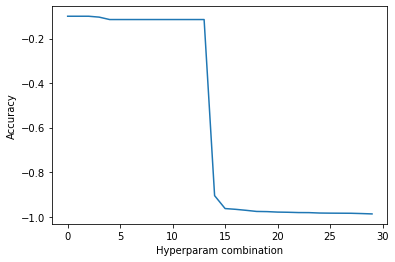

In [24]:
results['loss'].plot()
plt.ylabel('Accuracy')
plt.xlabel('Hyperparam combination')

# Evaluate the model

In [25]:
# load best model

model = load_model(path_best_model)

In [26]:
# make predictions in test set

result = model.evaluate(x=X_test,
                        y=y_test)

132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9866 - loss: 0.0429


In [27]:
# print evaluation metrics

for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.04464539885520935
compile_metrics 0.9852380752563477


## Confusion matrix

In [28]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 

cm

132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


array([[415,   0,   0,   0,   1,   0,   0,   0,   6,   0],
       [  0, 466,   2,   0,   1,   0,   1,   1,   2,   0],
       [  0,   0, 406,   1,   0,   0,   0,   0,   2,   0],
       [  0,   0,   0, 422,   0,   0,   0,   1,   3,   0],
       [  1,   0,   1,   0, 418,   0,   2,   2,   1,   4],
       [  0,   0,   0,   2,   0, 378,   2,   0,   0,   0],
       [  0,   0,   0,   0,   1,   1, 409,   0,   1,   0],
       [  0,   0,   4,   1,   0,   0,   0, 463,   0,   1],
       [  0,   1,   1,   4,   0,   2,   0,   0, 376,   0],
       [  3,   0,   0,   2,   1,   0,   0,   1,   2, 385]], dtype=int64)

Text(0.5, 13.421126458070312, 'Predicted label')

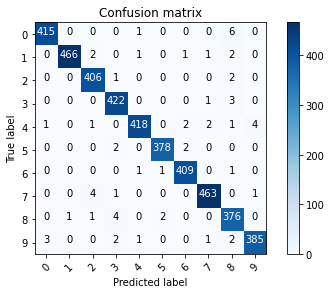

In [29]:
# let's make it more colourful
classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Here we can see that our CNN performs very well on all digits.